In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd

import glob, os

#To serialize and save the models after training them for the first time, then load them from memory afterwards to save time
from joblib import dump, load
#import dill 

## Load and parse the data downloaded from Etsy and preselected-cleaned in the 'data_downloading' notebook


In [2]:
csv_filename_pattern = f'./Git_exclude/Data/all_paintings*.csv'

all_paintings_csv_files = glob.glob(csv_filename_pattern)
all_paintings_csv_files

['./Git_exclude/Data\\all_paintings_from_USD100_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_and_image_info.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_tags.csv']

In [3]:
# #Option 1: load all paintings in the $250-650 range, even if they don't have style and image information (~50000 entries)

# min_price = 250.0

# csv_all_cleaned_listings = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_cleaned_listings.csv'

# all_paintings_df = pd.read_csv(csv_all_cleaned_listings)

# print(f'Loaded listings file {csv_all_cleaned_listings} with all the cleaned listings (multiple taxonomies, with or without style data).')

In [4]:
#Option 2: load only the paintings in the $250-650 range that have style information (~20000 entries)

# min_price = 250.0

# csv_all_cleaned_listings_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'
# paintings_with_style_tags_df = pd.read_csv(csv_all_cleaned_listings_w_style)
# print(f'Loaded all listings file {csv_all_cleaned_listings_w_style} with some style-related tags, after cleaning up the data.')

In [5]:
#Option 3: load only the paintings in the $250-650 range that have style and also some image information (~20000 entries, just ~300 fewer than option 2)

min_price = 250.0

csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'
paintings_with_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)
print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with style-related tags and some image info, after cleaning up the data.')


Loaded all listings file ./Git_exclude/Data/all_paintings_from_USD250_listings_with_style_and_image_info.csv with style-related tags and some image info, after cleaning up the data.


In [6]:
paintings_with_style_tags_and_image_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19459 entries, 0 to 19458
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   19459 non-null  int64  
 1   user_id                      19459 non-null  int64  
 2   shop_id                      19459 non-null  int64  
 3   title                        19459 non-null  object 
 4   description                  19459 non-null  object 
 5   shop_section_id              12972 non-null  float64
 6   featured_rank                19459 non-null  int64  
 7   url                          19459 non-null  object 
 8   num_favorers                 19459 non-null  int64  
 9   is_customizable              19459 non-null  bool   
 10  tags                         19459 non-null  object 
 11  materials                    19459 non-null  object 
 12  shipping_profile_id          13401 non-null  float64
 13  when_made       

Keep the labels to be predicted, in this case the prices, in a separate data structure than the features. 

In [7]:
prices = paintings_with_style_tags_and_image_info_df['price'].values

In [8]:
len(prices)

19459

In [9]:
#Note that this is a numpy array rather than a list (as in the ML miniproject) but it should be ok
prices[:5]

array([250., 250., 250., 250., 250.])

In [10]:
#How many different sellers are there?
paintings_with_style_tags_and_image_info_df['shop_id'].nunique()

5711

In [11]:
paintings_with_style_tags_and_image_info_df['user_id'].nunique()

5711

In [12]:
#So in average every seller has 3-4 paintings in this list.. it might be important to add the shop_id as a categorical feature later on

In [13]:
#check how many paintings have invalid 'mean_image' information - and impute nan values if any 

In [14]:
paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].describe()

image_red    image_blue   image_green  image_saturation  \
count  19458.000000  19458.000000  19458.000000      19458.000000   
mean     133.205263    116.372186    125.724484         21.336160   
std       30.874357     33.274949     28.519228         15.554925   
min       17.000000      4.000000     19.000000          0.000000   
25%      113.000000     94.000000    107.000000          9.000000   
50%      133.000000    115.000000    125.000000         18.000000   
75%      153.000000    138.000000    143.000000         30.000000   
max      249.000000    249.000000    247.000000         96.000000   

          image_hue  image_brightness  
count  19458.000000      19458.000000  
mean      99.277367         54.596259  
std       98.015625         10.972636  
min        0.000000         14.000000  
25%       29.000000         47.000000  
50%       46.000000         54.000000  
75%      180.000000         61.000000  
max      359.000000         97.000000

In [15]:
np.where(paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].isna()==True)

(array([8070, 8070, 8070, 8070, 8070, 8070], dtype=int64),
 array([0, 1, 2, 3, 4, 5], dtype=int64))

In [16]:
paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

image_red          NaN
image_blue         NaN
image_green        NaN
image_saturation   NaN
image_hue          NaN
image_brightness   NaN
Name: 8070, dtype: float64

In [17]:
#impute the missing values with the mean colors across all paintings:
paintings_with_style_tags_and_image_info_df['image_red'].fillna(value=paintings_with_style_tags_and_image_info_df['image_red'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_green'].fillna(value=paintings_with_style_tags_and_image_info_df['image_green'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_blue'].fillna(value=paintings_with_style_tags_and_image_info_df['image_blue'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_saturation'].fillna(value=paintings_with_style_tags_and_image_info_df['image_saturation'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_hue'].fillna(value=paintings_with_style_tags_and_image_info_df['image_hue'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_brightness'].fillna(value=paintings_with_style_tags_and_image_info_df['image_brightness'].mean(),inplace=True)

In [18]:
paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

image_red           133.205263
image_blue          116.372186
image_green         125.724484
image_saturation     21.336160
image_hue            99.277367
image_brightness     54.596259
Name: 8070, dtype: float64

# Models


### Set aside 20% of the data for testing the model at the end - this also shuffles the dataframe (which is good since listings were ordered by price)

In [19]:
from sklearn.model_selection import train_test_split

paintings_df_train, paintings_df_test = train_test_split(paintings_with_style_tags_and_image_info_df, test_size=0.2, random_state=1)

In [20]:
len(paintings_df_test)

3892

In [21]:
len(paintings_df_train)

15567

In [22]:
paintings_df_train.head()

listing_id    user_id   shop_id  \
4930    764408086   13034808   8946559   
8561    838240660  348464339  24594447   
3516    692697340   63771712  19532572   
5679    616076710    9358682   5817337   
16632   658664886   59410411  10475229   

                                                   title  \
4930   Granny Art Vintage Muted water scene on light ...   
8561   Jazz Saxophone Abstract 24x18 Original Oil Pai...   
3516         Yosemite Half Dome with Ariel the Airstream   
5679   Lemon Painting, Original Oil Artwork, Still Li...   
16632                                     Beyond In Love   

                                             description  shop_section_id  \
4930   Vintage Muted seascape water scene on light oa...       17504291.0   
8561   This unique original oil painting was inspired...       29940187.0   
3516   Our Airstream parked in one of my favorite and...              NaN   
5679   Original oil painting on a square 10 x 10 inch...        6861999.0   
16632  Beyond In Love\n\nWatercolor, Gouache and Ink ...       23281398.0   

       featured_rank                                                url  \
4930              -1  https://www.etsy.com/listing/764408086/granny-...   
8561              -1  https://www.etsy.com/listing/838240660/jazz-sa...   
3516               0  https://www.etsy.com/listing/692697340/yosemit...   
5679              -1  https://www.etsy.com/listing/616076710/lemon-p...   
16632             -1  https://www.etsy.com/listing/658664886/beyond-...   

       num_favorers  is_customizable  ... image_brightness  \
4930             13            False  ...             45.0   
8561              0            False  ...             56.0   
3516              5            False  ...             40.0   
5679             35            False  ...             60.0   
16632             7             True  ...             53.0   

      image_is_black_and_white  image_creation_tsz image_rank  \
4930                     False          1581521804          1   
8561                     False          1615942394          1   
3516                     False          1586474349          1   
5679                     False          1532024416          1   
16632                    False          1633897841          1   

                                         image_url_75x75  \
4930   https://i.etsystatic.com/8946559/r/il/3dd33f/2...   
8561   https://i.etsystatic.com/24594447/r/il/e67e5e/...   
3516   https://i.etsystatic.com/19532572/r/il/c6d0e8/...   
5679   https://i.etsystatic.com/5817337/r/il/a3bb67/1...   
16632  https://i.etsystatic.com/10475229/r/il/c2ce0b/...   

                                       image_url_170x135  \
4930   https://i.etsystatic.com/8946559/r/il/3dd33f/2...   
8561   https://i.etsystatic.com/24594447/r/il/e67e5e/...   
3516   https://i.etsystatic.com/19532572/r/il/c6d0e8/...   
5679   https://i.etsystatic.com/5817337/r/il/a3bb67/1...   
16632  https://i.etsystatic.com/10475229/r/il/c2ce0b/...   

                                         image_url_570xN  \
4930   https://i.etsystatic.com/8946559/r/il/3dd33f/2...   
8561   https://i.etsystatic.com/24594447/r/il/e67e5e/...   
3516   https://i.etsystatic.com/19532572/r/il/c6d0e8/...   
5679   https://i.etsystatic.com/5817337/r/il/a3bb67/1...   
16632  https://i.etsystatic.com/10475229/r/il/c2ce0b/...   

                                     image_url_fullxfull  image_full_height  \
4930   https://i.etsystatic.com/8946559/r/il/3dd33f/2...               1240   
8561   https://i.etsystatic.com/24594447/r/il/e67e5e/...               1507   
3516   https://i.etsystatic.com/19532572/r/il/c6d0e8/...               3000   
5679   https://i.etsystatic.com/5817337/r/il/a3bb67/1...               1000   
16632  https://i.etsystatic.com/10475229/r/il/c2ce0b/...               1814   

       image_full_width  
4930               1360  
8561               1500  
3516               2250  
5679               1000  
16632              2610  



In [23]:
paintings_df_test.head()

listing_id    user_id   shop_id  \
14269  1020376182    7171595  30323084   
16952   564549959  107586113  16213887   
9759   1033593766  116323951  15411704   
620     685627441  116419745  15473440   
11395   953792299   20295098   8628312   

                                                   title  \
14269                                       Moose Family   
16952      Acrylic painting- Mystery woman with red lips   
9759   Early Mid Century California Plein Air Tide Po...   
620                                               Binary   
11395   Du Barry Fashion Studios (active 1940s to 1960s)   

                                             description  shop_section_id  \
14269  Springtime in Steamboat Springs, Colorado offe...              NaN   
16952  Acrylic painting.\n\nDETAILS:\n\n* TITLE: &quo...              NaN   
9759   Frame 17 3/4 x 14 3/4&quot;\nMasonite : 11 x 1...       28276743.0   
620    This piece is titled, &quot;Binary&quot;. It i...       25715334.0   
11395   DU BARRY FASHION STUDIOS (active 1940s to 1960s)              NaN   

       featured_rank                                                url  \
14269             -1  https://www.etsy.com/listing/1020376182/moose-...   
16952             -1  https://www.etsy.com/listing/564549959/acrylic...   
9759             279  https://www.etsy.com/listing/1033593766/early-...   
620               -1      https://www.etsy.com/listing/685627441/binary   
11395             -1  https://www.etsy.com/listing/953792299/du-barr...   

       num_favorers  is_customizable  ... image_brightness  \
14269             0            False  ...             45.0   
16952             1            False  ...             49.0   
9759              7            False  ...             53.0   
620               3            False  ...             43.0   
11395             0            False  ...             58.0   

      image_is_black_and_white  image_creation_tsz image_rank  \
14269                    False          1628794732          1   
16952                    False          1507916923          1   
9759                     False          1625620520          1   
620                      False          1629945422          1   
11395                    False          1612122913          1   

                                         image_url_75x75  \
14269  https://i.etsystatic.com/30323084/c/1500/1192/...   
16952  https://i.etsystatic.com/16213887/r/il/451e2c/...   
9759   https://i.etsystatic.com/15411704/r/il/eeeb02/...   
620    https://i.etsystatic.com/15473440/r/il/e5f21d/...   
11395  https://i.etsystatic.com/8628312/r/il/f16236/2...   

                                       image_url_170x135  \
14269  https://i.etsystatic.com/30323084/c/1500/1192/...   
16952  https://i.etsystatic.com/16213887/r/il/451e2c/...   
9759   https://i.etsystatic.com/15411704/r/il/eeeb02/...   
620    https://i.etsystatic.com/15473440/r/il/e5f21d/...   
11395  https://i.etsystatic.com/8628312/r/il/f16236/2...   

                                         image_url_570xN  \
14269  https://i.etsystatic.com/30323084/r/il/83860f/...   
16952  https://i.etsystatic.com/16213887/r/il/451e2c/...   
9759   https://i.etsystatic.com/15411704/r/il/eeeb02/...   
620    https://i.etsystatic.com/15473440/r/il/e5f21d/...   
11395  https://i.etsystatic.com/8628312/r/il/f16236/2...   

                                     image_url_fullxfull  image_full_height  \
14269  https://i.etsystatic.com/30323084/r/il/83860f/...               2499   
16952  https://i.etsystatic.com/16213887/r/il/451e2c/...               2250   
9759   https://i.etsystatic.com/15411704/r/il/eeeb02/...               2250   
620    https://i.etsystatic.com/15473440/r/il/e5f21d/...                606   
11395  https://i.etsystatic.com/8628312/r/il/f16236/2...               2992   

       image_full_width  
14269              3000  
16952              3000  
9759               3000  
620                 675  
11395              2244  



In [24]:
paintings_df_test.index[:5]

Int64Index([14269, 16952, 9759, 620, 11395], dtype='int64')

In [25]:
#Make sure the test set has all 4 painting types represented
paintings_df_test['painting_type'].value_counts()

acrylic          1698
oil              1479
watercolor        447
more_than_one     268
Name: painting_type, dtype: int64

In [26]:
paintings_df_train['painting_type'].value_counts()

acrylic          6747
oil              6014
watercolor       1674
more_than_one    1132
Name: painting_type, dtype: int64

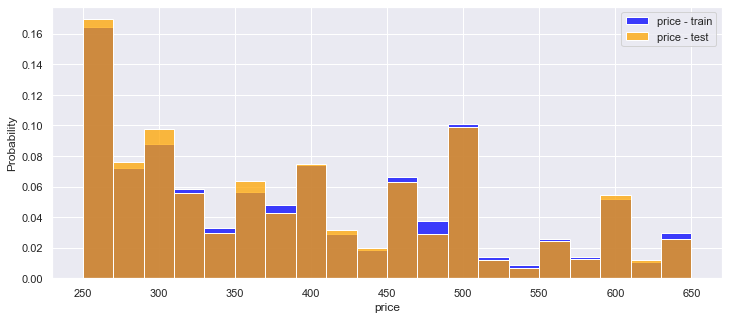

In [27]:
#check that the price distribution is also consistent:
plt.figure(figsize=(12,5))
sns.histplot(data=paintings_df_train,x='price',stat='probability',bins=20,color='blue')
sns.histplot(data=paintings_df_test,x='price',stat='probability',bins=20,color='orange')
#paintings_df_train['price'].plot(kind='hist')
#paintings_df_test['price'].plot(kind='hist')
plt.legend(['price - train','price - test'])

In [28]:
#I need to also rearrange the 'prices' numpy array, so that I can later trace back the corresponding rows in the dataframe
prices_train = prices[paintings_df_train.index]
prices_test = prices[paintings_df_test.index]

In [29]:
len(prices_train)

15567

In [30]:
#sanity check
prices_train[:5]

array([295., 350., 275., 300., 525.])

In [31]:
paintings_df_train['price'].iloc[:5]

4930     295.0
8561     350.0
3516     275.0
5679     300.0
16632    525.0
Name: price, dtype: float64

In [32]:
#sanity check
prices_test[-5:]

array([295.  , 399.99, 450.  , 275.  , 500.  ])

In [33]:
paintings_df_test['price'].iloc[-5:]

5056     295.00
10907    399.99
13123    450.00
3946     275.00
15285    500.00
Name: price, dtype: float64

### Feature types

In [34]:
#Let's divide the columns (features) into different groups, as I will test different models with different combinations of features
numerical_columns = ['num_favorers','featured_rank','max_dimension','aspect_ratio','area','weight','days_from_original_creation','days_from_last_modification'] 

categorical_columns = ['painting_type','when_made'] #,'made_by_seller','is_customizable','has_variations']

boolean_columns = ['made_by_seller','is_customizable','has_variations']

image_columns = ['image_red','image_green','image_blue','image_hue','image_saturation','image_brightness']

#the following are textual 'tags' that may have some predictive power (likely 'style_tags_new', perhaps 'tags' - not sure about 'materials')
tag_columns = ['style_tags_new','tags','materials']

#The following are 'free text' that are unlikely to be very predictive, but I could try to add them
text_columns = ['title','description']

#Finally, this is the identifier of the seller/artist:
user_column = ['shop_id']


### Baseline results picking the mean price of the paintings in the training set as my predictions

In [35]:
trivial_price_pred_train = np.ones(len(prices_train)) * np.mean(prices_train)

In [36]:
trivial_price_pred_test = np.ones(len(prices_test)) * np.mean(prices_train)

In [37]:
from sklearn import metrics

def print_all_scores_train_test(y_train,y_train_pred,y_test,y_test_pred,model_name='Results'):
    print(model_name+':')
    print("Training R^2:", metrics.r2_score(y_train, y_train_pred))
    print("Testing R^2:", metrics.r2_score(y_test, y_test_pred))
    print("Training RMSE: USD", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print("Testing RMSE: USD", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
    print("Training MAE: USD", metrics.mean_absolute_error(y_train, y_train_pred))
    print("Testing MAE: USD", metrics.mean_absolute_error(y_test, y_test_pred))

print_all_scores_train_test(prices_train,trivial_price_pred_train,prices_test,trivial_price_pred_test,model_name='Trivial model using the mean price of the training set paintings')

Trivial model using the mean price of the training set paintings:
Training R^2: 0.0
Testing R^2: -0.0011129435654106956
Training RMSE: USD 115.65203927194021
Testing RMSE: USD 115.5684146996469
Training MAE: USD 98.77566847195826
Testing MAE: USD 98.81188688275215


## 1) Models using only numerical features

To select only the numerical features, I use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), which works with Pandas data frames (or alternatively with NumPy arrays).

I will scale each of the numerical variables using a StandardScaler so they are all comparable to each other

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#I could select and scale at the same time:
numerical_scaler_selector = ColumnTransformer([
    ('numerical scaled (std)', StandardScaler(), numerical_columns),
], remainder='drop')

In [39]:
#Let's test it out - note that it returns a numpy array, with mean equal to zero :
test = numerical_scaler_selector.fit_transform(paintings_with_style_tags_and_image_info_df)

In [40]:
test[0]

array([ 0.58513566, -0.10930993,  0.41210228, -0.35295979,  0.89841081,
        0.27424499,  5.09195353,  0.0992361 ])

In [41]:
np.mean(test,axis=0)

array([-9.49386460e-18, -1.46059455e-18, -3.62227449e-16,  1.33279253e-17,
        1.16847564e-16, -7.59509168e-17,  1.82574319e-17,  3.89978746e-16])

In [42]:
np.std(test,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [43]:
#But it's probably cleaner to keep the selector and the scaling separately, e.g. 
numerical_selector = ColumnTransformer([
    ('numerical', 'passthrough', numerical_columns),
], remainder='drop')

In [44]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

numerical_preproc_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('standard scaling', StandardScaler()),
])

In [45]:
#Let's check that I get the same results as before:
test2 = numerical_preproc_pipe.fit_transform(paintings_with_style_tags_and_image_info_df)

In [46]:
test2[0]

array([ 0.58513566, -0.10930993,  0.41210228, -0.35295979,  0.89841081,
        0.27424499,  5.09195353,  0.0992361 ])

### Model 1a) Linear regression using only numerical features

In [47]:
#This is a good start since it has no parameters to fit, and the solution should be really fast to compute (no cross-validation, etc.)
from sklearn.linear_model import LinearRegression

numerical_linreg_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [48]:
#Let's visualize this pipeline:
from sklearn import set_config
set_config(display='diagram')

numerical_linreg_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('linear reg', LinearRegression())])

In [49]:
#Train the model
numerical_linreg_pipe.fit(paintings_df_train,prices_train);

In [50]:
#Predict prices on training set:
prices_train_pred = numerical_linreg_pipe.predict(paintings_df_train)

In [51]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_train,prices_train)

0.06578759944869916

In [52]:
#Predict prices on test set:
prices_test_pred = numerical_linreg_pipe.predict(paintings_df_test)

In [53]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_test,prices_test)

0.0788971295497991

In [54]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only numerical features')

#Note that I am not overfitting the training data, since the model actually does better on test data

Linear regression model using only numerical features:
Training R^2: 0.06578759944869916
Testing R^2: 0.0788971295497991
Training RMSE: USD 111.78308956396623
Testing RMSE: USD 110.85408089777948
Training MAE: USD 94.86939480487499
Testing MAE: USD 94.18784831024173


Text(0, 0.5, 'predicted prices (test)')

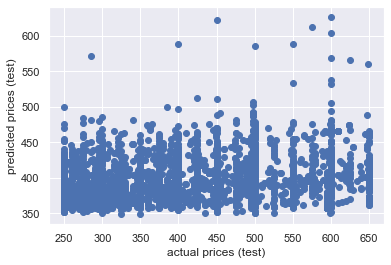

In [55]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


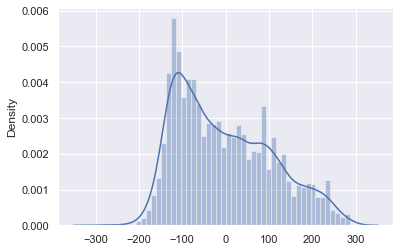

In [56]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [57]:
#Let's look at the coefficients of the model
# intercept
print(numerical_linreg_pipe['linear reg'].intercept_)

394.353173379585


In [58]:
#coefficients for each variable:
coeff_df = pd.DataFrame(numerical_linreg_pipe['linear reg'].coef_,numerical_columns,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
num_favorers                      1.554021
featured_rank                     2.069825
max_dimension                     0.122143
aspect_ratio                     12.318451
area                             23.225107
weight                            8.439767
days_from_original_creation      -0.335826
days_from_last_modification       1.729450

In [59]:
#looks like area and aspect_ratio are the most informative numerical variables

### Model 1b) Polynomial regression using only numerical features

In [60]:
from sklearn.preprocessing import PolynomialFeatures

numerical_polyreg_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('linear reg', LinearRegression())])

In [61]:
#Train the model
numerical_polyreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linear reg', LinearRegression())])

In [62]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_pipe.score(paintings_df_train,prices_train)

0.0983159678208011

In [63]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_pipe.score(paintings_df_test,prices_test)

0.04567696996191417

In [64]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial regression model using only numerical features')


Polynomial regression model using only numerical features:
Training R^2: 0.0983159678208011
Testing R^2: 0.04567696996191417
Training RMSE: USD 109.81975852825491
Testing RMSE: USD 112.83538625949616
Training MAE: USD 92.06916866633601
Testing MAE: USD 93.17433793546634


In [65]:
#It looks like I am already overfitting the training data, so let's try to replace the linear regression with a ridge regression or LASSO model

In [66]:
from sklearn.linear_model import Ridge

numerical_polyreg_ridge_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

numerical_polyreg_ridge_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=10))])

In [67]:
numerical_polyreg_ridge_pipe.get_params()

{'memory': None,
 'steps': [('numerical preproc',
   Pipeline(steps=[('numerical selector',
                    ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                     ['num_favorers',
                                                      'featured_rank',
                                                      'max_dimension',
                                                      'aspect_ratio', 'area',
                                                      'weight',
                                                      'days_from_original_creation',
                                                      'days_from_last_modification'])])),
                   ('standard scaling', StandardScaler())])),
  ('polynomial_trans', PolynomialFeatures(degree=3, include_bias=False)),
  ('ridge', Ridge(alpha=10))],
 'verbose': False,
 'numerical preproc': Pipeline(steps=[('numerical selector',
                  ColumnTransformer(transformers=[(

In [68]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
numerical_polyreg_ridge_CVmodel = GridSearchCV(numerical_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [69]:
numerical_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   21.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical preproc',
                                        Pipeline(steps=[('numerical selector',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          'passthrough',
                                                                                          ['num_favorers',
                                                                                           'featured_rank',
                                                                                           'max_dimension',
                                                                                           'aspect_ratio',
                                                                                           'area',
                                                                                           'weight',
                                                                                           'days_from_original_creation',
                                                                                           'days_from_last_modification'])])),
                                                        ('standard scaling',
                                                         StandardScaler())])),
                                       ('poly...
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [70]:
numerical_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 112883.78916846884}

In [71]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.054777721398355794

In [72]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.05370241101252504

In [73]:
print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial Ridge regression model using only numerical features')

Polynomial Ridge regression model using only numerical features:
Training R^2: 0.054777721398355794
Testing R^2: 0.05370241101252504
Training RMSE: USD 112.43985312756409
Testing RMSE: USD 112.35993633953481
Training MAE: USD 95.70448509932582
Testing MAE: USD 95.69392863236232


In [74]:
#Now I am not overfitting, but the performance is worse than normal linear regression

In [75]:
numerical_polyreg_ridge_CVmodel.cv_results_

{'mean_fit_time': array([0.13499713, 0.13829451, 0.117137  , 0.10046   , 0.09705782,
        0.10021315, 0.09194655, 0.09493918, 0.08719883, 0.09776711,
        0.10049624, 0.09737611, 0.09449153, 0.0887464 , 0.09082918,
        0.0961401 , 0.09252391, 0.09234896, 0.0864502 , 0.0988812 ]),
 'std_fit_time': array([0.03060148, 0.01248077, 0.00512175, 0.00624486, 0.00559477,
        0.00162691, 0.01083623, 0.00649566, 0.00446952, 0.00486941,
        0.00601734, 0.00692279, 0.00518521, 0.00420398, 0.00632456,
        0.00437344, 0.00348272, 0.00592967, 0.00475962, 0.00412532]),
 'mean_score_time': array([0.01794081, 0.0203331 , 0.01726742, 0.01449199, 0.01433573,
        0.01426497, 0.01593461, 0.01449318, 0.01890264, 0.01526222,
        0.01743746, 0.0158052 , 0.01771536, 0.01650419, 0.01444283,
        0.01491528, 0.01272607, 0.01743646, 0.01248865, 0.01374393]),
 'std_score_time': array([0.00140858, 0.0025674 , 0.0038623 , 0.00465269, 0.00483268,
        0.00414528, 0.00361263, 0.003901

In [76]:
#Let's try Lasso next:

In [77]:
from sklearn.linear_model import Lasso

numerical_polyreg_lasso_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('lasso', Lasso(alpha=1))])

numerical_polyreg_lasso_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lasso', Lasso(alpha=1))])

In [78]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'lasso__alpha': np.linspace(0,10,1)} 
numerical_polyreg_lasso_CVmodel = GridSearchCV(numerical_polyreg_lasso_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [79]:
numerical_polyreg_lasso_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.6s finished
C:\Users\matte\anaconda3\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\matte\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\matte\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94043860.21990487, tolerance: 20821.476132083513
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical preproc',
                                        Pipeline(steps=[('numerical selector',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          'passthrough',
                                                                                          ['num_favorers',
                                                                                           'featured_rank',
                                                                                           'max_dimension',
                                                                                           'aspect_ratio',
                                                                                           'area',
                                                                                           'weight',
                                                                                           'days_from_original_creation',
                                                                                           'days_from_last_modification'])])),
                                                        ('standard scaling',
                                                         StandardScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('lasso', Lasso(alpha=1))]),
             n_jobs=2, param_grid={'lasso__alpha': array([0.])}, verbose=1)

In [80]:
numerical_polyreg_lasso_CVmodel.best_params_

{'lasso__alpha': 0.0}

In [81]:
#By picking alpha=0, the model is saying that linear regression (with polynomial features) is the best choice. 
#However, we already know this overfits a bit the training data, and does not improve much the perofrmance w.r.t. pure linear model. 

In [82]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_lasso_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_lasso_CVmodel.score(paintings_df_train,prices_train)

0.09666481258747983

In [83]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_lasso_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_lasso_CVmodel.score(paintings_df_test,prices_test)

0.05811890705196254

In [84]:
print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial Lasso regression model using only numerical features')

Polynomial Lasso regression model using only numerical features:
Training R^2: 0.09666481258747983
Testing R^2: 0.05811890705196254
Training RMSE: USD 109.92026298783618
Testing RMSE: USD 112.09743034993375
Training MAE: USD 92.17825402854534
Testing MAE: USD 92.95426647710445


Text(0, 0.5, 'predicted prices (test)')

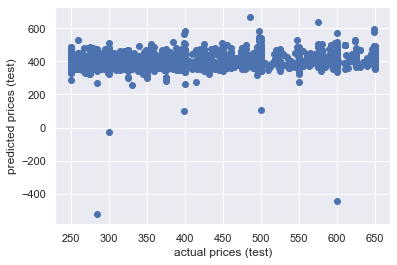

In [85]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


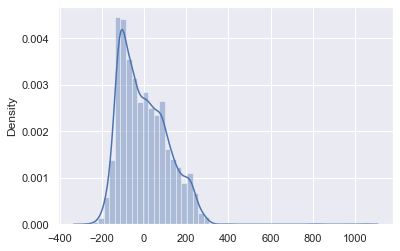

In [86]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [87]:
#Let's look at the coefficients of the model
# intercept
numerical_polyreg_lasso_CVmodel.best_estimator_['lasso'].intercept_

389.98116926461955

In [88]:
#coefficients for each variable:
coeff_df = pd.DataFrame(numerical_polyreg_lasso_CVmodel.best_estimator_['lasso'].coef_,columns=['Lasso Reg Coeff']) #numerical_columns,
coeff_df.sort_values(by='Lasso Reg Coeff', ascending=False)

Lasso Reg Coeff
4          29.613393
134        23.217979
61         21.388187
10         20.359942
17         18.993093
..               ...
12        -13.647082
19        -14.577884
36        -18.540016
115       -24.515830
30        -25.672416

[164 rows x 1 columns]

In [89]:
### The best linear model using only numerical variables seems to be the basic Linear Regression model, so I save it (unless alread done so)

In [90]:
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

numerical_linreg_pipe_filename = './Git_exclude/models/numerical_linreg_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(numerical_linreg_pipe_filename, 'rb') as f:
        numerical_linreg_pipe = load(f)
        print('Loaded joblib file with numerical-only linear regression.')
except: #if not, actually perform the fit then save the model for next time:
    
    numerical_linreg_pipe.fit(paintings_df_train,prices_train);
    
    with open(numerical_linreg_pipe_filename, 'wb') as f:
        dump(numerical_linreg_pipe, numerical_linreg_pipe_filename) 
    print('Saved joblib file with numerical-only linear regression.')

# #Version with dill

# import dill

# #If the model file already exists, I load it:
# try:
#     with open('lat_long_model.dill', 'rb') as f:
#         lat_long_model = dill.load(f)
#         print('Loaded pickle file with lat-long model.')
# except: #if not, actually perform the fit then save the model for next time:
    
#     lat_long_model.fit(data_shuffled, star_ratings_shuffled)
    
#     with open('lat_long_model.dill', 'wb') as f:
#         dill.dump(lat_long_model, f)
#     print('Saved pickle file with lat-long model.')


Loaded joblib file with numerical-only linear regression.


#### Model 1c) Decision tree using only numerical features

In [91]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [92]:
# #Recall that I already have the numerical selector, which need not change:
# numerical_selector = ColumnTransformer([
#     ('numerical', 'passthrough', numerical_columns),
# ], remainder='drop')

In [93]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

numerical_dtree_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [94]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
numerical_dtree_CVmodel = GridSearchCV(numerical_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [95]:
numerical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    5.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical selector',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation',
                                                                          'days_from_last_modification'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [96]:
numerical_dtree_CVmodel.best_params_['dtree__max_depth']

6

In [97]:
#Predict prices on training set:
prices_train_pred = numerical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.14475129088693084

In [98]:
#Predict prices on test set:
prices_test_pred = numerical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.14142099864554802

In [99]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only numerical features')


Decision Tree model using only numerical features:
Training R^2: 0.14475129088693084
Testing R^2: 0.14142099864554802
Training RMSE: USD 106.95461005940241
Testing RMSE: USD 107.02561915352705
Training MAE: USD 87.8120313943299
Testing MAE: USD 88.01957463081636


In [100]:
#what are the main features used for decision?
numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.00894639, 0.01492574, 0.50074545, 0.03257305, 0.09795923,
       0.22046162, 0.06636191, 0.0580266 ])

In [101]:
feature_names_num_dtree = numerical_dtree_CVmodel.best_estimator_['numerical selector'].get_feature_names()

numerical_dtree_features_imp_df = pd.DataFrame(numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_dtree,columns=['Dtree feature importance'])
numerical_dtree_features_imp_df = numerical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
numerical_dtree_features_imp_df

Dtree feature importance
max_dimension                                0.500745
weight                                       0.220462
area                                         0.097959
days_from_original_creation                  0.066362
days_from_last_modification                  0.058027
aspect_ratio                                 0.032573
featured_rank                                0.014926
num_favorers                                 0.008946

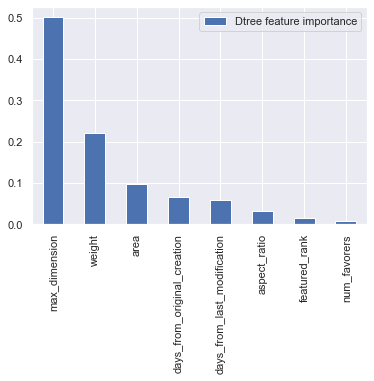

In [102]:
numerical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

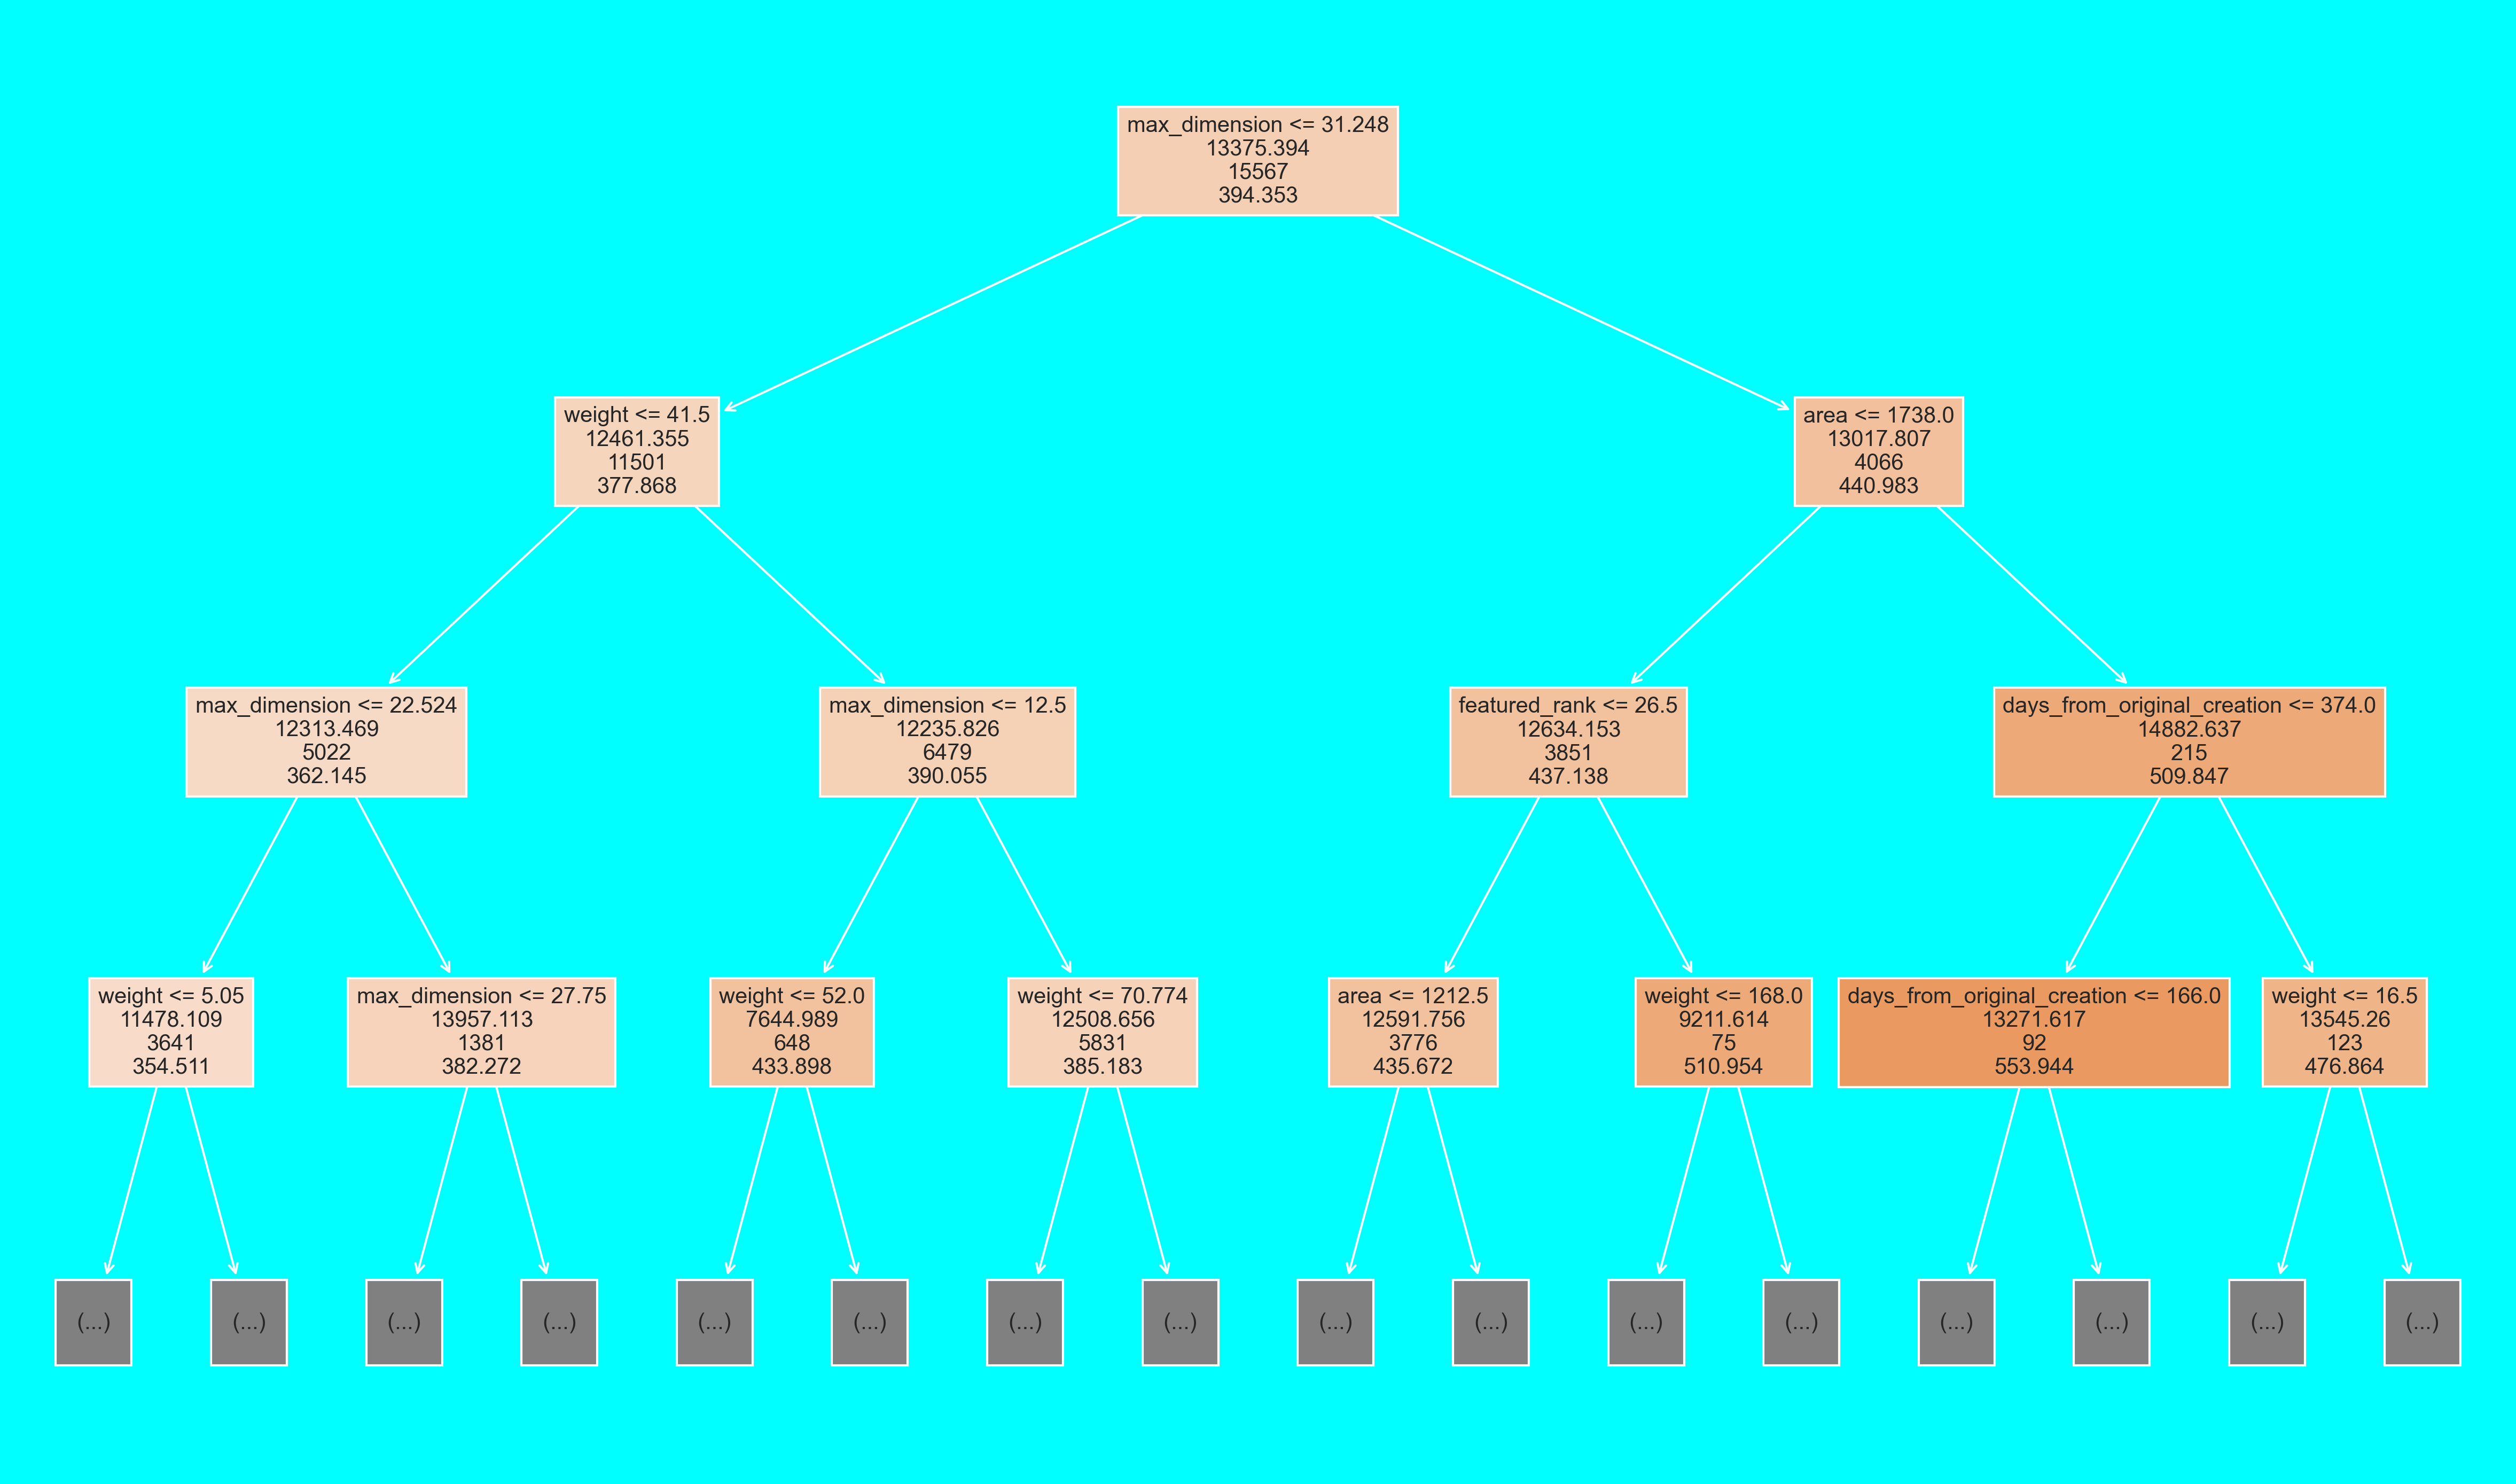

In [103]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(numerical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='none',filled=True,feature_names = feature_names_num_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_only.png')

# #export_graphviz(categorical_tree_pipe['decision tree'],out_file=None)
#graphviz.Source(export_graphviz(numerical_dtree_CVmodel.best_estimator_['dtree'], out_file=None))

#### Model 1d) Random Forest using only numerical features

In [104]:
from sklearn.ensemble import RandomForestRegressor

In [105]:
numerical_rforest_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('rforest', RandomForestRegressor(n_estimators=20,max_features='sqrt',n_jobs=2,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [106]:
numerical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=7, max_features='sqrt',
                                       max_samples=0.8, n_estimators=20,
                                       n_jobs=2, random_state=1))])

In [107]:
#Predict prices on training set:
prices_train_pred = numerical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_train,prices_train)

0.16784202727827102

In [108]:
#Predict prices on test set:
prices_test_pred = numerical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_test,prices_test)

0.1518000664208089

In [109]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only numerical features')


Random Forest model using only numerical features:
Training R^2: 0.16784202727827102
Testing R^2: 0.1518000664208089
Training RMSE: USD 105.50090479061792
Testing RMSE: USD 106.37675416935902
Training MAE: USD 87.69412602709103
Testing MAE: USD 88.66544291459743


In [110]:
#what are the main features used for decision?
numerical_rforest_pipe['rforest'].feature_importances_

array([0.04203555, 0.01762342, 0.22142353, 0.1045655 , 0.2991992 ,
       0.17553421, 0.08129487, 0.05832372])

In [111]:
feature_names_num_rforest = numerical_rforest_pipe['numerical selector'].get_feature_names()

numerical_rforest_features_imp_df = pd.DataFrame(numerical_rforest_pipe['rforest'].feature_importances_,feature_names_num_rforest,columns=['Rforest feature importance'])
numerical_rforest_features_imp_df = numerical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
numerical_rforest_features_imp_df

Rforest feature importance
area                                           0.299199
max_dimension                                  0.221424
weight                                         0.175534
aspect_ratio                                   0.104566
days_from_original_creation                    0.081295
days_from_last_modification                    0.058324
num_favorers                                   0.042036
featured_rank                                  0.017623

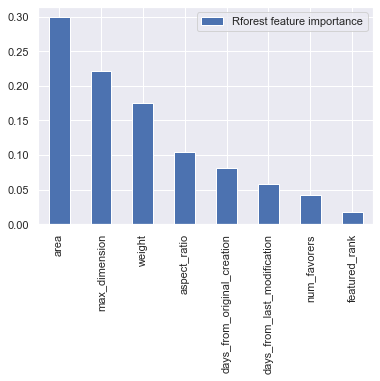

In [112]:
numerical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 1e) Gradient Boosting Trees using only numerical features¶

In [113]:
from sklearn.ensemble import GradientBoostingRegressor

In [114]:
numerical_gboost_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [115]:
numerical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=5, n_estimators=50,
                                           random_state=1, subsample=0.5))])

In [116]:
#Predict prices on training set:
prices_train_pred = numerical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_train,prices_train)

0.20511470555169953

In [117]:
#Predict prices on test set:
prices_test_pred = numerical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_test,prices_test)

0.16787744206496769

In [118]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only numerical features')


Gradient Boosting model using only numerical features:
Training R^2: 0.20511470555169953
Testing R^2: 0.16787744206496769
Training RMSE: USD 103.1111252353422
Testing RMSE: USD 105.3637612059539
Training MAE: USD 85.30633755808505
Testing MAE: USD 87.30628788158393


In [119]:
#what are the main features used for decision?
numerical_gboost_pipe['gboost'].feature_importances_

array([0.04964733, 0.02472346, 0.28585178, 0.07875351, 0.14345634,
       0.16652941, 0.1442517 , 0.10678647])

In [120]:
feature_names_num_gboost = numerical_gboost_pipe['numerical selector'].get_feature_names()

numerical_gboost_features_imp_df = pd.DataFrame(numerical_gboost_pipe['gboost'].feature_importances_,feature_names_num_gboost,columns=['Gboost feature importance'])
numerical_gboost_features_imp_df = numerical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
numerical_gboost_features_imp_df

Gboost feature importance
max_dimension                                 0.285852
weight                                        0.166529
days_from_original_creation                   0.144252
area                                          0.143456
days_from_last_modification                   0.106786
aspect_ratio                                  0.078754
num_favorers                                  0.049647
featured_rank                                 0.024723

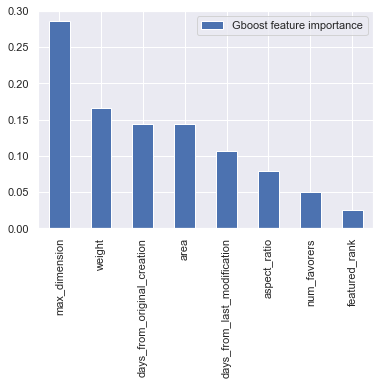

In [121]:
numerical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 2) Models using only categorical (and boolean) features

In [122]:
#I create a custom regressor to assess some 'baseline' model based on the 'painting_type' categorical feature: 
#how good is a model where I just return the mean price for all paintings of that category (e.g. all watercolors)? 

In [123]:
#Note that a sklearn Regressor takes numpy arrays - not dictionaries - but if I use a ColumnTransformer before the regressor I will be fine

In [124]:
painting_type_selector = ColumnTransformer([
    ('categorical', 'passthrough', ['painting_type']),
], remainder='drop')

In [125]:
#check that the output is a 2Darray
temp = painting_type_selector.fit_transform(paintings_df_train)

In [126]:
for listing in temp[:3]:
    print(listing)

['oil']
['oil']
['acrylic']


#### 2a) Baseline model using the mean price of paintings of each type

In [127]:
from sklearn.base import BaseEstimator, RegressorMixin

import numpy as np
from collections import defaultdict

class CategoricalMeanRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_price = dict()
    
    def fit(self, X, y):
        # Store the average price per categorical feature in self.avg_price
        price_sum = defaultdict(int)
        count = defaultdict(int)
 
        for listing, price in zip(X, y):
            # increment the running sum in price_sum
            price_sum[listing[0]]+=price
            # increment the running count in count
            count[listing[0]]+=1
        
        for category in price_sum:
            self.avg_price[category]=price_sum[category]/count[category]
               
        return self
    
    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for idx, listing in enumerate(X):
            if listing[0] in self.avg_price.keys():
                predictions[idx]=self.avg_price[listing[0]]
        
        return predictions

In [128]:
#Let's create a pipeline to apply the above "regressor" to the 'painting_type' column

from sklearn.pipeline import Pipeline

painting_type_mean_pipe = Pipeline([
    ('painting type selector', painting_type_selector),
    ('mean of painting_type', CategoricalMeanRegressor()),
])

In [129]:
painting_type_mean_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('painting type selector',
                 ColumnTransformer(transformers=[('categorical', 'passthrough',
                                                  ['painting_type'])])),
                ('mean of painting_type', CategoricalMeanRegressor())])

In [130]:
painting_type_mean_pipe[-1].avg_price

{'oil': 404.7454306617892,
 'acrylic': 393.35852230621066,
 'watercolor': 365.0730167264038,
 'more_than_one': 388.36983215547696}

In [131]:
#Check the results are right:
paintings_df_train.groupby(by='painting_type').mean()

listing_id       user_id       shop_id  shop_section_id  \
painting_type                                                              
acrylic        7.989581e+08  1.389216e+08  1.642913e+07     2.521571e+07   
more_than_one  7.587528e+08  1.134239e+08  1.504850e+07     2.366863e+07   
oil            7.992274e+08  1.107814e+08  1.445391e+07     2.330017e+07   
watercolor     7.721602e+08  1.129557e+08  1.430420e+07     2.322477e+07   

               featured_rank  num_favorers  is_customizable  \
painting_type                                                 
acrylic             0.067734     10.549726         0.152957   
more_than_one       1.045053     10.659011         0.131625   
oil                 1.035584     14.645826         0.124875   
watercolor          0.277180      9.529271         0.243728   

               shipping_profile_id  has_variations       price  ...  \
painting_type                                                   ...   
acrylic               9.024119e+10        0.090559  393.358522  ...   
more_than_one         8.260137e+10        0.136926  388.369832  ...   
oil                   7.984116e+10        0.084802  404.745431  ...   
watercolor            7.131768e+10        0.109319  365.073017  ...   

                image_red  image_green  image_blue   image_hue  \
painting_type                                                    
acrylic        132.332178   124.944824  118.265951  111.054584   
more_than_one  135.630742   128.020318  120.083039   93.264134   
oil            128.412205   121.314766  109.236615   92.349185   
watercolor     150.151135   142.755675  132.056153   88.989247   

               image_saturation  image_brightness  image_creation_tsz  \
painting_type                                                           
acrylic               21.266835         54.754350        1.583485e+09   
more_than_one         20.329505         55.530035        1.574186e+09   
oil                   22.598603         52.507316        1.581545e+09   
watercolor            17.715651         60.453405        1.577797e+09   

               image_rank  image_full_height  image_full_width  
painting_type                                                   
acrylic               1.0        1975.102712       1978.942048  
more_than_one         1.0        2025.025618       1959.461131  
oil                   1.0        1984.047057       2079.560027  
watercolor            1.0        1882.782557       2002.523297  

[4 rows x 32 columns]

In [132]:
#Now I am ready to assess the performance of this model:
prices_pred_train = painting_type_mean_pipe.predict(paintings_df_train)
prices_pred_test = painting_type_mean_pipe.predict(paintings_df_test)

In [133]:
print_all_scores_train_test(prices_train,prices_pred_train,prices_test,prices_pred_test,model_name='Trivial model using the mean price of the paintings of same type in the training set')

Trivial model using the mean price of the paintings of same type in the training set:
Training R^2: 0.010238819934646592
Testing R^2: 0.013293076017480199
Training RMSE: USD 115.05844573570002
Testing RMSE: USD 114.73388661165743
Training MAE: USD 98.09485006595159
Testing MAE: USD 97.8822969967778


In [134]:
#Select the categorical features (defined earlier) and apply OneHotEncoding to all of them - 
#for now I drop the first column since I will try LinearRegression and want to avoid multi-collinearity
#Separately, pass through the boolean variables

In [135]:
from sklearn.preprocessing import OneHotEncoder

# categorical_selector = ColumnTransformer([
#     ('categorical','passthrough', categorical_columns),
# ], remainder='drop')

categorical_selector = ColumnTransformer([
     ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
 ], remainder='drop')

In [136]:
categorical_selector.fit_transform(paintings_df_train)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [137]:
categorical_feature_names = categorical_selector.get_feature_names()

#### Model 2b) Linear regression using only categorical features

In [138]:
from sklearn.preprocessing import OneHotEncoder

#and then apply LinearRegression within a pipeline
from sklearn.pipeline import Pipeline

categorical_linreg_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('linear reg', LinearRegression()),
])

# categorical_linreg_pipe = Pipeline([
#     ('categorical selector', categorical_selector),
#     ('one hot encoding - drop 1st', OneHotEncoder(drop='first')),
#     ('linear reg', LinearRegression()),
# ])

In [139]:
#Train the model
categorical_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('linear reg', LinearRegression())])

In [140]:
#Predict prices on training set:
prices_train_pred = categorical_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_train,prices_train)

0.015937474313431954

In [141]:
#Predict prices on test set:
prices_test_pred = categorical_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_test,prices_test)

0.019843667865828474

In [142]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only categorical features with One-hot-encoding')


Linear regression model using only categorical features with One-hot-encoding:
Training R^2: 0.015937474313431954
Testing R^2: 0.019843667865828474
Training RMSE: USD 114.72673701652539
Testing RMSE: USD 114.35240230322299
Training MAE: USD 97.64433983934032
Testing MAE: USD 97.59096249572666


In [143]:
#Let's look at the coefficients of the model
# intercept
print(categorical_linreg_pipe['linear reg'].intercept_)

408.0748630953141


In [144]:
categorical_linreg_pipe['linear reg'].coef_

array([ -8.1309107 ,   8.7699868 , -31.42887982, -12.20708282,
        -4.23462108,  -7.48464552, -10.8170622 ,   4.25707393,
        18.46875813])

In [145]:
#coefficients for each variable:
coeff_df = pd.DataFrame(categorical_linreg_pipe['linear reg'].coef_,categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
categorical__x0_more_than_one         -8.130911
categorical__x0_oil                    8.769987
categorical__x0_watercolor           -31.428880
categorical__x1_made_2020s           -12.207083
categorical__x1_made_before_2010      -4.234621
categorical__x1_made_to_order         -7.484646
made_by_seller                       -10.817062
is_customizable                        4.257074
has_variations                        18.468758

### Model 2c) Decision Tree model using only categorical features

In [146]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [147]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
categorical_selector_no_drop = ColumnTransformer([
      ('categorical', OneHotEncoder(), categorical_columns),
     ('boolean','passthrough', boolean_columns),
  ], remainder='drop')

In [148]:
categorical_dtree_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [149]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
categorical_dtree_CVmodel = GridSearchCV(categorical_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [150]:
categorical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    6.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [151]:
categorical_dtree_CVmodel.best_params_

{'dtree__max_depth': 7}

In [152]:
#Predict prices on training set:
prices_train_pred = categorical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.03677639442256908

In [153]:
#Predict prices on test set:
prices_test_pred = categorical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.03478812949583632

In [154]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only categorical features with One-hot-encoding')


Decision Tree model using only categorical features with One-hot-encoding:
Training R^2: 0.03677639442256908
Testing R^2: 0.03478812949583632
Training RMSE: USD 113.50548627952774
Testing RMSE: USD 113.47728717533374
Training MAE: USD 96.17826167980336
Testing MAE: USD 96.27191355517591


In [155]:
#what are the main features used for decision?
categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.01532395, 0.03844562, 0.06797864, 0.2100054 , 0.0525275 ,
       0.09773471, 0.01939066, 0.02006199, 0.23440033, 0.11475393,
       0.12937727])

In [156]:
feature_names_cat_dtree = categorical_dtree_CVmodel.best_estimator_['categorical selector'].get_feature_names()

categorical_dtree_features_imp_df = pd.DataFrame(categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_cat_dtree,columns=['Dtree feature importance'])
categorical_dtree_features_imp_df = categorical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
categorical_dtree_features_imp_df

Dtree feature importance
made_by_seller                                    0.234400
categorical__x0_watercolor                        0.210005
has_variations                                    0.129377
is_customizable                                   0.114754
categorical__x1_made_2020s                        0.097735
categorical__x0_oil                               0.067979
categorical__x1_made_2010s                        0.052527
categorical__x0_more_than_one                     0.038446
categorical__x1_made_to_order                     0.020062
categorical__x1_made_before_2010                  0.019391
categorical__x0_acrylic                           0.015324

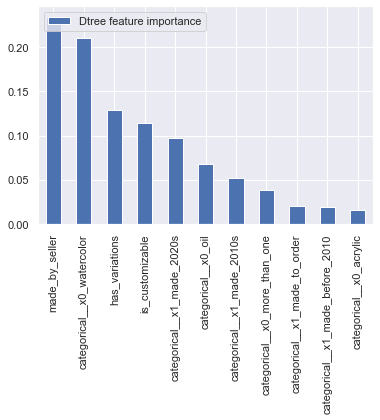

In [157]:
categorical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper left");

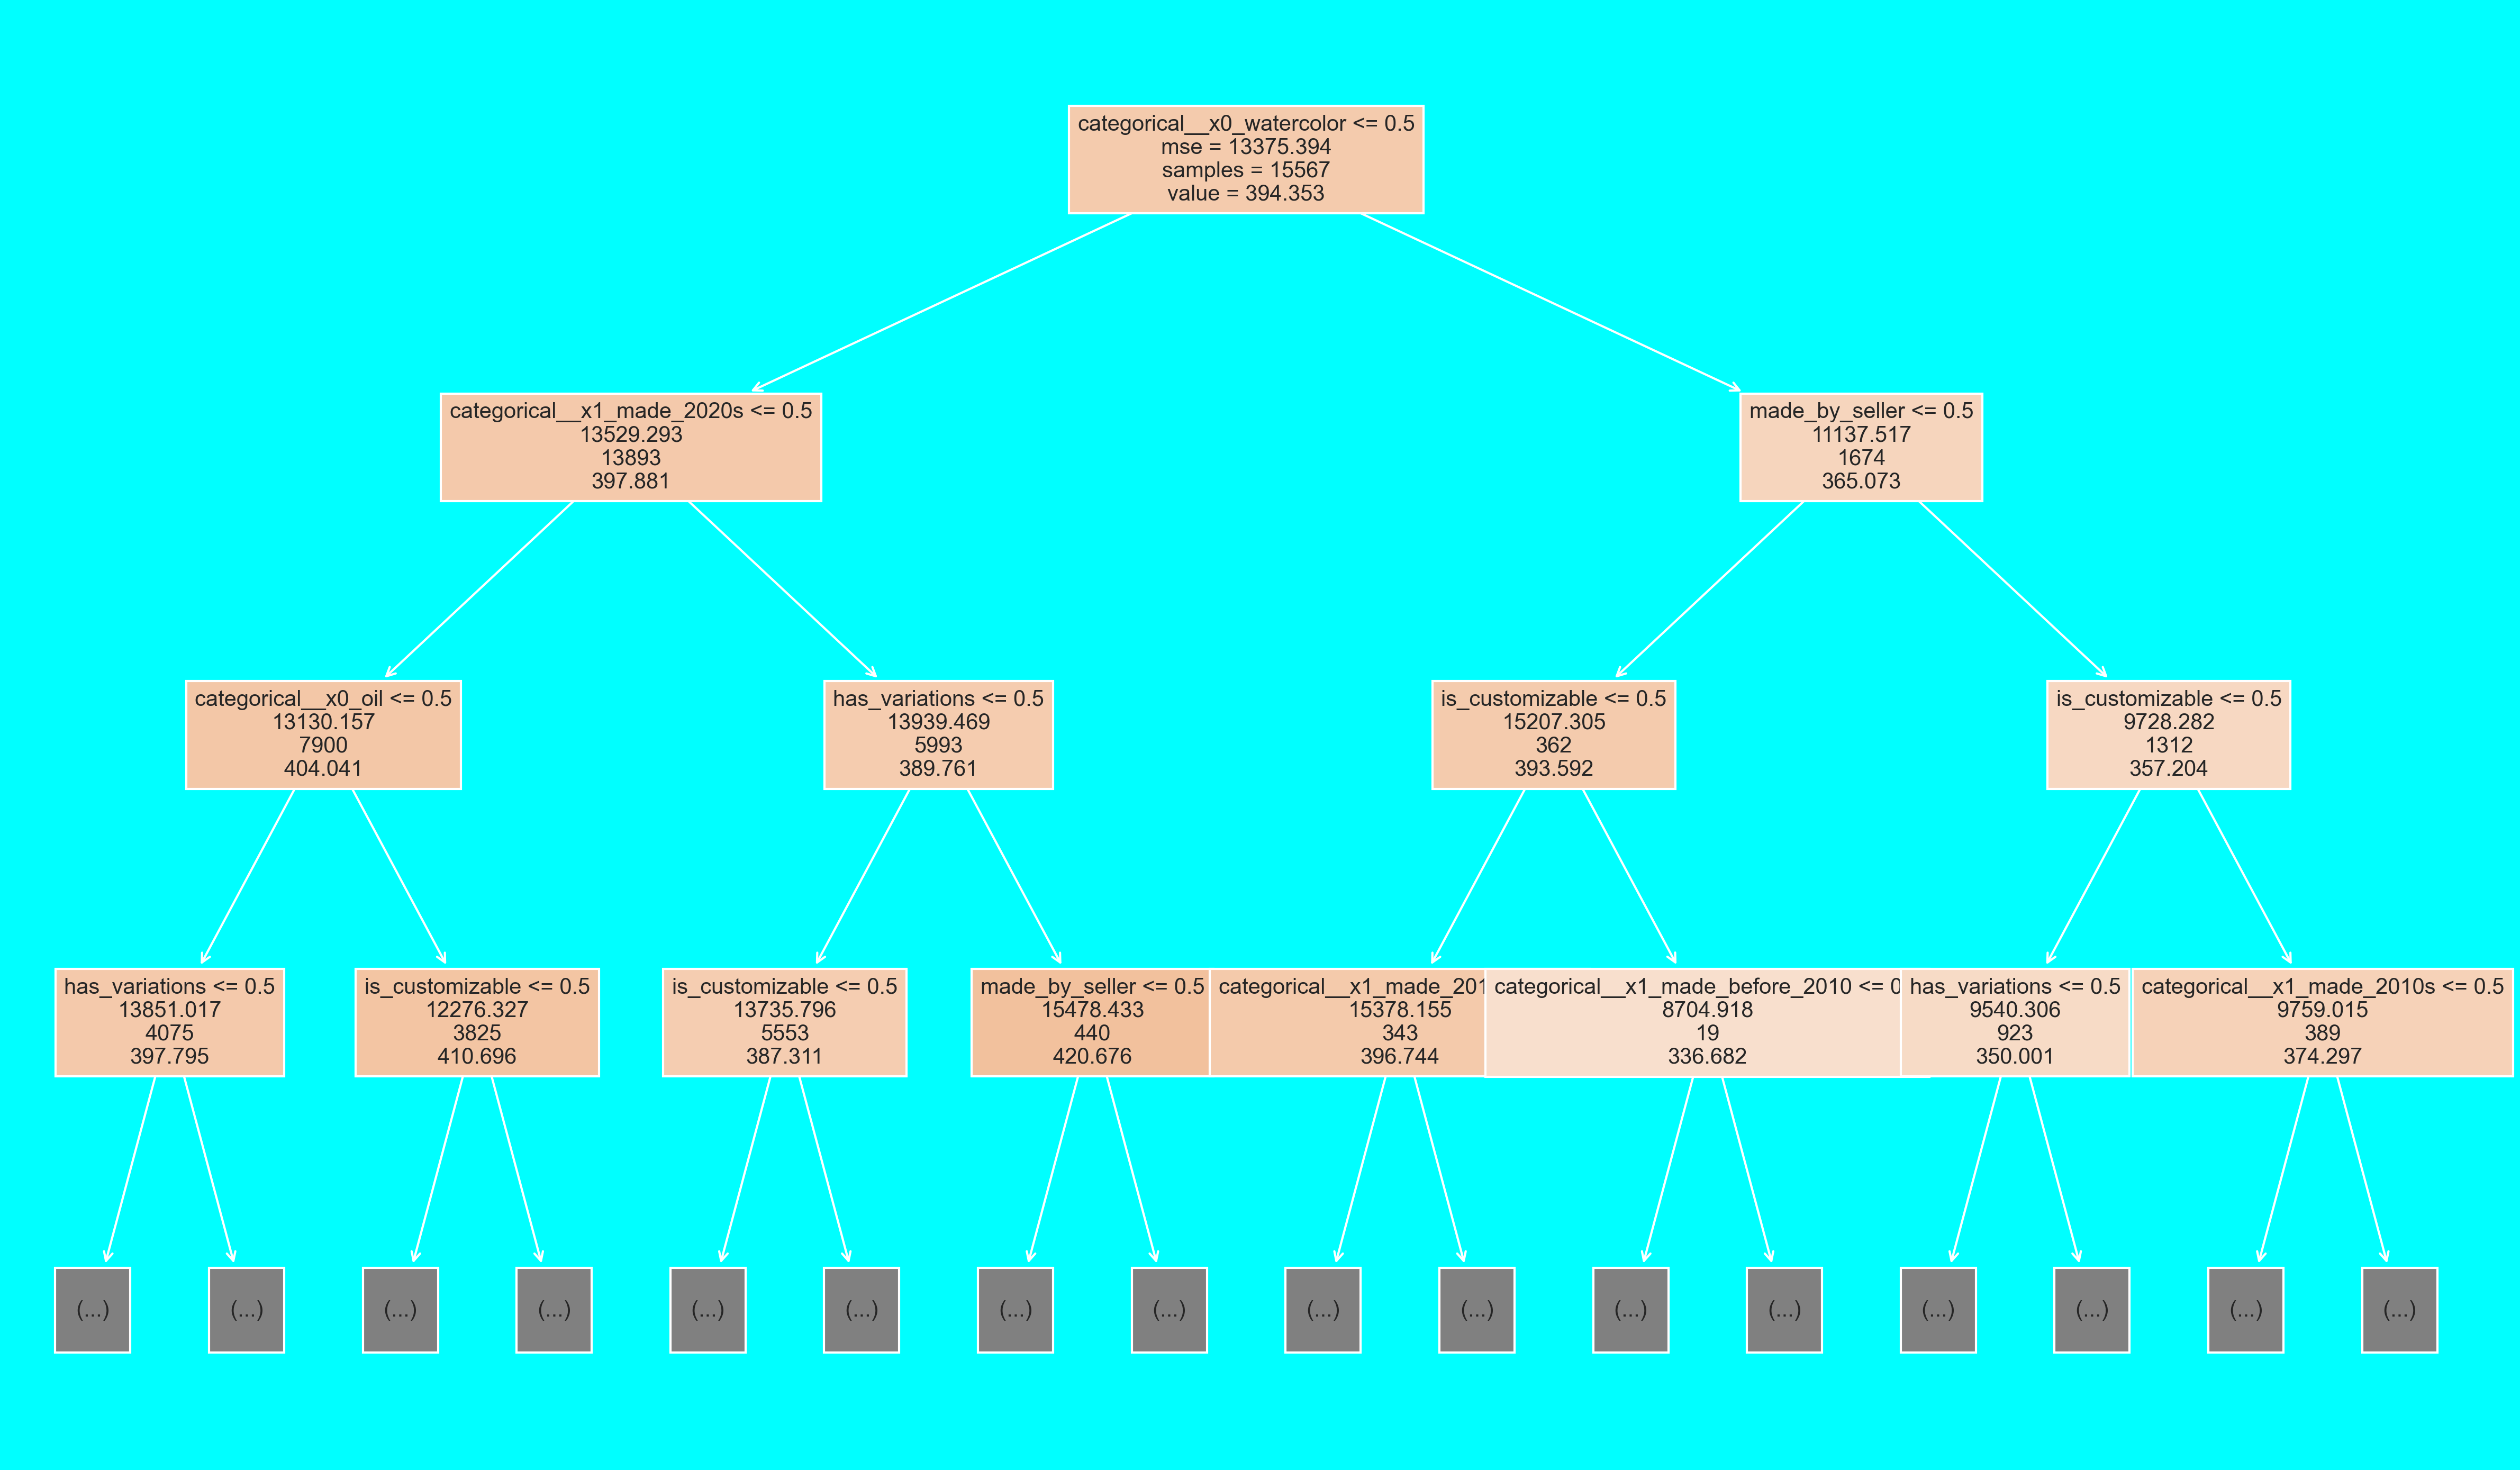

In [158]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(categorical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_categorical_only.png')

# #export_graphviz(categorical_tree_pipe['decision tree'],out_file=None)
# #graphviz.Source(tree.export_graphviz(tree_reg, out_file=None))

#### Model 2d) Random Forest using only categorical features

In [159]:
from sklearn.ensemble import RandomForestRegressor

In [160]:
categorical_rforest_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [161]:
categorical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [162]:
#Predict prices on training set:
prices_train_pred = categorical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_train,prices_train)

0.038308221865903436

In [163]:
#Predict prices on test set:
prices_test_pred = categorical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_test,prices_test)

0.03747304577470867

In [164]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only categorical features')


Random Forest model using only categorical features:
Training R^2: 0.038308221865903436
Testing R^2: 0.03747304577470867
Training RMSE: USD 113.4151957176367
Testing RMSE: USD 113.3193481781654
Training MAE: USD 96.0780300623602
Testing MAE: USD 96.14941632195831


In [165]:
#what are the main features used for decision?
categorical_rforest_pipe['rforest'].feature_importances_

array([0.06365796, 0.0571211 , 0.09975706, 0.15106417, 0.05051517,
       0.07951721, 0.03072564, 0.02979286, 0.14717385, 0.1636893 ,
       0.12698568])

In [166]:
feature_names_cat_rforest = categorical_rforest_pipe['categorical selector'].get_feature_names()

categorical_rforest_features_imp_df = pd.DataFrame(categorical_rforest_pipe['rforest'].feature_importances_,feature_names_cat_rforest,columns=['Rforest feature importance'])
categorical_rforest_features_imp_df = categorical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
categorical_rforest_features_imp_df

Rforest feature importance
is_customizable                                     0.163689
categorical__x0_watercolor                          0.151064
made_by_seller                                      0.147174
has_variations                                      0.126986
categorical__x0_oil                                 0.099757
categorical__x1_made_2020s                          0.079517
categorical__x0_acrylic                             0.063658
categorical__x0_more_than_one                       0.057121
categorical__x1_made_2010s                          0.050515
categorical__x1_made_before_2010                    0.030726
categorical__x1_made_to_order                       0.029793

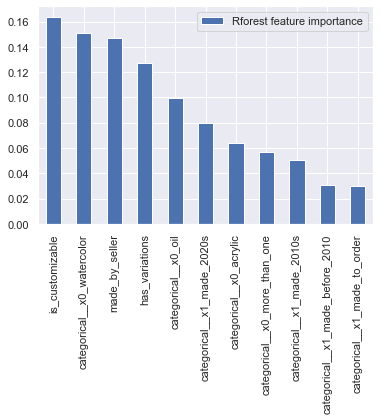

In [167]:
categorical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 2e) Gradient Boosting Trees using only numerical features¶

In [168]:
from sklearn.ensemble import GradientBoostingRegressor

In [169]:
categorical_gboost_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [170]:
categorical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=6, n_estimators=50,
                                           random_state=1, subsample=0.5))])

In [171]:
#Predict prices on training set:
prices_train_pred = categorical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_train,prices_train)

0.0383581131419658

In [172]:
#Predict prices on test set:
prices_test_pred = categorical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_test,prices_test)

0.03524975736858005

In [173]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only categorical features')


Gradient Boosting model using only categorical features:
Training R^2: 0.0383581131419658
Testing R^2: 0.03524975736858005
Training RMSE: USD 113.41225376556967
Testing RMSE: USD 113.45014777455265
Training MAE: USD 96.04119225455142
Testing MAE: USD 96.2133430579684


In [174]:
#what are the main features used for decision?
categorical_gboost_pipe['gboost'].feature_importances_

array([0.08473586, 0.09425396, 0.13618902, 0.12096009, 0.07076686,
       0.0675269 , 0.15783319, 0.11799427, 0.14973986])

In [175]:
feature_names_cat_gboost = categorical_gboost_pipe['categorical selector'].get_feature_names()

categorical_gboost_features_imp_df = pd.DataFrame(categorical_gboost_pipe['gboost'].feature_importances_,feature_names_cat_gboost,columns=['Gboost feature importance'])
categorical_gboost_features_imp_df = categorical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
categorical_gboost_features_imp_df

Gboost feature importance
made_by_seller                                     0.157833
has_variations                                     0.149740
categorical__x0_watercolor                         0.136189
categorical__x1_made_2020s                         0.120960
is_customizable                                    0.117994
categorical__x0_oil                                0.094254
categorical__x0_more_than_one                      0.084736
categorical__x1_made_before_2010                   0.070767
categorical__x1_made_to_order                      0.067527

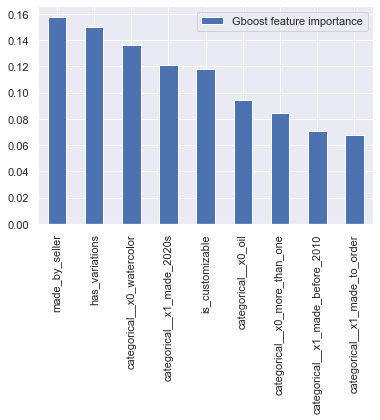

In [176]:
categorical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 3) Models combining numerical and categorical features, but still no image information or style tags info

#### 3a) Linear regression combining numerical and categorical features

In [177]:
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
#Also recall that for Linear Regression I need to drop the first hot-encoded value or I will have multicollinearity problems
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

variable_selector = ColumnTransformer([
    ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns)
 ], remainder='drop')



In [178]:
preprocessed_variables = variable_selector.fit_transform(paintings_df_train)
preprocessed_variables

array([[0.        , 1.        , 0.        , ..., 0.02889755, 0.12425427,
        0.0057971 ],
       [0.        , 1.        , 0.        , ..., 0.02889755, 0.08743057,
        0.16521739],
       [0.        , 0.        , 0.        , ..., 0.02889755, 0.18041555,
        0.03478261],
       ...,
       [0.        , 0.        , 0.        , ..., 0.07237974, 0.56181856,
        0.0115942 ],
       [0.        , 0.        , 0.        , ..., 0.02889755, 0.17588973,
        0.22608696],
       [0.        , 0.        , 0.        , ..., 0.10136788, 0.31001851,
        0.09565217]])

In [179]:
#confirm all variables are between 0 and 1:
np.max(preprocessed_variables,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [180]:
np.min(preprocessed_variables,axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [181]:
#variable_selector.get_feature_names()
#variable_selector.output_indices_

In [182]:
variable_selector

ColumnTransformer(transformers=[('categorical', OneHotEncoder(drop='first'),
                                 ['painting_type', 'when_made']),
                                ('boolean', 'passthrough',
                                 ['made_by_seller', 'is_customizable',
                                  'has_variations']),
                                ('numerical', MinMaxScaler(),
                                 ['num_favorers', 'featured_rank',
                                  'max_dimension', 'aspect_ratio', 'area',
                                  'weight', 'days_from_original_creation',
                                  'days_from_last_modification'])])

In [183]:
#and then apply LinearRegression within a pipeline
from sklearn.pipeline import Pipeline

num_plus_cat_linreg_pipe = Pipeline([
    ('variable selector', variable_selector),
    ('linear reg', LinearRegression()),
])

In [184]:
#Train the model
num_plus_cat_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('variable selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('linear reg', LinearRegression())])

In [185]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_train,prices_train)

0.07920164003347108

In [186]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_test,prices_test)

0.09499891560248275

In [187]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using numerical features and categorical features with One-hot-encoding')


Linear regression model using numerical features and categorical features with One-hot-encoding:
Training R^2: 0.07920164003347108
Testing R^2: 0.09499891560248275
Training RMSE: USD 110.97766005820172
Testing RMSE: USD 109.8808897631926
Training MAE: USD 93.56759449260517
Testing MAE: USD 92.67704526026384


In [188]:
#Let's look at the coefficients of the model
# intercept
print(num_plus_cat_linreg_pipe['linear reg'].intercept_)

341.7139754187123


In [189]:
num_plus_cat_linreg_pipe['linear reg'].coef_

array([-6.22572415e+00,  2.09469545e+01, -5.47804467e+00, -1.52691271e+01,
       -8.29136280e+00, -1.64735485e+01,  5.81129907e+00, -1.43987923e-01,
        6.14221721e+00,  1.05620560e+02,  5.20586313e+01,  1.76228553e+01,
        2.27991825e+02,  2.97464482e+02,  1.16214054e+02, -2.02596115e+01,
        7.17042222e+00])

In [190]:
#coefficients for each variable:
coeff_df = pd.DataFrame(num_plus_cat_linreg_pipe['linear reg'].coef_,columns=['Lin Reg Coeff']) #categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
0       -6.225724
1       20.946954
2       -5.478045
3      -15.269127
4       -8.291363
5      -16.473549
6        5.811299
7       -0.143988
8        6.142217
9      105.620560
10      52.058631
11      17.622855
12     227.991825
13     297.464482
14     116.214054
15     -20.259611
16       7.170422

#### 3b) Ridge regression combining numerical and categorical features with polynomial features

In [191]:
#For Ridge Regression, I don't really need to 'drop-first' categorical variables when doing OneHotEncoding, because the ridge term already prevents the problem from being ill-posed  
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

variable_selector_for_ridge = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns)
 ], remainder='drop')

In [192]:
from sklearn.linear_model import Ridge

num_plus_cat_polyreg_ridge_pipe = Pipeline([('num and cat preproc', variable_selector_for_ridge),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [193]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
num_plus_cat_polyreg_ridge_CVmodel = GridSearchCV(num_plus_cat_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [194]:
#Train the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_polyreg_ridge_CVmodel_filename = './Git_exclude/models/num_plus_cat_polyreg_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'rb') as f:
        num_plus_cat_polyreg_ridge_CVmodel = load(f)
        print('Loaded joblib file with numerical-plus-categorical features, ridge regression with polynomial features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_polyreg_ridge_CVmodel, num_plus_cat_polyreg_ridge_CVmodel_filename) 
        print('Saved joblib file with numerical-plus-categorical features, ridge regression with polynomial features.')


Loaded joblib file with numerical-plus-categorical features, ridge regression with polynomial features.


In [195]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.15872958364840328

In [196]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.15626894915230982

In [197]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression using numerical and categorical features with polynomial features')


Ridge regression using numerical and categorical features with polynomial features:
Training R^2: 0.15872958364840328
Testing R^2: 0.15626894915230982
Training RMSE: USD 106.07696940053594
Testing RMSE: USD 106.09615225142689
Training MAE: USD 87.60288125730291
Testing MAE: USD 87.75837286914967


### Model 3c) Decision Tree model combining numerical and categorical features

In [198]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [199]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
#and I don't need to scale the numerical variables

variable_selector_for_trees = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical','passthrough',numerical_columns)
 ], remainder='drop')

In [200]:
num_plus_cat_dtree_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [201]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
num_plus_cat_dtree_CVmodel = GridSearchCV(num_plus_cat_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [202]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_dtree_CVmodel_filename = './Git_exclude/models/num_plus_cat_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_dtree_CVmodel_filename, 'rb') as f:
        num_plus_cat_dtree_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for numerical-plus-categorical features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_dtree_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_dtree_CVmodel, num_plus_cat_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for numerical-plus-categorical features.')

Loaded joblib file with decision tree model for numerical-plus-categorical features.


In [203]:
num_plus_cat_dtree_CVmodel.best_params_

{'dtree__max_depth': 7}

In [204]:
num_plus_cat_dtree_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('num and cat selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations']),
                                                                        ('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation',
                                                                          'days_from_last_modification'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [205]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_train,prices_train)

0.18313359948480978

In [206]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_test,prices_test)

0.15460829810972543

In [207]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using numerical + categorical features')


Decision Tree model using numerical + categorical features:
Training R^2: 0.18313359948480978
Testing R^2: 0.15460829810972543
Training RMSE: USD 104.52707833679273
Testing RMSE: USD 106.20051138116409
Training MAE: USD 84.96525881147183
Testing MAE: USD 86.56397847097962


In [208]:
#what are the main features used for decision?
num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.00282664, 0.        , 0.05079082, 0.        , 0.01019893,
       0.02306043, 0.00147569, 0.00492021, 0.04871086, 0.003343  ,
       0.00450674, 0.0144615 , 0.02000393, 0.39700422, 0.0211579 ,
       0.15302669, 0.14886553, 0.06289872, 0.03274819])

In [209]:
feature_names_num_plus_cat_dtree = num_plus_cat_dtree_CVmodel.best_estimator_['num and cat selector'].get_feature_names()

num_plus_cat_dtree_features_imp_df = pd.DataFrame(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_plus_cat_dtree,columns=['Dtree feature importance'])
num_plus_cat_dtree_features_imp_df = num_plus_cat_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
num_plus_cat_dtree_features_imp_df

Dtree feature importance
max_dimension                                     0.397004
area                                              0.153027
weight                                            0.148866
days_from_original_creation                       0.062899
categorical__x0_oil                               0.050791
made_by_seller                                    0.048711
days_from_last_modification                       0.032748
categorical__x1_made_2020s                        0.023060
aspect_ratio                                      0.021158
featured_rank                                     0.020004
num_favorers                                      0.014461
categorical__x1_made_2010s                        0.010199
categorical__x1_made_to_order                     0.004920
has_variations                                    0.004507
is_customizable                                   0.003343
categorical__x0_acrylic                           0.002827
categorical__x1_made_before_2010                  0.001476
categorical__x0_more_than_one                     0.000000
categorical__x0_watercolor                        0.000000

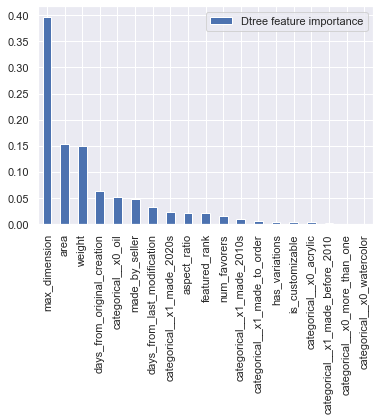

In [210]:
num_plus_cat_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

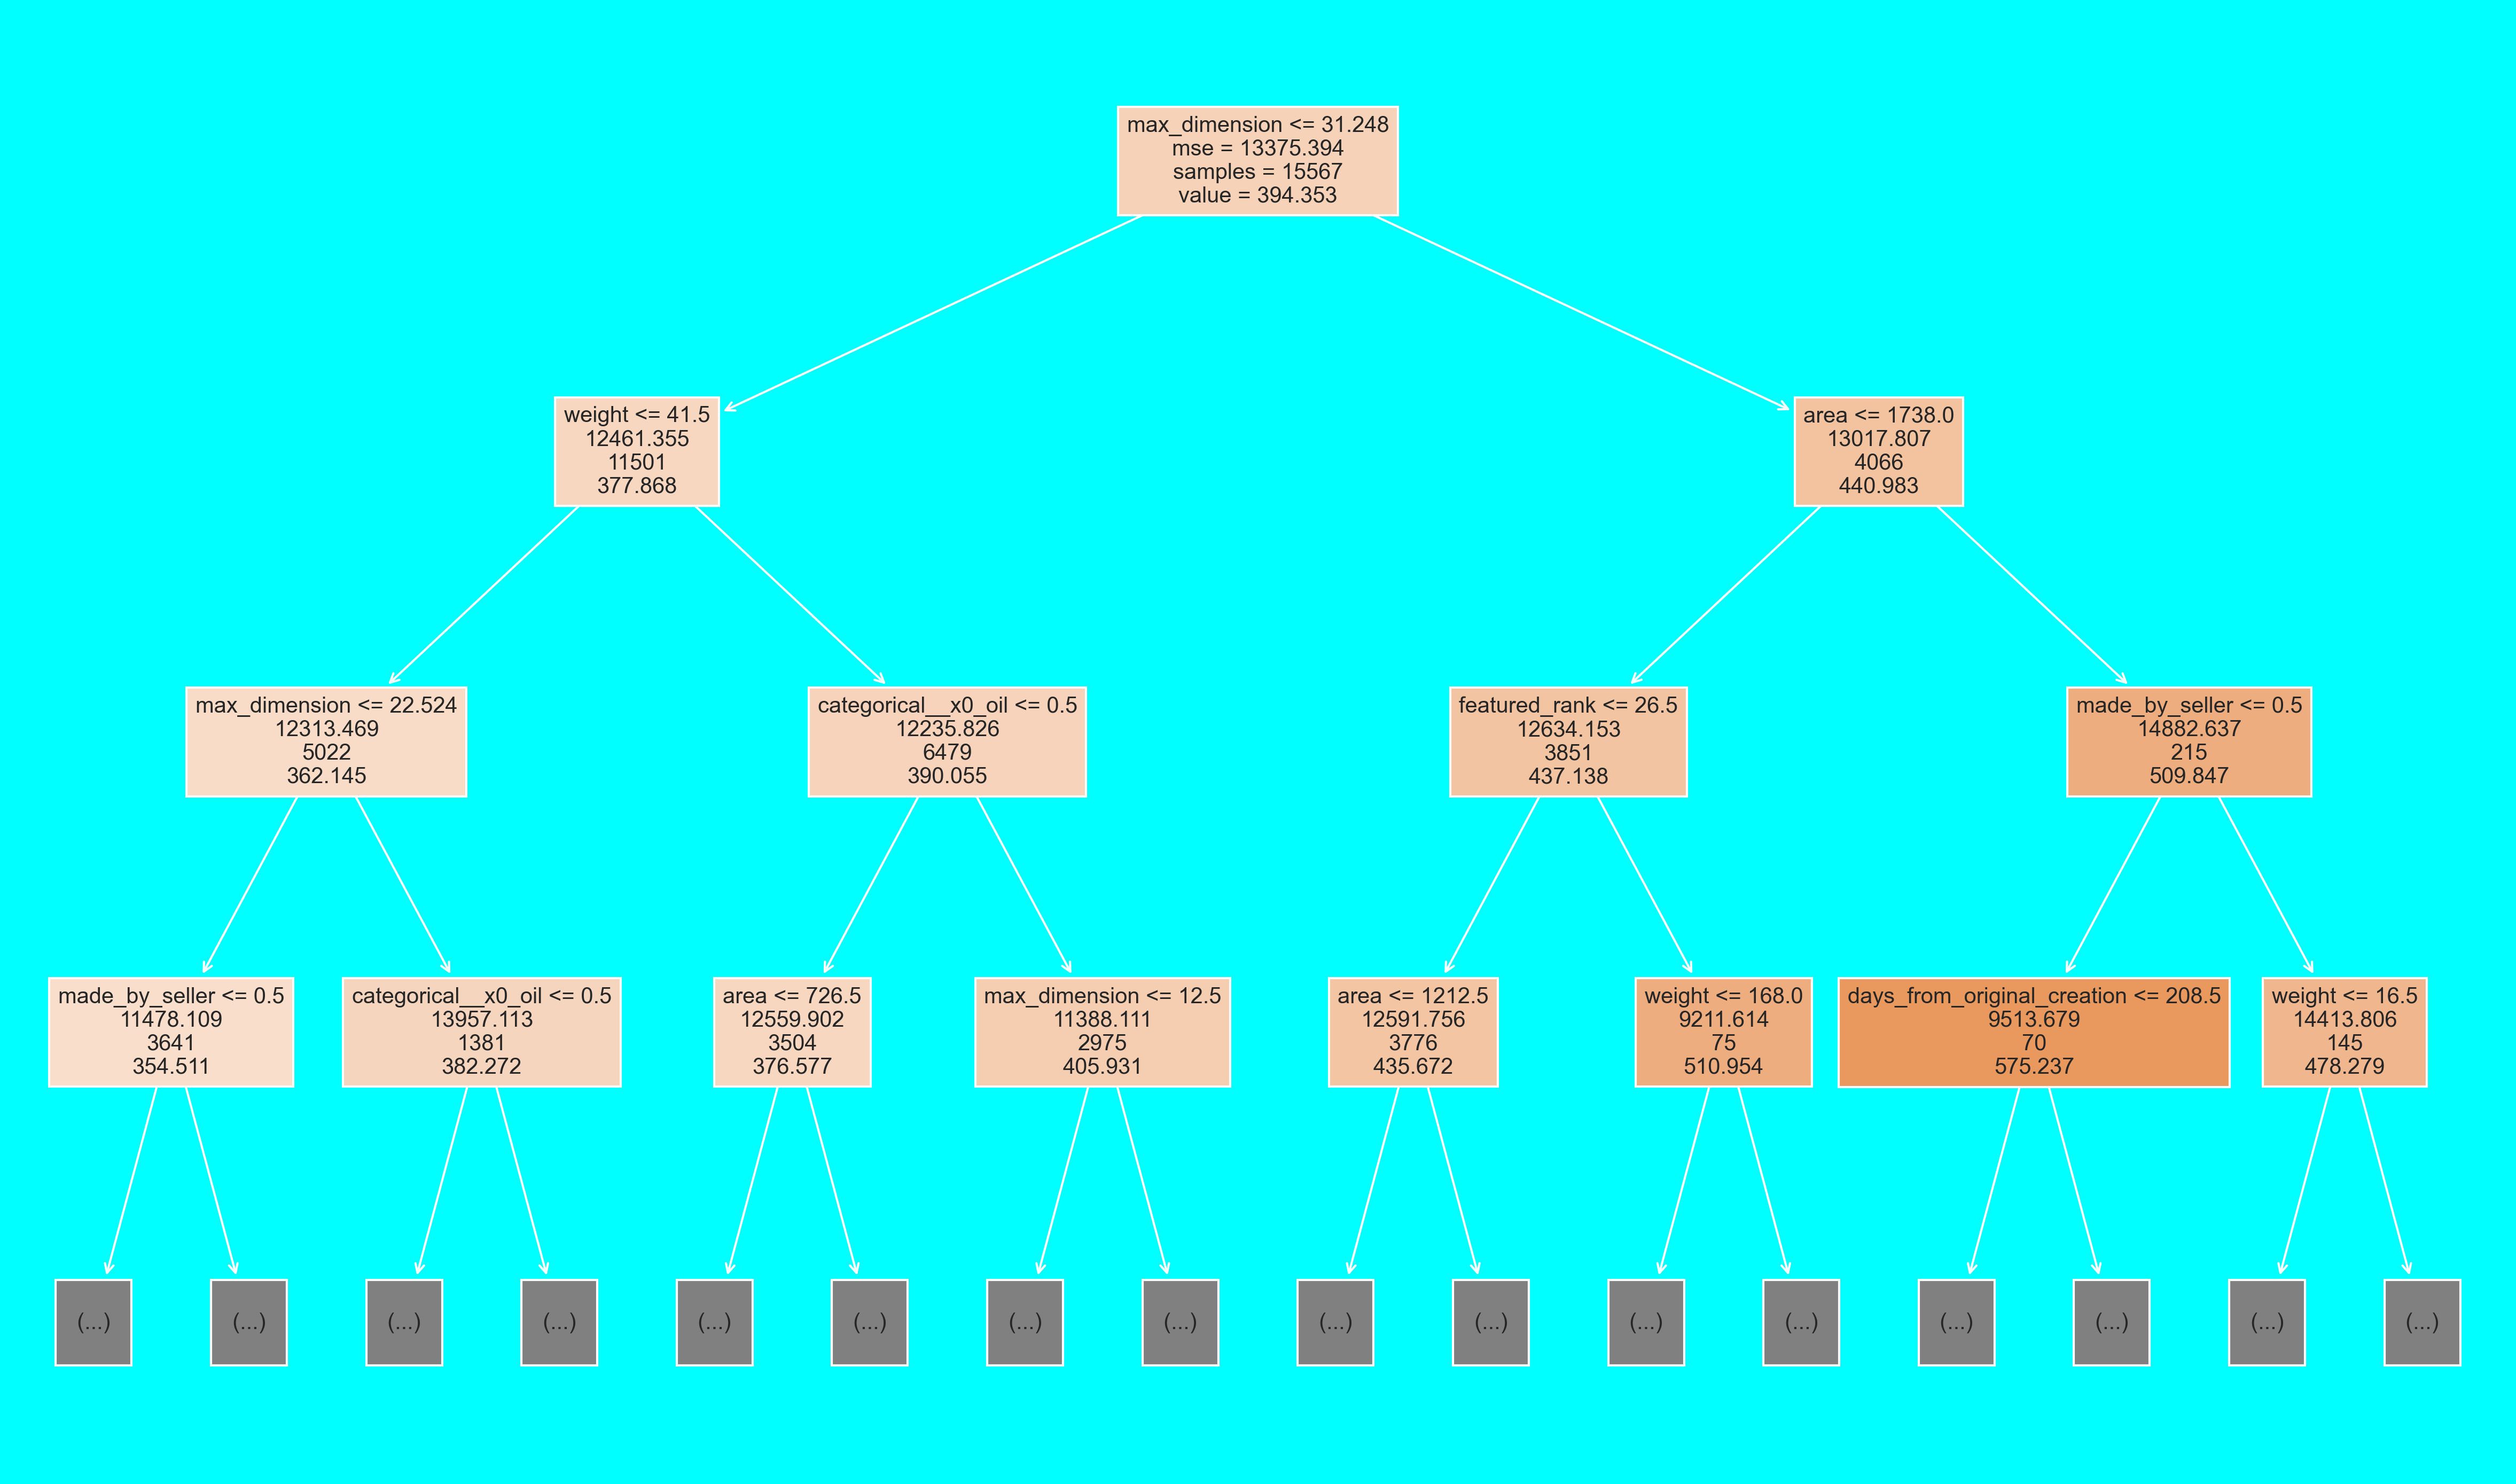

In [211]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_num_plus_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_plus_categorical.png')

# #export_graphviz(categorical_tree_pipe['decision tree'],out_file=None)
# #graphviz.Source(tree.export_graphviz(tree_reg, out_file=None))

#### Model 3d) Random Forest combining numerical and categorical features

In [212]:
from sklearn.ensemble import RandomForestRegressor

In [213]:
num_plus_cat_rforest_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [214]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_rforest_pipe_filename = './Git_exclude/models/num_plus_cat_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_rforest_pipe_filename, 'rb') as f:
        num_plus_cat_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for numerical-plus-categorical features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_rforest_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_rforest_pipe_filename, 'wb') as f:
        dump(num_plus_cat_rforest_pipe, num_plus_cat_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for numerical-plus-categorical features.')

Loaded joblib file with random forest model for numerical-plus-categorical features.


In [215]:
num_plus_cat_rforest_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [216]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_train,prices_train)

0.22740261699457864

In [217]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_test,prices_test)

0.19740127984384515

In [218]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using numerical + categorical features')


Random Forest model using numerical + categorical features:
Training R^2: 0.22740261699457864
Testing R^2: 0.19740127984384515
Training RMSE: USD 101.65527308569912
Testing RMSE: USD 103.47771954394683
Training MAE: USD 83.91016642257489
Testing MAE: USD 85.6301295003132


In [219]:
#what are the main features used for decision?
num_plus_cat_rforest_pipe['rforest'].feature_importances_

array([0.01253024, 0.00551819, 0.0318036 , 0.01251242, 0.01507278,
       0.01590001, 0.01193429, 0.00516477, 0.01823589, 0.01134556,
       0.01521422, 0.03552467, 0.01895153, 0.1990323 , 0.08623826,
       0.23166927, 0.13299607, 0.07947179, 0.06088414])

In [220]:
feature_names_num_plus_cat_rforest = num_plus_cat_rforest_pipe['num and cat selector'].get_feature_names()

num_plus_cat_rforest_features_imp_df = pd.DataFrame(num_plus_cat_rforest_pipe['rforest'].feature_importances_,feature_names_num_plus_cat_rforest,columns=['Rforest feature importance'])
num_plus_cat_rforest_features_imp_df = num_plus_cat_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
num_plus_cat_rforest_features_imp_df

Rforest feature importance
area                                                0.231669
max_dimension                                       0.199032
weight                                              0.132996
aspect_ratio                                        0.086238
days_from_original_creation                         0.079472
days_from_last_modification                         0.060884
num_favorers                                        0.035525
categorical__x0_oil                                 0.031804
featured_rank                                       0.018952
made_by_seller                                      0.018236
categorical__x1_made_2020s                          0.015900
has_variations                                      0.015214
categorical__x1_made_2010s                          0.015073
categorical__x0_acrylic                             0.012530
categorical__x0_watercolor                          0.012512
categorical__x1_made_before_2010                    0.011934
is_customizable                                     0.011346
categorical__x0_more_than_one                       0.005518
categorical__x1_made_to_order                       0.005165

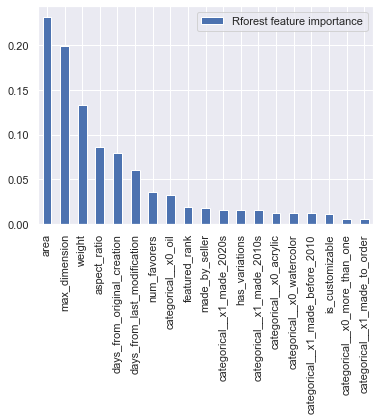

In [221]:
num_plus_cat_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 3e) Gradient Boosting Trees combining numerical and categorical features

In [222]:
from sklearn.ensemble import GradientBoostingRegressor

In [223]:
num_plus_cat_gboost_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    #('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.75,max_depth=3,random_state=1))
    ('gboost', GradientBoostingRegressor(n_estimators=80,learning_rate=0.1,subsample=0.75,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
    #('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [224]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_gboost_pipe_filename = './Git_exclude/models/num_plus_cat_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_gboost_pipe_filename, 'rb') as f:
        num_plus_cat_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for numerical-plus-categorical features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_gboost_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_gboost_pipe_filename, 'wb') as f:
        dump(num_plus_cat_gboost_pipe, num_plus_cat_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting model for numerical-plus-categorical features.')

Loaded joblib file with gradient boosting model for numerical-plus-categorical features.


In [225]:
num_plus_cat_gboost_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=4, n_estimators=80,
                                           random_state=1, subsample=0.75))])

In [226]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_train,prices_train)

0.21853069043463902

In [227]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_test,prices_test)

0.19588634722632747

In [228]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using numerical plus categorical features')


Gradient Boosting model using numerical plus categorical features:
Training R^2: 0.21853069043463902
Testing R^2: 0.19588634722632747
Training RMSE: USD 102.2372733452536
Testing RMSE: USD 103.57533237649564
Training MAE: USD 84.18704967590178
Testing MAE: USD 85.48800381260202


In [229]:
#what are the main features used for decision?
num_plus_cat_gboost_pipe['gboost'].feature_importances_

array([0.002253  , 0.00525118, 0.04871988, 0.0020959 , 0.01522949,
       0.00758489, 0.00688238, 0.00477778, 0.03651236, 0.01163264,
       0.01501816, 0.02355479, 0.01749566, 0.30676744, 0.0590663 ,
       0.1284971 , 0.1347326 , 0.10173462, 0.07219381])

In [230]:
feature_names_num_plus_cat_gboost = num_plus_cat_gboost_pipe['num and cat selector'].get_feature_names()

num_plus_cat_gboost_features_imp_df = pd.DataFrame(num_plus_cat_gboost_pipe['gboost'].feature_importances_,feature_names_num_plus_cat_gboost,columns=['Gboost feature importance'])
num_plus_cat_gboost_features_imp_df = num_plus_cat_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
num_plus_cat_gboost_features_imp_df

Gboost feature importance
max_dimension                                      0.306767
weight                                             0.134733
area                                               0.128497
days_from_original_creation                        0.101735
days_from_last_modification                        0.072194
aspect_ratio                                       0.059066
categorical__x0_oil                                0.048720
made_by_seller                                     0.036512
num_favorers                                       0.023555
featured_rank                                      0.017496
categorical__x1_made_2010s                         0.015229
has_variations                                     0.015018
is_customizable                                    0.011633
categorical__x1_made_2020s                         0.007585
categorical__x1_made_before_2010                   0.006882
categorical__x0_more_than_one                      0.005251
categorical__x1_made_to_order                      0.004778
categorical__x0_acrylic                            0.002253
categorical__x0_watercolor                         0.002096

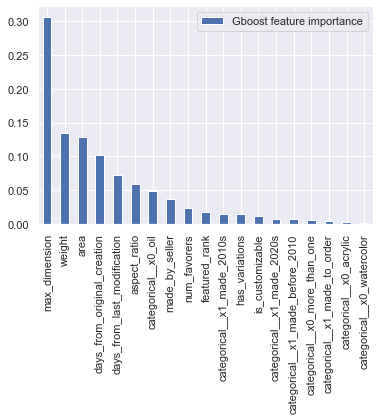

In [231]:
num_plus_cat_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 4) Models also using the mean colors in the painting as provided by Etsy (which may or may not be accurate)

### Model 4a) Linear regression using only mean image features

In [232]:
image_mean_selector = ColumnTransformer([
    ('image_mean', 'passthrough', image_columns),
], remainder='drop')

In [233]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

image_mean_preproc_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('minmax scaling', MinMaxScaler()),
])

In [234]:
from sklearn.linear_model import LinearRegression

meanimage_linreg_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [235]:
#Train the model
meanimage_linreg_pipe.fit(paintings_df_train,prices_train);

In [236]:
#Predict prices on training set:
prices_train_pred = meanimage_linreg_pipe.predict(paintings_df_train)

In [237]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_train,prices_train)

0.001928421065628072

In [238]:
#Predict prices on test set:
prices_test_pred = meanimage_linreg_pipe.predict(paintings_df_test)

In [239]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_test,prices_test)

-0.002898599914475275

In [240]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only mean image info')

Linear regression model using only mean image info:
Training R^2: 0.001928421065628072
Testing R^2: -0.002898599914475275
Training RMSE: USD 115.54047254467004
Testing RMSE: USD 115.67143680855257
Training MAE: USD 98.67095082579894
Testing MAE: USD 98.95511700695512


### Model 4b) Polynomial regression using only mean image features

In [241]:
from sklearn.linear_model import Ridge

meanimage_polyreg_ridge_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [242]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
meanimage_polyreg_ridge_CVmodel = GridSearchCV(meanimage_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [243]:
#Train the model
meanimage_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   16.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('image mean preproc',
                                        Pipeline(steps=[('image mean selector',
                                                         ColumnTransformer(transformers=[('image_mean',
                                                                                          'passthrough',
                                                                                          ['image_red',
                                                                                           'image_green',
                                                                                           'image_blue',
                                                                                           'image_hue',
                                                                                           'image_saturation',
                                                                                           'image_brightness'])])),
                                                        ('minmax scaling',
                                                         MinMaxScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatures(degree=3,
                                                           include_bi...
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [244]:
meanimage_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [245]:
#Predict prices on training set:
prices_train_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_train)

In [246]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.003812846400373715

In [247]:
#Predict prices on test set:
prices_test_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_test)

In [248]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

-0.0008211807788558456

In [249]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial ridge regression model using only mean image info')

Polynomial ridge regression model using only mean image info:
Training R^2: 0.003812846400373715
Testing R^2: -0.0008211807788558456
Training RMSE: USD 115.43134697375764
Testing RMSE: USD 115.55157293368704
Training MAE: USD 98.54669933465834
Testing MAE: USD 98.81018140580922


In [250]:
#So it doesn't look like the mean image colors - as provided by Etsy at least - are very useful at all - but let's also try with tree-based models to see if things change

### Model 4c) Decision tree model using only mean image features

In [251]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [252]:
# #Recall that I already have the image mean selector, which need not change:
# image_mean_selector = ColumnTransformer([
#     ('image_mean', 'passthrough', image_columns),
# ], remainder='drop')

In [253]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

meanimage_dtree_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [254]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
meanimage_dtree_CVmodel = GridSearchCV(meanimage_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [255]:
meanimage_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    5.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('image mean selector',
                                        ColumnTransformer(transformers=[('image_mean',
                                                                         'passthrough',
                                                                         ['image_red',
                                                                          'image_green',
                                                                          'image_blue',
                                                                          'image_hue',
                                                                          'image_saturation',
                                                                          'image_brightness'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [256]:
meanimage_dtree_CVmodel.best_params_['dtree__max_depth']

2

In [257]:
#Predict prices on training set:
prices_train_pred = meanimage_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_train,prices_train)

0.002860441324474272

In [258]:
#Predict prices on test set:
prices_test_pred = meanimage_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_test,prices_test)

-8.715612748999568e-05

In [259]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only mean image features (provided by Etsy)')


Decision Tree model using only mean image features (provided by Etsy):
Training R^2: 0.002860441324474272
Testing R^2: -8.715612748999568e-05
Training RMSE: USD 115.48651288134302
Testing RMSE: USD 115.50919110655713
Training MAE: USD 98.62087469333322
Testing MAE: USD 98.76552929212325


In [260]:
#it seems that the mean image (at least as provided by Etsy) has basically no predictive power, so there's no need to continue investigating this or to also try random forests
meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.        , 0.        , 0.22005025, 0.2496953 , 0.        ,
       0.53025444])

In [261]:
feature_names_meanimage_dtree = meanimage_dtree_CVmodel.best_estimator_['image mean selector'].get_feature_names()

meanimage_dtree_features_imp_df = pd.DataFrame(meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_meanimage_dtree,columns=['Dtree feature importance'])
meanimage_dtree_features_imp_df = meanimage_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
meanimage_dtree_features_imp_df

Dtree feature importance
image_brightness                  0.530254
image_hue                         0.249695
image_blue                        0.220050
image_red                         0.000000
image_green                       0.000000
image_saturation                  0.000000

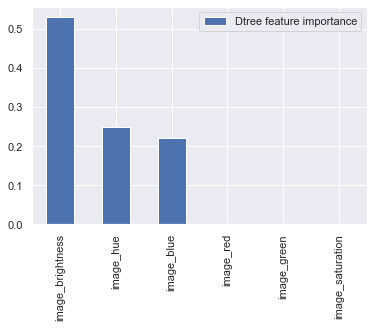

In [262]:
meanimage_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 5) Models using only the 'style' tags

In [263]:
#Here I can't just use OneHotEncoding, because because there can be multiple tags for the same listing, i.e. the 'new_style_tags' for a painting could be a list like: ['Abstract','Contemporary','Modern']

In [264]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].iloc[1]

"['abstract', 'landscape']"

In [265]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].value_counts()

['abstract']                                                     1967
['landscape']                                                    1413
['contemporary art']                                             1071
['portrait']                                                      732
['abstract', 'modern']                                            585
                                                                 ... 
['beach', 'traditional', 'landscape']                               1
['floral', 'seascape']                                              1
['impressionist', 'impressionism', 'pop art', 'contemporary']       1
['wildlife', 'country western']                                     1
['impressionist', 'impressionism', 'industrial']                    1
Name: style_tags_new, Length: 2327, dtype: int64

In [266]:
#I can use the 'DictVectorizer' provided by scikit-learn. 
#This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value 
#associated with it. Missing keys are filled with zeros. However, before I can use 'DictVectorizer' I need to convert my list of strings into array of dictionaries.
#I do that with a 'DictEncoder' defined as follows:

In [267]:
def stringlist_to_dict(stringlist):
    dict = {}
    for string in stringlist:
        dict[string]=1
    return dict

In [268]:
from sklearn.base import BaseEstimator, TransformerMixin
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
        return X.apply(eval).apply(stringlist_to_dict)

In [269]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].apply(eval).apply(stringlist_to_dict)

0                                           {'vintage': 1}
1                          {'abstract': 1, 'landscape': 1}
2                       {'streetscape': 1, 'landscape': 1}
3        {'southwestern': 1, 'cityscape': 1, 'landscape...
4                                 {'modern': 1, 'folk': 1}
                               ...                        
19454                   {'abstract': 1, 'contemporary': 1}
19455                               {'impressionistic': 1}
19456                                     {'landscape': 1}
19457                       {'art deco': 1, 'abstract': 1}
19458                   {'expressionism': 1, 'vintage': 1}
Name: style_tags_new, Length: 19459, dtype: object

In [270]:
from sklearn.feature_extraction import DictVectorizer

pipe_style_tags_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [271]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tranform = ColumnTransformer([
    ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [272]:
#Let's test this in isolation
style_tranform.fit_transform(paintings_df_train)

<15567x146 sparse matrix of type '<class 'numpy.float64'>'
	with 29378 stored elements in Compressed Sparse Row format>

### 5a) Ridge regression of style tags only, after vectorization

Since there are a large number of features, one for each category, cross validation is critical to prevent overfitting.

In [273]:
from sklearn.linear_model import Ridge

stlye_ridge_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('ridge',Ridge(alpha=10))
])

In [274]:
#Let's see if the pipeline works (i.e. can be fit successfully)
stlye_ridge_pipe.fit(paintings_df_train,prices_train)


Pipeline(steps=[('style tags vectorization',
                 ColumnTransformer(transformers=[('style tags vectorizer',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictEncoder()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'style_tags_new')])),
                ('ridge', Ridge(alpha=10))])

In [275]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_CVmodel = GridSearchCV(stlye_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [276]:
#Train the model
style_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   22.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [277]:
style_ridge_CVmodel.best_params_

{'ridge__alpha': 18.329807108324356}

In [278]:
#Predict prices on training set:
prices_train_pred = style_ridge_CVmodel.predict(paintings_df_train)

In [279]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_train,prices_train)

0.0408812466215982

In [280]:
#Predict prices on test set:
prices_test_pred = style_ridge_CVmodel.predict(paintings_df_test)

In [281]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_test,prices_test)

0.038452433829408106

In [282]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using the vectorized style tags')

Ridge regression model using the vectorized style tags:
Training R^2: 0.0408812466215982
Testing R^2: 0.038452433829408106
Training RMSE: USD 113.26337183444417
Testing RMSE: USD 113.26168129320132
Training MAE: USD 95.47771592343366
Testing MAE: USD 95.60624147056286


### 5b) Decision tree of style tags only, after vectorization

In [283]:
from sklearn.pipeline import Pipeline

style_dtree_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [284]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} #np.linspace(0,10,1)} 
style_dtree_CVmodel = GridSearchCV(style_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [285]:
style_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:   29.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=15))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 51, 2)},
             verbose=1)

In [286]:
style_dtree_CVmodel.best_params_['dtree__max_depth']

10

In [287]:
#Predict prices on training set:
prices_train_pred = style_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
style_dtree_CVmodel.score(paintings_df_train,prices_train)

0.07165616845568423

In [288]:
#Predict prices on test set:
prices_test_pred = style_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
style_dtree_CVmodel.score(paintings_df_test,prices_test)

0.03537137390108447

In [289]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only style tags')


Decision Tree model using only style tags:
Training R^2: 0.07165616845568423
Testing R^2: 0.03537137390108447
Training RMSE: USD 111.43143492156604
Testing RMSE: USD 113.44299677949296
Training MAE: USD 92.42871229155398
Testing MAE: USD 94.59671505779718


In [290]:
style_dtree_CVmodel.best_estimator_['dtree'].feature_importances_[:10]

array([0.        , 0.07706288, 0.        , 0.        , 0.00189011,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [291]:
feature_names_style_dtree = style_dtree_CVmodel.best_estimator_['style tags vectorization'].named_transformers_['style tags vectorizer']['to binary vectors'].get_feature_names()
feature_names_style_dtree[:10]

['21st century impressionism',
 'abstract',
 'abstract expressionist expressionism',
 'abstract realism',
 'african',
 'american expressionist portrait woman lady mc',
 'american impressionist oil painting landscape',
 'american mcm expressionist oil painting abstr',
 'american realism',
 'american western desert indian art landscape']

In [292]:
feature_names_style_dtree = style_dtree_CVmodel.best_estimator_['style tags vectorization'].named_transformers_['style tags vectorizer']['to binary vectors'].get_feature_names()

style_dtree_features_imp_df = pd.DataFrame(style_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_style_dtree,columns=['Dtree feature importance'])
style_dtree_features_imp_df = style_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_features_imp_df.iloc[:20]

Dtree feature importance
expressionism                     0.096353
impressionism                     0.090113
expressionist                     0.080668
abstract                          0.077063
art deco                          0.059197
pop art                           0.059136
modern                            0.051324
vintage                           0.046021
традиционный                      0.038639
portrait                          0.038013
rocker                            0.033781
contemporary art                  0.033233
contemporary                      0.031396
landscape                         0.028095
plein air                         0.026554
nature inspired                   0.020934
wildlife                          0.019383
nostalgic                         0.016467
realism                           0.014467
impressionist                     0.011983

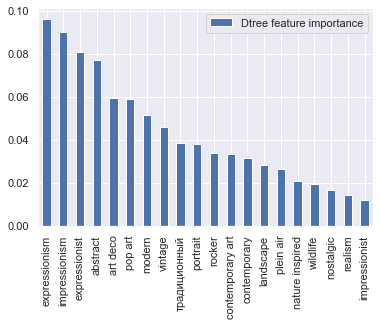

In [293]:
style_dtree_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [294]:
#One problem we can see is that words corresponding to the same style are separated ([expressionism, expressionist],[contemporary, contemporary art]), 
#which is going to muck up the results. I could try to parse tags in a fancy way, but perhaps the best approach is to do dimensionality reduction later (after tf-idf) 

### 5c) Ridge regression of style tags only, after Tf-Idf vectorization 

In [295]:
from sklearn.feature_extraction.text import TfidfTransformer #TfidfVectorizer

In [296]:
from sklearn.linear_model import Ridge

stlye_ridge_w_tfidf_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('tfid', TfidfTransformer()), 
    ('ridge',Ridge(alpha=10))
])

In [297]:
#Let's see if the pipeline works (i.e. can be fit successfully)
stlye_ridge_w_tfidf_pipe.fit(paintings_df_train,prices_train)


Pipeline(steps=[('style tags vectorization',
                 ColumnTransformer(transformers=[('style tags vectorizer',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictEncoder()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'style_tags_new')])),
                ('tfid', TfidfTransformer()), ('ridge', Ridge(alpha=10))])

In [298]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_w_tfidf_CVmodel = GridSearchCV(stlye_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [299]:
#Train the model
style_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   23.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('tfid', TfidfTransformer()),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [300]:
style_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [301]:
#Predict prices on training set:
prices_train_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [302]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.0399729530705244

In [303]:
#Predict prices on test set:
prices_test_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [304]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.03579343449025474

In [305]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf')

Ridge regression model using vectorized style tags with Tf-Idf:
Training R^2: 0.0399729530705244
Testing R^2: 0.03579343449025474
Training RMSE: USD 113.3169898276131
Testing RMSE: USD 113.41817631739755
Training MAE: USD 95.70598265497095
Testing MAE: USD 95.89999444826387


### A different method of implementing Tf-Idf - instead of going through the DictVectorizer - is to use more traditional NLP techniques with TfIdfVectorizer, that enables to also use n-grams (i.e. sequences of words in addition to individual words) 
#### The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'style tags' column as follows (essentially joining the strings in the list)

In [306]:
from sklearn.base import BaseEstimator, TransformerMixin
class TagsEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
        return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [307]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].iloc[1]

"['abstract', 'landscape']"

In [308]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0                                 vintage
1                      abstract landscape
2                   streetscape landscape
3        southwestern cityscape landscape
4                             modern folk
                       ...               
19454               abstract contemporary
19455                     impressionistic
19456                           landscape
19457                   art deco abstract
19458               expressionism vintage
Name: style_tags_new, Length: 19459, dtype: object

In [309]:
#A TfIdfVectorizer should then follow, where I can even try to count n-grams of 2 words

In [310]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_encoding = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
])

In [311]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tags_tranform = ColumnTransformer([
    ('style tags tfidf', pipe_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [312]:
#the above transformation gives a sparse matrix with non-zero elements contained between 0 and 1
style_tags_tranform.fit_transform(paintings_with_style_tags_and_image_info_df).max(axis=0).max()

1.0

In [313]:
style_tags_tranform.fit_transform(paintings_with_style_tags_and_image_info_df).min(axis=0).max()

0.0

In [314]:
style_tags_tranform.fit_transform(paintings_with_style_tags_and_image_info_df).max(axis=0).mean()

0.6286321512915763

In [315]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['21st',
 '21st century',
 'abstr',
 'abstract',
 'abstract architectural',
 'abstract art',
 'abstract artistic',
 'abstract asian',
 'abstract beach',
 'abstract contemporary']

In [316]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].idf_

array([ 8.57353126,  8.57353126, 10.18296918, ...,  9.26667844,
        9.77750407,  8.10352763])

In [317]:
#Here is the new version of the pipeline

In [318]:
from sklearn.linear_model import Ridge

style_tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [319]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
style_tags_ridge_w_tfidf_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [320]:
#Train the model
style_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   14.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [321]:
style_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 4.0}

In [322]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_style_ridge_tfidf = style_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_ridge_reg_coeff_df = pd.DataFrame(style_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_style_ridge_tfidf,columns=['Regression coefficients'])
style_ridge_reg_coeff_df = style_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_reg_coeff_df.iloc[:20]

Regression coefficients
art vintage                               141.533781
expressionism impressionism               131.529404
deco abstract                             127.671222
rocker retro                              115.309924
abstract pop                              104.488626
contemporary portrait                     100.619877
традиционный                               96.088766
fantasy romantic                           95.461485
rocker                                     92.558358
abstract hippie                            87.450618
expressionism contemporary                 86.063745
art portrait                               85.161937
impressionist expressionist                81.557512
hipster spooky                             79.839067
seascape landscape                         79.302609
nostalgic pop                              78.832833
art contemporary                           72.160248
minimalism floral                          70.985408
southwestern fantasy                       70.418814
cовременный                                67.250105

In [323]:
style_ridge_reg_coeff_df.iloc[-20:]

Regression coefficients
pop abstract                              -58.226861
air landscape                             -59.898391
floral mid                                -60.059538
impressionistic floral                    -61.183319
expressionist portrait                    -61.812911
hippie                                    -64.003519
expressionism modern                      -64.598871
abstract mid                              -64.682881
abstract hip                              -66.961767
impressionist portrait                    -68.553875
contemporary nude                         -69.010611
historical landscape                      -70.896512
horror abstract                           -71.361485
expressionist modern                      -71.527259
painterly vintage                         -75.831487
automobilia                               -77.753943
air impressionism                         -83.299936
minimalism contemporary                   -83.960796
realism expressionism                     -94.358596
expressionist expressionism              -149.392971

In [324]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [325]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.09855760669179703

In [326]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [327]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.05900534805253366

In [328]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.09855760669179703
Testing R^2: 0.05900534805253366
Training RMSE: USD 109.80504245276518
Testing RMSE: USD 112.04466830290326
Training MAE: USD 91.43434920871508
Testing MAE: USD 93.53941806069851


#### Adding optional dimensionality reduction before computing the regressor

In [329]:
from sklearn.decomposition import TruncatedSVD

style_tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [330]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,4), 'SVD__n_components': range(2,62,2)} 
#style_tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(style_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
style_tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [331]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/style_tags_SVD_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(style_tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        style_tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.')
except: #if not, actually perform the fit then save the model for next time:
    
    style_tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(style_tags_ridge_w_tfidf_SVD_CVmodel, style_tags_SVD_ridge_CVmodel_filename) 
        print('Saved joblib file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.


In [332]:
style_tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 58, 'ridge__alpha': 7.0}

In [333]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [334]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.03530114683046526

In [335]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [336]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.03345665844364676

In [337]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized style tags with Tf-Idf followed by SVD:
Training R^2: 0.03530114683046526
Testing R^2: 0.03345665844364676
Training RMSE: USD 113.59237401173105
Testing RMSE: USD 113.5555288843493
Training MAE: USD 95.6511045685596
Testing MAE: USD 95.60659010281586


In [338]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [339]:
style_feature_names = style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [340]:
# Get Singular values and Components 
Sigma = style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([44.08588285, 35.9189567 , 34.86662683, 26.01961499, 25.64339938,
       21.32627033, 18.56913078, 18.02403893, 17.27968629, 16.38347111,
       16.02580411, 15.44724764, 15.35156331, 15.23909024, 14.80667843,
       14.67063825, 14.19904808, 13.31711894, 12.91835442, 12.71127376,
       12.57762217, 12.16252863, 11.52641012, 11.13458036, 10.29679431,
       10.17735114, 10.04202252,  9.87676777,  9.79304477,  9.55727714,
        9.3915758 ,  8.8501206 ,  8.70806312,  8.67307129,  8.63725879,
        8.30080964,  8.17502703,  7.60934215,  7.52746603,  7.42712316,
        7.34655746,  7.31976855,  6.98109664,  6.94770385,  6.83025839,
        6.73416574,  6.70986769,  6.67614427,  6.62496619,  6.46461542,
        6.40111426,  6.11023473,  6.08502761,  6.01289486,  6.00673919,
        5.88043178,  5.80632025,  5.78485013])

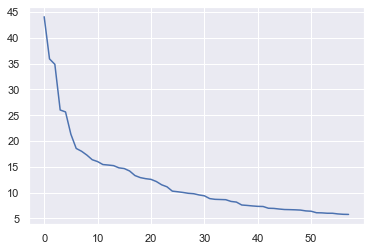

In [341]:
plt.plot(Sigma)

In [342]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

Topic 0:  ['abstract(0.93)', 'abstract modern(0.17)', 'modern(0.17)']
Topic 1:  ['landscape(0.92)', 'contemporary(0.22)', 'abstract(-0.18)']
Topic 2:  ['contemporary(0.54)', 'contemporary art(0.52)', 'art(0.49)']
Topic 3:  ['portrait(0.76)', 'modern(0.42)', 'abstract modern(0.33)']
Topic 4:  ['portrait(0.63)', 'modern(-0.52)', 'abstract modern(-0.43)']
Topic 5:  ['impressionism(0.74)', 'abstract modern(-0.28)', 'expressionism(0.28)']
Topic 6:  ['beach(0.97)', 'seascape(0.18)', 'beach landscape(0.1)']
Topic 7:  ['contemporary(-0.44)', 'pop(0.42)', 'pop art(0.41)']
Topic 8:  ['impressionist(0.94)', 'impressionist landscape(0.18)', 'pop(0.12)']
Topic 9:  ['impressionism(0.53)', 'expressionism(-0.4)', 'air(-0.29)']
Topic 10:  ['vintage(0.87)', 'seascape(0.27)', 'art deco(-0.16)']
Topic 11:  ['seascape(0.84)', 'art deco(0.24)', 'deco(0.24)']
Topic 12:  ['floral(0.48)', 'art deco(0.39)', 'deco(0.39)']
Topic 13:  ['floral(0.86)', 'seascape(0.22)', 'vintage(-0.21)']
Topic 14:  ['fantasy(0.96)'

In [343]:
#Which are the largest regression coefficients in the regression model?
feature_names_style_ridge_tfidf = style_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_ridge_SVD_reg_coeff_df = pd.DataFrame(style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
style_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_style_topics)
style_ridge_SVD_reg_coeff_df = style_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients                                              Topic
41                63.578762  [impressionism landscape(0.94), expressionism ...
7                 44.148428    [contemporary(-0.44), pop(0.42), pop art(0.41)]
15                41.058533  [abstract contemporary(0.41), contemporary art...
55                35.614561     [folk(0.69), mediterranean(0.5), asian(-0.31)]
47                33.457884  [zen(0.87), beach landscape(0.28), zen abstrac...
39                29.677012  [figurative(0.93), figurative portrait(0.16), ...
5                 27.106307  [impressionism(0.74), abstract modern(-0.28), ...
29                25.411088  [outsider(0.41), outsider art(0.41), modern(-0...
2                 23.550927  [contemporary(0.54), contemporary art(0.52), a...
3                 22.480105  [portrait(0.76), modern(0.42), abstract modern...

In [344]:
style_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients                                              Topic
4                -31.195575  [portrait(0.63), modern(-0.52), abstract moder...
34               -37.326378   [music(0.59), music art(0.59), minimalist(0.33)]
37               -37.637384      [horror(0.97), goth(0.12), horror goth(0.09)]
36               -43.899935  [landscape contemporary(0.56), impressionist l...
19               -44.802303  [wildlife(1.0), realism(-0.07), wildlife lands...
30               -48.977079  [outsider(0.5), outsider art(0.5), abstract la...
21               -54.697783  [abstract contemporary(0.71), modern contempor...
53               -56.795707  [contemporary landscape(0.74), impressionist a...
31               -61.612220  [abstract landscape(0.52), minimalist(-0.45), ...
57               -74.034614  [inspired(0.47), nature(0.47), nature inspired...

### 5d) Decision tree of style tags only, after Tf-Idf vectorization, with optional dimensionality reduction

In [345]:
from sklearn.pipeline import Pipeline

style_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [346]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} #np.linspace(0,10,1)} 
style_dtree_w_tfidf_CVmodel = GridSearchCV(style_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [347]:
style_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:   55.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=15))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 51, 2)},
             verbose=1)

In [348]:
style_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

10

In [349]:
#Predict prices on training set:
prices_train_pred = style_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
style_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.06100518349488582

In [350]:
#Predict prices on test set:
prices_test_pred = style_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
style_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.04865721394315836

In [351]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only style tags, after Tf-Idf')


Decision Tree model using only style tags, after Tf-Idf:
Training R^2: 0.06100518349488582
Testing R^2: 0.04865721394315836
Training RMSE: USD 112.06884406924956
Testing RMSE: USD 112.65906235251673
Training MAE: USD 93.31990948059256
Testing MAE: USD 94.30363640215243


In [352]:
#What are the style words or word combos that are used most by the tree regressor?
feature_names_style_dtree_w_tfidf = style_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_dtree_w_tfidf_features_imp_df = pd.DataFrame(style_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_style_dtree_w_tfidf,columns=['Dtree feature importance'])
style_dtree_w_tfidf_features_imp_df = style_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
expressionism impressionism                  0.227975
deco abstract                                0.104401
art vintage                                  0.088263
modern                                       0.054564
modern contemporary                          0.049300
традиционный                                 0.045383
art contemporary                             0.043577
rocker                                       0.041470
abstract pop                                 0.035967
expressionist                                0.033055
nature                                       0.029035
expressionism contemporary                   0.028633
art portrait                                 0.025672
abstract                                     0.019634
zen                                          0.016191
contemporary art                             0.015843
landscape                                    0.013002
impressionism modern                         0.012826
modern vintage                               0.011333
impressionism                                0.009914

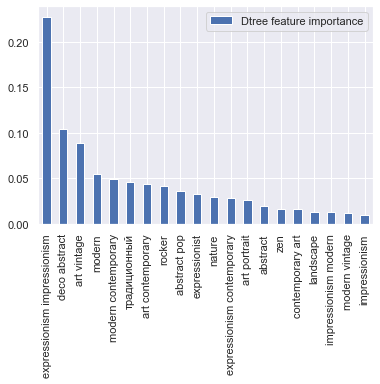

In [353]:
style_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [354]:
#what if I do dimensionality reduction before computing the regressor?

In [355]:
from sklearn.decomposition import TruncatedSVD

style_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10))
])

In [356]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,42,2)} 
#style_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(style_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
style_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(style_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [357]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/style_tags_SVD_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(style_tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        style_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.')
except: #if not, actually perform the fit then save the model for next time:
    
    style_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(style_dtree_w_tfidf_SVD_CVmodel, style_tags_SVD_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.


In [358]:
style_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 28, 'dtree__max_depth': 6}

In [359]:
#Predict prices on training set:
prices_train_pred = style_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [360]:
#And return the R2 score as follows:
style_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.06457369601249241

In [361]:
#Predict prices on test set:
prices_test_pred = style_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [362]:
#And return the R2 score as follows:
style_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.04774638932349806

In [363]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized tags with Tf-Idf followed by SVD')

Decision tree model using vectorized tags with Tf-Idf followed by SVD:
Training R^2: 0.06457369601249241
Testing R^2: 0.04774638932349806
Training RMSE: USD 111.85569073333208
Testing RMSE: USD 112.71297987850812
Training MAE: USD 93.27369054224694
Testing MAE: USD 94.043251764756


In [364]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [365]:
style_feature_names = style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [366]:
# Get Singular values and Components 
Sigma = style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([44.08588285, 35.9189567 , 34.86662683, 26.01961499, 25.64339938,
       21.32627033, 18.56913068, 18.02403885, 17.27968609, 16.38347059,
       16.02580367, 15.44724689, 15.35154682, 15.23908697, 14.80666779,
       14.67063703, 14.19903189, 13.31709373, 12.91805731, 12.71117058,
       12.5776079 , 12.16088969, 11.52602754, 11.13380654, 10.29489127,
       10.16768935, 10.03200069,  9.84781343])

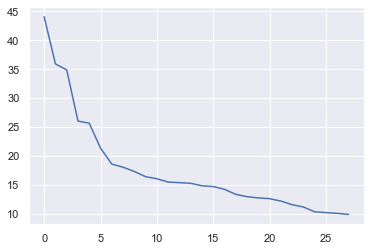

In [367]:
plt.plot(Sigma)

In [368]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

Topic 0:  ['abstract(0.93)', 'abstract modern(0.17)', 'modern(0.17)']
Topic 1:  ['landscape(0.92)', 'contemporary(0.22)', 'abstract(-0.18)']
Topic 2:  ['contemporary(0.54)', 'contemporary art(0.52)', 'art(0.49)']
Topic 3:  ['portrait(0.76)', 'modern(0.42)', 'abstract modern(0.33)']
Topic 4:  ['portrait(0.63)', 'modern(-0.52)', 'abstract modern(-0.43)']
Topic 5:  ['impressionism(0.74)', 'abstract modern(-0.28)', 'expressionism(0.28)']
Topic 6:  ['beach(0.97)', 'seascape(0.18)', 'beach landscape(0.1)']
Topic 7:  ['contemporary(-0.44)', 'pop(0.42)', 'pop art(0.41)']
Topic 8:  ['impressionist(0.94)', 'impressionist landscape(0.18)', 'pop(0.12)']
Topic 9:  ['impressionism(0.53)', 'expressionism(-0.4)', 'air(-0.29)']
Topic 10:  ['vintage(0.87)', 'seascape(0.27)', 'art deco(-0.16)']
Topic 11:  ['seascape(0.84)', 'art deco(0.24)', 'deco(0.24)']
Topic 12:  ['floral(0.48)', 'art deco(0.39)', 'deco(0.39)']
Topic 13:  ['floral(0.86)', 'seascape(0.22)', 'vintage(-0.21)']
Topic 14:  ['fantasy(0.96)'

In [369]:
#Which are the most predictive 'topics' in the decision tree?

In [370]:
#What are the style words or word combos that are used most by the tree regressor?
style_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
style_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_dtree_w_tfidf_SVD_features_imp_df = style_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
7                   0.188530   
15                  0.147522   
4                   0.089812   
20                  0.070011   
0                   0.052880   
10                  0.047771   
2                   0.046809   
17                  0.043227   
11                  0.036320   
1                   0.035765   
18                  0.033113   
16                  0.029096   
24                  0.028952   
3                   0.027605   
8                   0.025471   
19                  0.018590   
5                   0.016804   
6                   0.015671   
27                  0.014809   
23                  0.013777   

                                                Topic  
7     [contemporary(-0.44), pop(0.42), pop art(0.41)]  
15  [abstract contemporary(0.41), contemporary art...  
4   [portrait(0.63), modern(-0.52), abstract moder...  
20  [nude(0.98), abstract nude(0.1), portrait nude...  
0   [abstract(0.93), abstract modern(0.17), modern...  
10   [vintage(0.87), seascape(0.27), art deco(-0.16)]  
2   [contemporary(0.54), contemporary art(0.52), a...  
17  [realism(0.98), realism portrait(0.08), wildli...  
11       [seascape(0.84), art deco(0.24), deco(0.24)]  
1   [landscape(0.92), contemporary(0.22), abstract...  
18      [mid(0.52), mid century(0.52), century(0.52)]  
16    [expressionism(0.63), air(-0.31), plein(-0.31)]  
24  [cityscape(0.94), traditional(0.21), cityscape...  
3   [portrait(0.76), modern(0.42), abstract modern...  
8   [impressionist(0.94), impressionist landscape(...  
19  [wildlife(1.0), realism(-0.07), wildlife lands...  
5   [impressionism(0.74), abstract modern(-0.28), ...  
6   [beach(0.97), seascape(0.18), beach landscape(...  
27  [impressionistic(0.96), expressionist(0.16), i...  
23  [nautical(0.97), beach nautical(0.17), nautica...

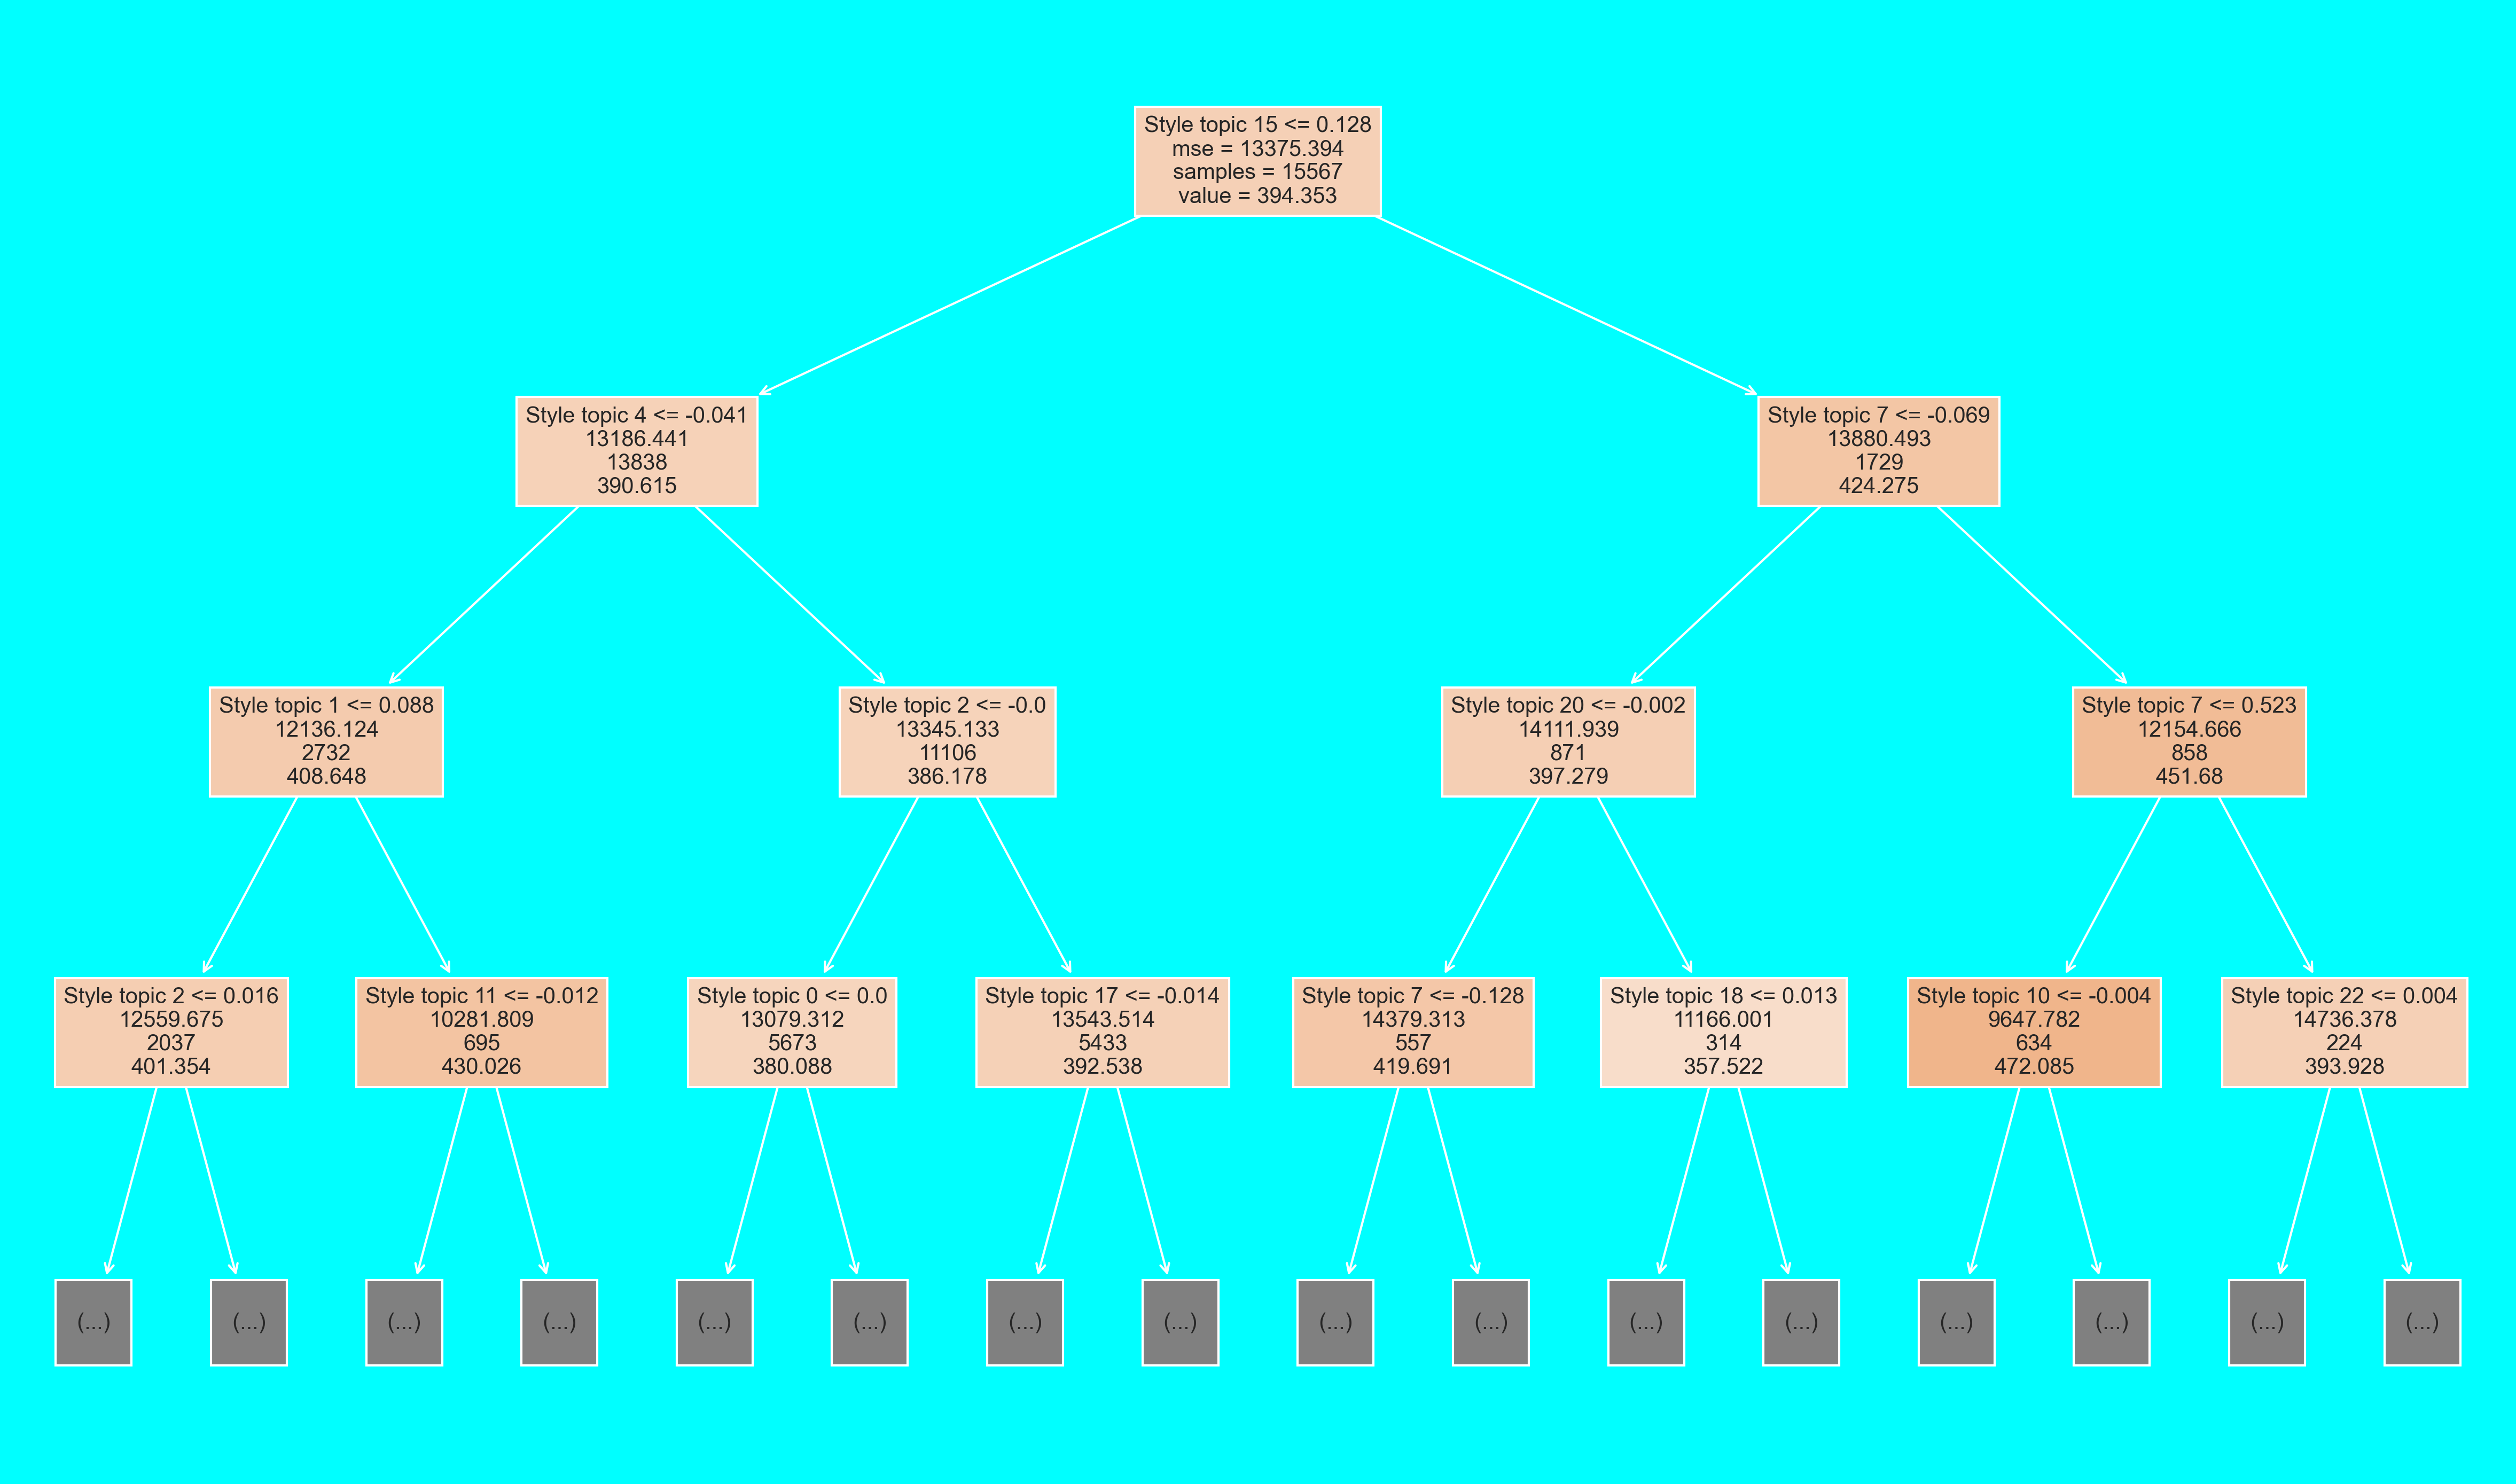

In [371]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_style_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_style_tags_After_tfidf_SVD.png')

#### Model 5e) Random Forest on Style Tags, after Tf-Idf vectorization and SVD reduction

In [372]:
from sklearn.ensemble import RandomForestRegressor

In [373]:
from sklearn.decomposition import TruncatedSVD

style_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=30)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [374]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/style_rforest_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(style_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        style_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with random forest model for style tags (after Tf-Idf and SVD).')
except: #if not, actually perform the fit then save the model for next time:
    
    style_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(style_rforest_w_tfidf_SVD_pipe, style_rforest_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with random forest model for style tags (after Tf-Idf and SVD).')

Loaded joblib file with random forest model for style tags (after Tf-Idf and SVD).


In [375]:
#Predict prices on training set:
prices_train_pred = style_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.0765414351755338

In [376]:
#Predict prices on test set:
prices_test_pred = style_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.05494556128476047

In [377]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using style tags (after Tf-Idf and SVD reduction)')


Random Forest model using style tags (after Tf-Idf and SVD reduction):
Training R^2: 0.0765414351755338
Testing R^2: 0.05494556128476047
Training RMSE: USD 111.13785278017963
Testing RMSE: USD 112.28610851216956
Training MAE: USD 92.94358117855752
Testing MAE: USD 94.0940801241774


In [378]:
#what are the main features used for decision?
style_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.0357997 , 0.02871687, 0.04755578, 0.03476493, 0.05810499,
       0.04797881, 0.03239439, 0.04750669, 0.03085868, 0.04061325,
       0.03044423, 0.02782869, 0.03000581, 0.0201689 , 0.01869129,
       0.04933219, 0.03323627, 0.02822439, 0.02941084, 0.03057488,
       0.03394611, 0.04110585, 0.02731457, 0.02464641, 0.03120126,
       0.023989  , 0.0286373 , 0.03759568, 0.02266511, 0.02668715])

In [379]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    #print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

In [380]:
#What are the style words or word combos that are used most by the random forest regressor?
style_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
style_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_rforest_w_tfidf_SVD_features_imp_df = style_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
style_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
4                     0.058105   
15                    0.049332   
5                     0.047979   
2                     0.047556   
7                     0.047507   
21                    0.041106   
9                     0.040613   
27                    0.037596   
0                     0.035800   
3                     0.034765   
20                    0.033946   
16                    0.033236   
6                     0.032394   
24                    0.031201   
8                     0.030859   
19                    0.030575   
10                    0.030444   
12                    0.030006   
18                    0.029411   
1                     0.028717   

                                                Topic  
4   [portrait(0.63), modern(-0.52), abstract moder...  
15  [abstract contemporary(0.41), contemporary art...  
5   [impressionism(0.74), abstract modern(-0.28), ...  
2   [contemporary(0.54), contemporary art(0.52), a...  
7     [contemporary(-0.44), pop(0.42), pop art(0.41)]  
21  [abstract contemporary(0.71), modern contempor...  
9   [impressionism(0.53), expressionism(-0.4), air...  
27  [impressionistic(0.84), expressionist(0.42), e...  
0   [abstract(0.93), abstract modern(0.17), modern...  
3   [portrait(0.76), modern(0.42), abstract modern...  
20  [nude(0.98), abstract nude(0.1), portrait nude...  
16    [expressionism(0.63), air(-0.31), plein(-0.31)]  
6   [beach(0.97), seascape(0.18), beach landscape(...  
24  [cityscape(0.95), traditional(0.17), cityscape...  
8   [impressionist(0.94), impressionist landscape(...  
19  [wildlife(1.0), realism(-0.07), wildlife lands...  
10   [vintage(0.87), seascape(0.27), art deco(-0.16)]  
12         [floral(0.48), art deco(0.39), deco(0.39)]  
18      [mid(0.52), mid century(0.52), century(0.52)]  
1   [landscape(0.92), contemporary(0.22), abstract...

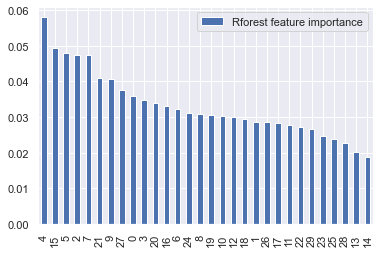

In [381]:
style_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 5f) Gradient Boosting on Style Tags, after Tf-Idf vectorization and SVD reduction

In [382]:
from sklearn.ensemble import GradientBoostingRegressor

In [383]:
from sklearn.decomposition import TruncatedSVD

style_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=30)),
    #('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.75,max_depth=3,random_state=1))
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
    #('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [384]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/style_gboost_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(style_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        style_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for style tags (after Tf-Idf and SVD).')
except: #if not, actually perform the fit then save the model for next time:
    
    style_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(style_gboost_w_tfidf_SVD_pipe, style_gboost_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with gradient boosting model for style tags (after Tf-Idf and SVD).')

Loaded joblib file with gradient boosting model for style tags (after Tf-Idf and SVD).


In [385]:
#Predict prices on training set:
prices_train_pred = style_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.08238789106998445

In [386]:
#Predict prices on test set:
prices_test_pred = style_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.057502173383550126

In [387]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using style tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using style tags (after Tf-Idf and SVD reduction):
Training R^2: 0.08238789106998445
Testing R^2: 0.057502173383550126
Training RMSE: USD 110.7854849174713
Testing RMSE: USD 112.13412444357627
Training MAE: USD 92.42141339836768
Testing MAE: USD 93.63754875353918


In [388]:
#what are the main features used for decision?
style_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.0518902 , 0.02766874, 0.03658486, 0.03920812, 0.04814142,
       0.04025754, 0.02972414, 0.06350387, 0.02062947, 0.02313   ,
       0.04010103, 0.02997332, 0.03384523, 0.02045176, 0.01578119,
       0.04034242, 0.04254611, 0.02902915, 0.02603172, 0.03817423,
       0.03435868, 0.03067343, 0.02860414, 0.02960443, 0.04274964,
       0.02189858, 0.01450835, 0.03440247, 0.03177494, 0.03441087])

In [389]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    #print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

In [390]:
#What are the style words or word combos that are used most by the random forest regressor?
style_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
style_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_gboost_w_tfidf_SVD_features_imp_df = style_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
style_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
7                    0.063504   
0                    0.051890   
4                    0.048141   
24                   0.042750   
16                   0.042546   
15                   0.040342   
5                    0.040258   
10                   0.040101   
3                    0.039208   
19                   0.038174   
2                    0.036585   
29                   0.034411   
27                   0.034402   
20                   0.034359   
12                   0.033845   
28                   0.031775   
21                   0.030673   
11                   0.029973   
6                    0.029724   
23                   0.029604   

                                                Topic  
7     [contemporary(-0.44), pop(0.42), pop art(0.41)]  
0   [abstract(0.93), abstract modern(0.17), modern...  
4   [portrait(0.63), modern(-0.52), abstract moder...  
24  [cityscape(0.95), traditional(0.18), cityscape...  
16    [expressionism(0.63), air(-0.31), plein(-0.31)]  
15  [abstract contemporary(0.41), contemporary art...  
5   [impressionism(0.74), abstract modern(-0.28), ...  
10   [vintage(0.87), seascape(0.27), art deco(-0.16)]  
3   [portrait(0.76), modern(0.42), abstract modern...  
19  [wildlife(1.0), realism(-0.07), wildlife lands...  
2   [contemporary(0.54), contemporary art(0.52), a...  
29  [outsider(0.39), outsider art(0.39), modern(-0...  
27  [impressionistic(0.86), expressionist(0.38), e...  
20  [nude(0.98), abstract nude(0.1), portrait nude...  
12         [floral(0.48), art deco(0.39), deco(0.39)]  
28  [expressionist(0.59), impressionistic(-0.45), ...  
21  [abstract contemporary(0.71), modern contempor...  
11       [seascape(0.84), art deco(0.24), deco(0.24)]  
6   [beach(0.97), seascape(0.18), beach landscape(...  
23  [nautical(0.97), beach nautical(0.17), nautica...

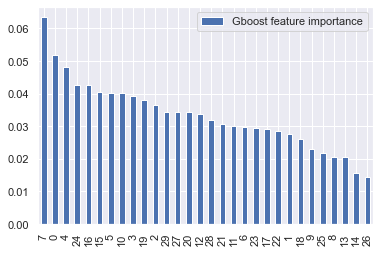

In [391]:
style_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 6) Models using non-stlye tags

### 6a) Ridge regression model using the 'regular' tags, that have more than style information

In [392]:
paintings_with_style_tags_and_image_info_df['tags'].iloc[1]

"['original painting', 'surreal', 'surrealism', 'mouth', 'eye', 'canvas', 'abstract', 'landscape', 'dark', 'shapeshifter', 'madness', 'face', 'morph']"

In [393]:
paintings_with_style_tags_and_image_info_df['tags'].value_counts()

['Oil painting', 'original', 'framed', 'canvas', 'antique', 'vintage', 'wall art', 'picture']                                                                                                                                                                 44
['Oil painting', 'original', 'framed', 'canvas', 'antique', 'vintage', 'wall art', 'picture', 'signed', 'modern', 'abstract']                                                                                                                                 40
['modern', 'impressionism', 'abstract', 'painting', 'art', 'expressionism', 'expressionist', 'contemporary', 'signed', 'artist', 'landscape', 'sky', 'clouds']                                                                                                29
[]                                                                                                                                                                                                                                   

In [394]:
#Here, I will certainly need to use more traditional NLP with TfIdfVEctorizer (as in the last version of the style tags regressor). 
' '.join(eval(paintings_with_style_tags_and_image_info_df['tags'].iloc[1]))

'original painting surreal surrealism mouth eye canvas abstract landscape dark shapeshifter madness face morph'

In [395]:
paintings_with_style_tags_and_image_info_df['tags'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0        toys plane vintage children nursery baby decor...
1        original painting surreal surrealism mouth eye...
2        original painting landscape japan kanazawa str...
3        landscape adobe santa fe new mexico historic a...
4        custom portrait Pet portrait Custom pet portra...
                               ...                        
19454    abstract turquoise black big wall art large wa...
19455    Original wall art paint pouring impressionisti...
19456    field red flower petal yellow green pink white...
19457    abstract art abstract art deco wall deco acryl...
19458    canvas art paint artist expressionism Charlest...
Name: tags, Length: 19459, dtype: object

In [396]:
#I run the 'tags' column through the Encoder-TfIdf Vectorizer sequence of steps discussed above 
tags_tranform = ColumnTransformer([
    ('tags tfidf', pipe_tags_encoding, 'tags'),
], remainder='drop')

In [397]:
from sklearn.linear_model import Ridge

tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [398]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
tags_ridge_w_tfidf_CVmodel = GridSearchCV(tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [399]:
#Train the model
tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   50.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'tags')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [400]:
tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 2.0}

In [401]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [402]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.5395285649625197

In [403]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [404]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.20103283824300555

In [405]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf')

Ridge regression model using vectorized tags with Tf-Idf:
Training R^2: 0.5395285649625197
Testing R^2: 0.20103283824300555
Training RMSE: USD 78.47921352708043
Testing RMSE: USD 103.2433487305987
Training MAE: USD 63.86997025820401
Testing MAE: USD 83.72063358125749


In [406]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_ridge_reg_coeff_df = pd.DataFrame(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_tags_ridge_tfidf,columns=['Regression coefficients'])
tags_ridge_reg_coeff_df = tags_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_reg_coeff_df.iloc[:20]

Regression coefficients
large                                   172.741647
coa contemporary                        171.617617
art collectibles                        157.481101
art for                                 147.424276
vivid                                   140.810074
handpainting                            139.872508
collectibles                            126.559411
ireland                                 125.480455
decor home                              125.367335
art vintage                             124.018713
48                                      117.948618
decor gifts                             117.319952
36                                      111.152468
collectibles handpainting               109.283977
california                              107.526721
wall painting                           106.845321
study of                                106.809751
peinture                                101.531497
reflection                              101.373684
teofilo                                 101.105996

In [407]:
tags_ridge_reg_coeff_df.iloc[-20:]

Regression coefficients
cynara                                    -94.009188
cityscape painting                        -95.461399
contemporary signed                       -96.870510
artist canvas                             -97.124196
expressionism expressionist               -97.681221
painting portrait                         -98.736191
painting abstract                        -101.221762
walton                                   -101.555642
pour                                     -102.023806
ralph smith                              -102.043653
original figurative                      -105.256482
ralph                                    -106.306053
hand oil                                 -110.279300
abstract portrait                        -111.522615
wildlife                                 -113.821371
inches                                   -116.291288
modern mid                               -119.230808
small painting                           -120.879438
nyc                                      -126.925153
small                                    -150.251641

#### Let's include a dimensionality-eduction step to attempt to reduce the overfitting of the training set (the R^2 in training set is much better than test set)

In [408]:
#Note that I also tried two other steps to reduce overfitting (not shown here).
#First option was to try LASSO instead of Ridge Regression (as this would tend to send more weights to 0) but the training was taking too long 
#Second option is to reduce the max number of features considered in TfIdf from the original ~90000 to 5000, but that reduced significantly both the
#performance on training data and on testing data, without getting the two performance metrics to approach each other (testing was still much better) 

In [409]:
#This time I tried first with Nonnegative Matrix Factorization to see if I would get more interpretable 'topics', but 
#(a) it was slower and (b) gave worse results than Truncated SVD

# from sklearn.decomposition import NMF

# #Note: I use the original version of tf-idf (without limiting the number of features)
# #but then add non-negative matrix factorization before ridge regression

# tags_ridge_w_tfidf_NMF_pipe = Pipeline([
#     ('tags tfidf vectorization', tags_tranform),
#     ('NMF', NMF(n_components=3)),
#     ('ridge',Ridge(alpha=10))
# ])

In [410]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# param_grid = {'ridge__alpha': np.linspace(1,10,10), 'NMF__n_components': range(10,400,10)} 
# tags_ridge_w_tfidf_NMF_CVmodel = RandomizedSearchCV(tags_ridge_w_tfidf_NMF_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
# #param_grid = {'ridge__alpha': np.linspace(1,10,10), 'NMF__n_components': range(4,41,4)} 
# #tags_ridge_w_tfidf_NMF_CVmodel = GridSearchCV(tags_ridge_w_tfidf_NMF_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [411]:
# #Train the model
# tags_ridge_w_tfidf_NMF_CVmodel.fit(paintings_df_train,prices_train)

In [412]:
#tags_ridge_w_tfidf_NMF_CVmodel.best_params_

In [413]:
##Predict prices on training set:
#prices_train_pred = tags_ridge_w_tfidf_NMF_CVmodel.predict(paintings_df_train)

In [414]:
##And return the R2 score as follows:
#tags_ridge_w_tfidf_NMF_CVmodel.score(paintings_df_train,prices_train)

In [415]:
##Predict prices on test set:
#prices_test_pred = tags_ridge_w_tfidf_NMF_CVmodel.predict(paintings_df_test)

In [416]:
##And return the R2 score as follows:
#tags_ridge_w_tfidf_NMF_CVmodel.score(paintings_df_test,prices_test)

In [417]:
##Print results, using the function defined earlier:

#print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf followed by NMF')

In [418]:
#tags_ridge_w_tfidf_NMF_CVmodel

In [419]:
#Let's try Truncated SVD instead

In [420]:
from sklearn.decomposition import TruncatedSVD

tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [421]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,10), 'SVD__n_components': range(10,400,10)} 
tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
#tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [422]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/tags_SVD_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression model for general tags vectorized with tf-idf and reduced with SVD.')
except: #if not, actually perform the fit then save the model for next time:
    
    tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(tags_ridge_w_tfidf_SVD_CVmodel, tags_SVD_ridge_CVmodel_filename) 
        print('Saved joblib file with ridge regression model for general tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with ridge regression model for general tags vectorized with tf-idf and reduced with SVD.


In [423]:
tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'ridge__alpha': 3.0, 'SVD__n_components': 330}

In [424]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [425]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.14107727403887627

In [426]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [427]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.13204602153754574

In [428]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized tags with Tf-Idf followed by SVD:
Training R^2: 0.14107727403887627
Testing R^2: 0.13204602153754574
Training RMSE: USD 107.18409413972773
Testing RMSE: USD 107.60834864390732
Training MAE: USD 88.35401113563793
Testing MAE: USD 89.01798568507171


In [429]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [430]:
tags_feature_names = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

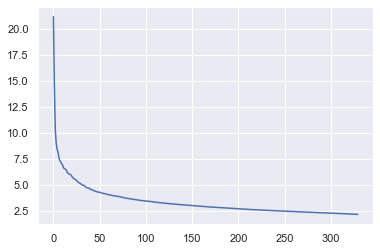

In [431]:
# Get Singular values and Components 
Sigma = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
plt.plot(Sigma)

In [432]:
list_of_tag_topics = []

for index, component in enumerate(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tag_topics.append(topic_tag_components)
    #print("Topic "+str(index)+": ",topic_tag_components) 

In [433]:
#Which are the largest regression coefficients in the regression model?

#feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_ridge_SVD_reg_coeff_df = pd.DataFrame(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
tags_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_tag_topics)
tags_ridge_SVD_reg_coeff_df = tags_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients  \
23                197.597264   
119               170.418847   
286               160.662424   
269               146.416855   
16                142.159431   
241               130.886307   
260               130.749466   
206               123.253411   
136               121.206967   
54                115.441408   

                                                 Topic  
23               [pop(0.2), pop art(0.2), fine(-0.19)]  
119    [texture(0.16), geometric(-0.16), winter(0.15)]  
286  [surrealism(0.13), art decor(0.12), clouds(0.12)]  
269  [peinture(0.15), abstract abstract(-0.12), sce...  
16       [mid(0.35), mid century(0.35), century(0.35)]  
241   [beautiful(-0.17), peinture(0.15), street(0.13)]  
260           [rose(0.13), rainbow(0.11), scene(0.11)]  
206         [art oil(0.17), style(0.15), brown(-0.14)]  
136  [art contemporary(0.14), ship(0.13), geometric...  
54                      [30(-0.5), 48(0.33), 36(0.32)]

In [434]:
tags_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients  \
104              -107.305362   
185              -108.992302   
258              -117.943926   
43               -119.732683   
173              -131.950679   
27               -134.034140   
100              -134.305073   
99               -135.634036   
149              -157.566880   
37               -236.440406   

                                                 Topic  
104   [white(-0.21), abstract art(-0.18), ship(-0.15)]  
185  [rock(-0.21), space(0.16), painting painting(0...  
258        [rose(0.25), roses(0.18), beautiful(-0.14)]  
43       [trees(-0.23), red(-0.2), art painting(0.19)]  
173       [square(-0.2), small(0.16), mountains(0.12)]  
27       [modern(-0.23), fine(-0.21), fine art(-0.21)]  
100   [on paper(0.17), paper(0.14), art acrylic(0.12)]  
99   [painting acrylic(0.23), fantasy(0.23), purple...  
149   [girl(0.2), resin(-0.15), painting modern(0.13)]  
37   [fine(-0.18), fine art(-0.18), contemporary(-0...

### 6b) Ridge Regression model using the 'materials' tags to see if they have much predictive value

In [435]:
#I run the 'tags' column through the Encoder-TfIdf Vectorizer sequence of steps discussed above 
materials_tags_tranform = ColumnTransformer([
    ('materials tfidf', pipe_tags_encoding, 'materials'),
], remainder='drop')

In [436]:
from sklearn.linear_model import Ridge

materials_tags_ridge_w_tfidf_pipe = Pipeline([
    ('materials tags tfidf vectorization', materials_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [437]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
materials_tags_ridge_w_tfidf_CVmodel = GridSearchCV(materials_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [438]:
#Train the model
materials_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   18.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('materials tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'materials')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [439]:
materials_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 2.0}

In [440]:
#Predict prices on training set:
prices_train_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [441]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.1433885348431151

In [442]:
#Predict prices on test set:
prices_test_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [443]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.0731446176996261

In [444]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized material tags with Tf-Idf')

Ridge regression model using vectorized material tags with Tf-Idf:
Training R^2: 0.1433885348431151
Testing R^2: 0.0731446176996261
Training RMSE: USD 107.0397870524162
Testing RMSE: USD 111.19969749495225
Training MAE: USD 88.54400382158143
Testing MAE: USD 92.56467590971842


In [445]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_materials_ridge_tfidf = materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['materials tags tfidf vectorization'].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()

materials_tags_ridge_reg_coeff_df = pd.DataFrame(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_materials_ridge_tfidf,columns=['Regression coefficients'])
materials_tags_ridge_reg_coeff_df = materials_tags_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_tags_ridge_reg_coeff_df.iloc[:10]

Regression coefficients
acrylic oil                        185.688452
paper wood                         143.124167
paint paper                        138.988765
varnish wood                       133.995940
board canvas                       121.485704
brush varnish                      120.019320
on gallery                         119.141481
canvas oil                         117.936573
canvas wire                        107.073086
professional quality               101.974788

In [446]:
materials_tags_ridge_reg_coeff_df.iloc[-10:]

Regression coefficients
usa                          -93.618962
wired                        -93.766305
paints usa                   -94.332166
paint                       -104.844792
linen panel                 -109.013031
on wood                     -110.031753
paints gallery              -113.796390
paint wrapped               -115.862587
paint painting              -128.229988
frame canvas                -152.474128

In [447]:
#So it does look that the 'materials' tags also have some predictive power. Let's now combine all the tags together - using SVD for dimensionality reduction and preventing overfitting

### 6c)-6d) Tree-based models for the general tags and the materials-specific tags

In [448]:
#Not implemented, as it was more relevant to focus on the model combining all tags

## 7) Model combining all the tags of interest: general 'tags', 'style-specific tags', 'material-specific tags'

### 7a) Ridge regression model of SVD-reduced combinations of tags of all 3 types

In [449]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')



In [450]:
#I need a FetureUnion of the three :
from sklearn.pipeline import FeatureUnion

tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
                                ("style tags tf-idf", style_tags_tranform),
                                ("materials tags tf-idf", materials_tags_tranform),
                               ])


In [451]:
# #Check that I can train this FeatureUnion
#tags_info_union.fit(paintings_df_train)

In [452]:
from sklearn.decomposition import TruncatedSVD

tags_union_SVD_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [453]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,10), 'SVD__n_components': range(10,600,10)} 
tags_union_SVD_CVmodel = RandomizedSearchCV(tags_union_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=30)
#tags_union_SVD_CVmodel = GridSearchCV(tags_union_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [454]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_union_SVD_CVmodel_filename = './Git_exclude/models/tags_union_SVD_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_union_SVD_CVmodel_filename, 'rb') as f:
        tags_union_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression using SVD-reduced tags (general+style+materials).')
except: #if not, actually perform the fit then save the model for next time:
    
    tags_union_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_union_SVD_CVmodel_filename, 'wb') as f:
        dump(tags_union_SVD_CVmodel, tags_union_SVD_CVmodel_filename) 
        print('Saved joblib file with ridge regression using SVD-reduced tags (general+style+materials).')

Loaded joblib file with ridge regression using SVD-reduced tags (general+style+materials).


In [455]:
tags_union_SVD_CVmodel.best_params_

{'ridge__alpha': 3.0, 'SVD__n_components': 530}

In [456]:
#Predict prices on training set:
prices_train_pred = tags_union_SVD_CVmodel.predict(paintings_df_train)

In [457]:
#And return the R2 score as follows:
tags_union_SVD_CVmodel.score(paintings_df_train,prices_train)

0.17094282088258117

In [458]:
#Predict prices on test set:
prices_test_pred = tags_union_SVD_CVmodel.predict(paintings_df_test)

In [459]:
#And return the R2 score as follows:
tags_union_SVD_CVmodel.score(paintings_df_test,prices_test)

0.1400756082573228

In [460]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using all tags vectorized with Tf-Idf followed by SVD')

Ridge regression model using all tags vectorized with Tf-Idf followed by SVD:
Training R^2: 0.17094282088258117
Testing R^2: 0.1400756082573228
Training RMSE: USD 105.30416219165556
Testing RMSE: USD 107.10944072078091
Training MAE: USD 85.98218302803535
Testing MAE: USD 87.8952852614015


In [461]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [462]:
tags_union_feature_names = tags_union_SVD_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[0][1].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [463]:
tags_union_feature_names[:10]

['10',
 '10 10',
 '10 20',
 '10 floral',
 '10 inches',
 '10 oil',
 '10 painting',
 '10 year',
 '100',
 '100 happy']

In [464]:
style_tags_union_feature_names = tags_union_SVD_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[1][1].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [465]:
style_tags_union_feature_names[:10]

['21st',
 '21st century',
 'abstr',
 'abstract',
 'abstract architectural',
 'abstract art',
 'abstract artistic',
 'abstract asian',
 'abstract beach',
 'abstract contemporary']

In [466]:
materials_tags_union_feature_names = tags_union_SVD_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[2][1].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()

In [467]:
materials_tags_union_feature_names[:10]

['10',
 '100cotton',
 '100cotton pine',
 '10th',
 '10th anniversary',
 '10x20',
 '10x30',
 '10x30 landscape',
 '11',
 '11 14']

In [468]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [469]:
list_of_all_tag_topics = []

for index, component in enumerate(tags_union_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    #print("Topic "+str(index)+": ",topic_tag_components) 

In [470]:
#Which are the largest regression coefficients in the regression model?

#feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_union_ridge_SVD_reg_coeff_df = pd.DataFrame(tags_union_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
tags_union_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_all_tag_topics)
tags_union_ridge_SVD_reg_coeff_df = tags_union_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_union_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients  \
192               157.555750   
116               124.597499   
335               117.493533   
461               116.338406   
169               114.400918   
132               110.144415   
524               108.882520   
476               104.364292   
325               103.014308   
269               101.036246   

                                                 Topic  
192  [contemporary contemporary(0.15), cotton(0.14)...  
116  [floral abstract(0.19), landscape(-0.17), canv...  
335  [canvas stretched(-0.17), color(0.16), figurat...  
461  [nautical seascape(-0.12), mountain(0.12), pou...  
169  [primitive(0.25), landscape vintage(-0.21), ex...  
132  [goth(-0.28), romantic(0.27), impressionist ab...  
524  [expressionist modern(-0.14), maine(0.12), cen...  
476  [impressionism portrait(0.14), minimalism abst...  
325  [tribal(0.15), southwestern landscape(0.14), p...  
269  [wood acrylic(0.19), gold(0.14), americana(0.13)]

In [471]:
tags_union_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients  \
162               -97.317009   
151              -101.401866   
520              -101.481549   
261              -103.527114   
387              -103.576610   
402              -110.310497   
265              -116.075261   
79               -127.589685   
175              -129.661876   
217              -147.843600   

                                                 Topic  
162  [landscape vintage(-0.25), beach nautical(-0.2...  
151  [art portrait(-0.25), modern portrait(0.19), e...  
520  [floral portrait(-0.13), zen modern(-0.11), oi...  
261  [americana(0.33), water(0.16), impressionism f...  
387  [floral contemporary(0.17), pop abstract(0.14)...  
402  [nude contemporary(0.16), art acrylic(-0.11), ...  
265  [glass(0.26), nautical landscape(0.15), nature...  
79   [beach landscape(0.45), oils canvas(-0.22), oi...  
175  [impressionist impressionism(0.25), contempora...  
217  [painting abstract(0.19), impressionism contem...

### 7b) Decision tree model of SVD-reduced combinations of tags of all 3 types

In [472]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')



In [473]:
# #I need a FetureUnion of the three :
# from sklearn.pipeline import FeatureUnion

# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])


In [474]:
# #Check that I can train this FeatureUnion
#tags_info_union.fit(paintings_df_train)

In [475]:
from sklearn.decomposition import TruncatedSVD

tags_union_SVD_dtree_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree',DecisionTreeRegressor(max_depth=10))
])

In [476]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,16,2), 'SVD__n_components': range(10,600,20)} 
tags_union_SVD_dtree_CVmodel = RandomizedSearchCV(tags_union_SVD_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
#tags_union_SVD_dtree_CVmodel = GridSearchCV(tags_union_SVD_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [477]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_union_SVD_dtree_CVmodel.fit(paintings_df_train,prices_train);

# tags_union_SVD_dtree_CVmodel_filename = './Git_exclude/models/tags_union_SVD_dtree_CVmodel.joblib'

# #If the model file already exists, I load it:
# try:
#     with open(tags_union_SVD_dtree_CVmodel_filename, 'rb') as f:
#         tags_union_dtree_SVD_CVmodel = load(f)
#         print('Loaded joblib file with decision tree using SVD-reduced tags (general+style+materials).')
# except: #if not, actually perform the fit then save the model for next time:
    
#     tags_union_SVD_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
#     with open(tags_union_SVD_dtree_CVmodel_filename, 'wb') as f:
#         dump(tags_union_SVD_dtree_CVmodel, tags_union_SVD_dtree_CVmodel_filename) 
#         print('Saved joblib file with decision tree using SVD-reduced tags (general+style+materials).')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
C:\Users\matte\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 13.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 23.2min finished


In [478]:
tags_union_SVD_dtree_CVmodel.best_params_

{'dtree__max_depth': 6, 'SVD__n_components': 150}

In [479]:
#Predict prices on training set:
prices_train_pred = tags_union_SVD_dtree_CVmodel.predict(paintings_df_train)

In [480]:
#And return the R2 score as follows:
tags_union_SVD_dtree_CVmodel.score(paintings_df_train,prices_train)

0.08391590602489607

In [481]:
#Predict prices on test set:
prices_test_pred = tags_union_SVD_dtree_CVmodel.predict(paintings_df_test)

In [482]:
#And return the R2 score as follows:
tags_union_SVD_dtree_CVmodel.score(paintings_df_test,prices_test)

0.06937671388494493

In [483]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using all tags vectorized with Tf-Idf followed by SVD')

Decision tree model using all tags vectorized with Tf-Idf followed by SVD:
Training R^2: 0.08391590602489607
Testing R^2: 0.06937671388494493
Training RMSE: USD 110.6932060519187
Testing RMSE: USD 111.42549582909902
Training MAE: USD 91.75000551971725
Testing MAE: USD 92.73287410851636


In [484]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [485]:
tags_union_feature_names = tags_union_SVD_dtree_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[0][1].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [486]:
tags_union_feature_names[:10]

['10',
 '10 10',
 '10 20',
 '10 floral',
 '10 inches',
 '10 oil',
 '10 painting',
 '10 year',
 '100',
 '100 happy']

In [487]:
style_tags_union_feature_names = tags_union_SVD_dtree_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[1][1].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [488]:
style_tags_union_feature_names[:10]

['21st',
 '21st century',
 'abstr',
 'abstract',
 'abstract architectural',
 'abstract art',
 'abstract artistic',
 'abstract asian',
 'abstract beach',
 'abstract contemporary']

In [489]:
materials_tags_union_feature_names = tags_union_SVD_dtree_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[2][1].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()

In [490]:
materials_tags_union_feature_names[:10]

['10',
 '100cotton',
 '100cotton pine',
 '10th',
 '10th anniversary',
 '10x20',
 '10x30',
 '10x30 landscape',
 '11',
 '11 14']

In [491]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [492]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(tags_union_SVD_dtree_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

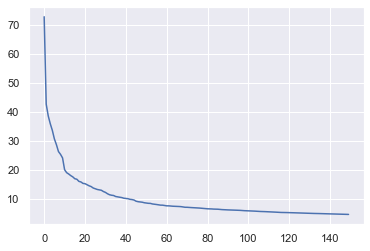

In [493]:
# Get Singular values and Components 
Sigma = tags_union_SVD_dtree_CVmodel.best_estimator_['SVD'].singular_values_ 
plt.plot(Sigma)

In [494]:
#Which are the most predictive 'topics' in the decision tree?

In [495]:
#What are the style words or word combos that are used most by the tree regressor?
tags_union_dtree_SVD_features_imp_df = pd.DataFrame(tags_union_SVD_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
tags_union_dtree_SVD_features_imp_df['Topic']=pd.Series(list_of_all_tag_topics)
tags_union_dtree_SVD_features_imp_df = tags_union_dtree_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
tags_union_dtree_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
4                    0.223949   
11                   0.118665   
65                   0.095155   
64                   0.086598   
84                   0.077425   
96                   0.049208   
68                   0.044616   
5                    0.038932   
113                  0.036322   
46                   0.034554   
137                  0.032181   
49                   0.024692   
24                   0.024542   
77                   0.022442   
91                   0.021682   
103                  0.011475   
75                   0.011168   
40                   0.009486   
15                   0.005964   
141                  0.005570   

                                                 Topic  
4      [paper(-0.69), canvas board(0.22), board(0.21)]  
11   [beach(0.54), impressionism(-0.47), contempora...  
65   [impressionism landscape(0.51), minimalism(-0....  
64   [impressionism landscape(0.48), retro(0.35), p...  
84   [acrylic(0.25), mediterranean(-0.2), metal(-0.2)]  
96   [victorian(0.35), impressionism modern(-0.26),...  
68       [painting(-0.31), fabric(0.24), paints(0.21)]  
5    [paper(-0.44), landscape(0.41), wood hardboard...  
113  [art contemporary(0.27), spooky(0.23), frame(-...  
46   [minimalist(0.45), paints(0.22), abstract mini...  
137  [romantic(0.33), beach seascape(0.18), acrylic...  
49   [landscape contemporary(-0.35), impressionist ...  
24       [mid(0.42), mid century(0.42), century(0.42)]  
77   [beach landscape(0.57), landscape(0.28), perso...  
91   [metal(0.38), cardboard(-0.3), watercolor pape...  
103  [landscape seascape(-0.29), paint stretched(-0...  
75   [impressionist landscape(0.54), landscape cont...  
40   [impressionistic(0.66), modern(0.26), paint ca...  
15   [vintage(0.72), impressionism(0.2), seascape(0...  
141  [industrial(0.27), romantic(0.25), air landsca...

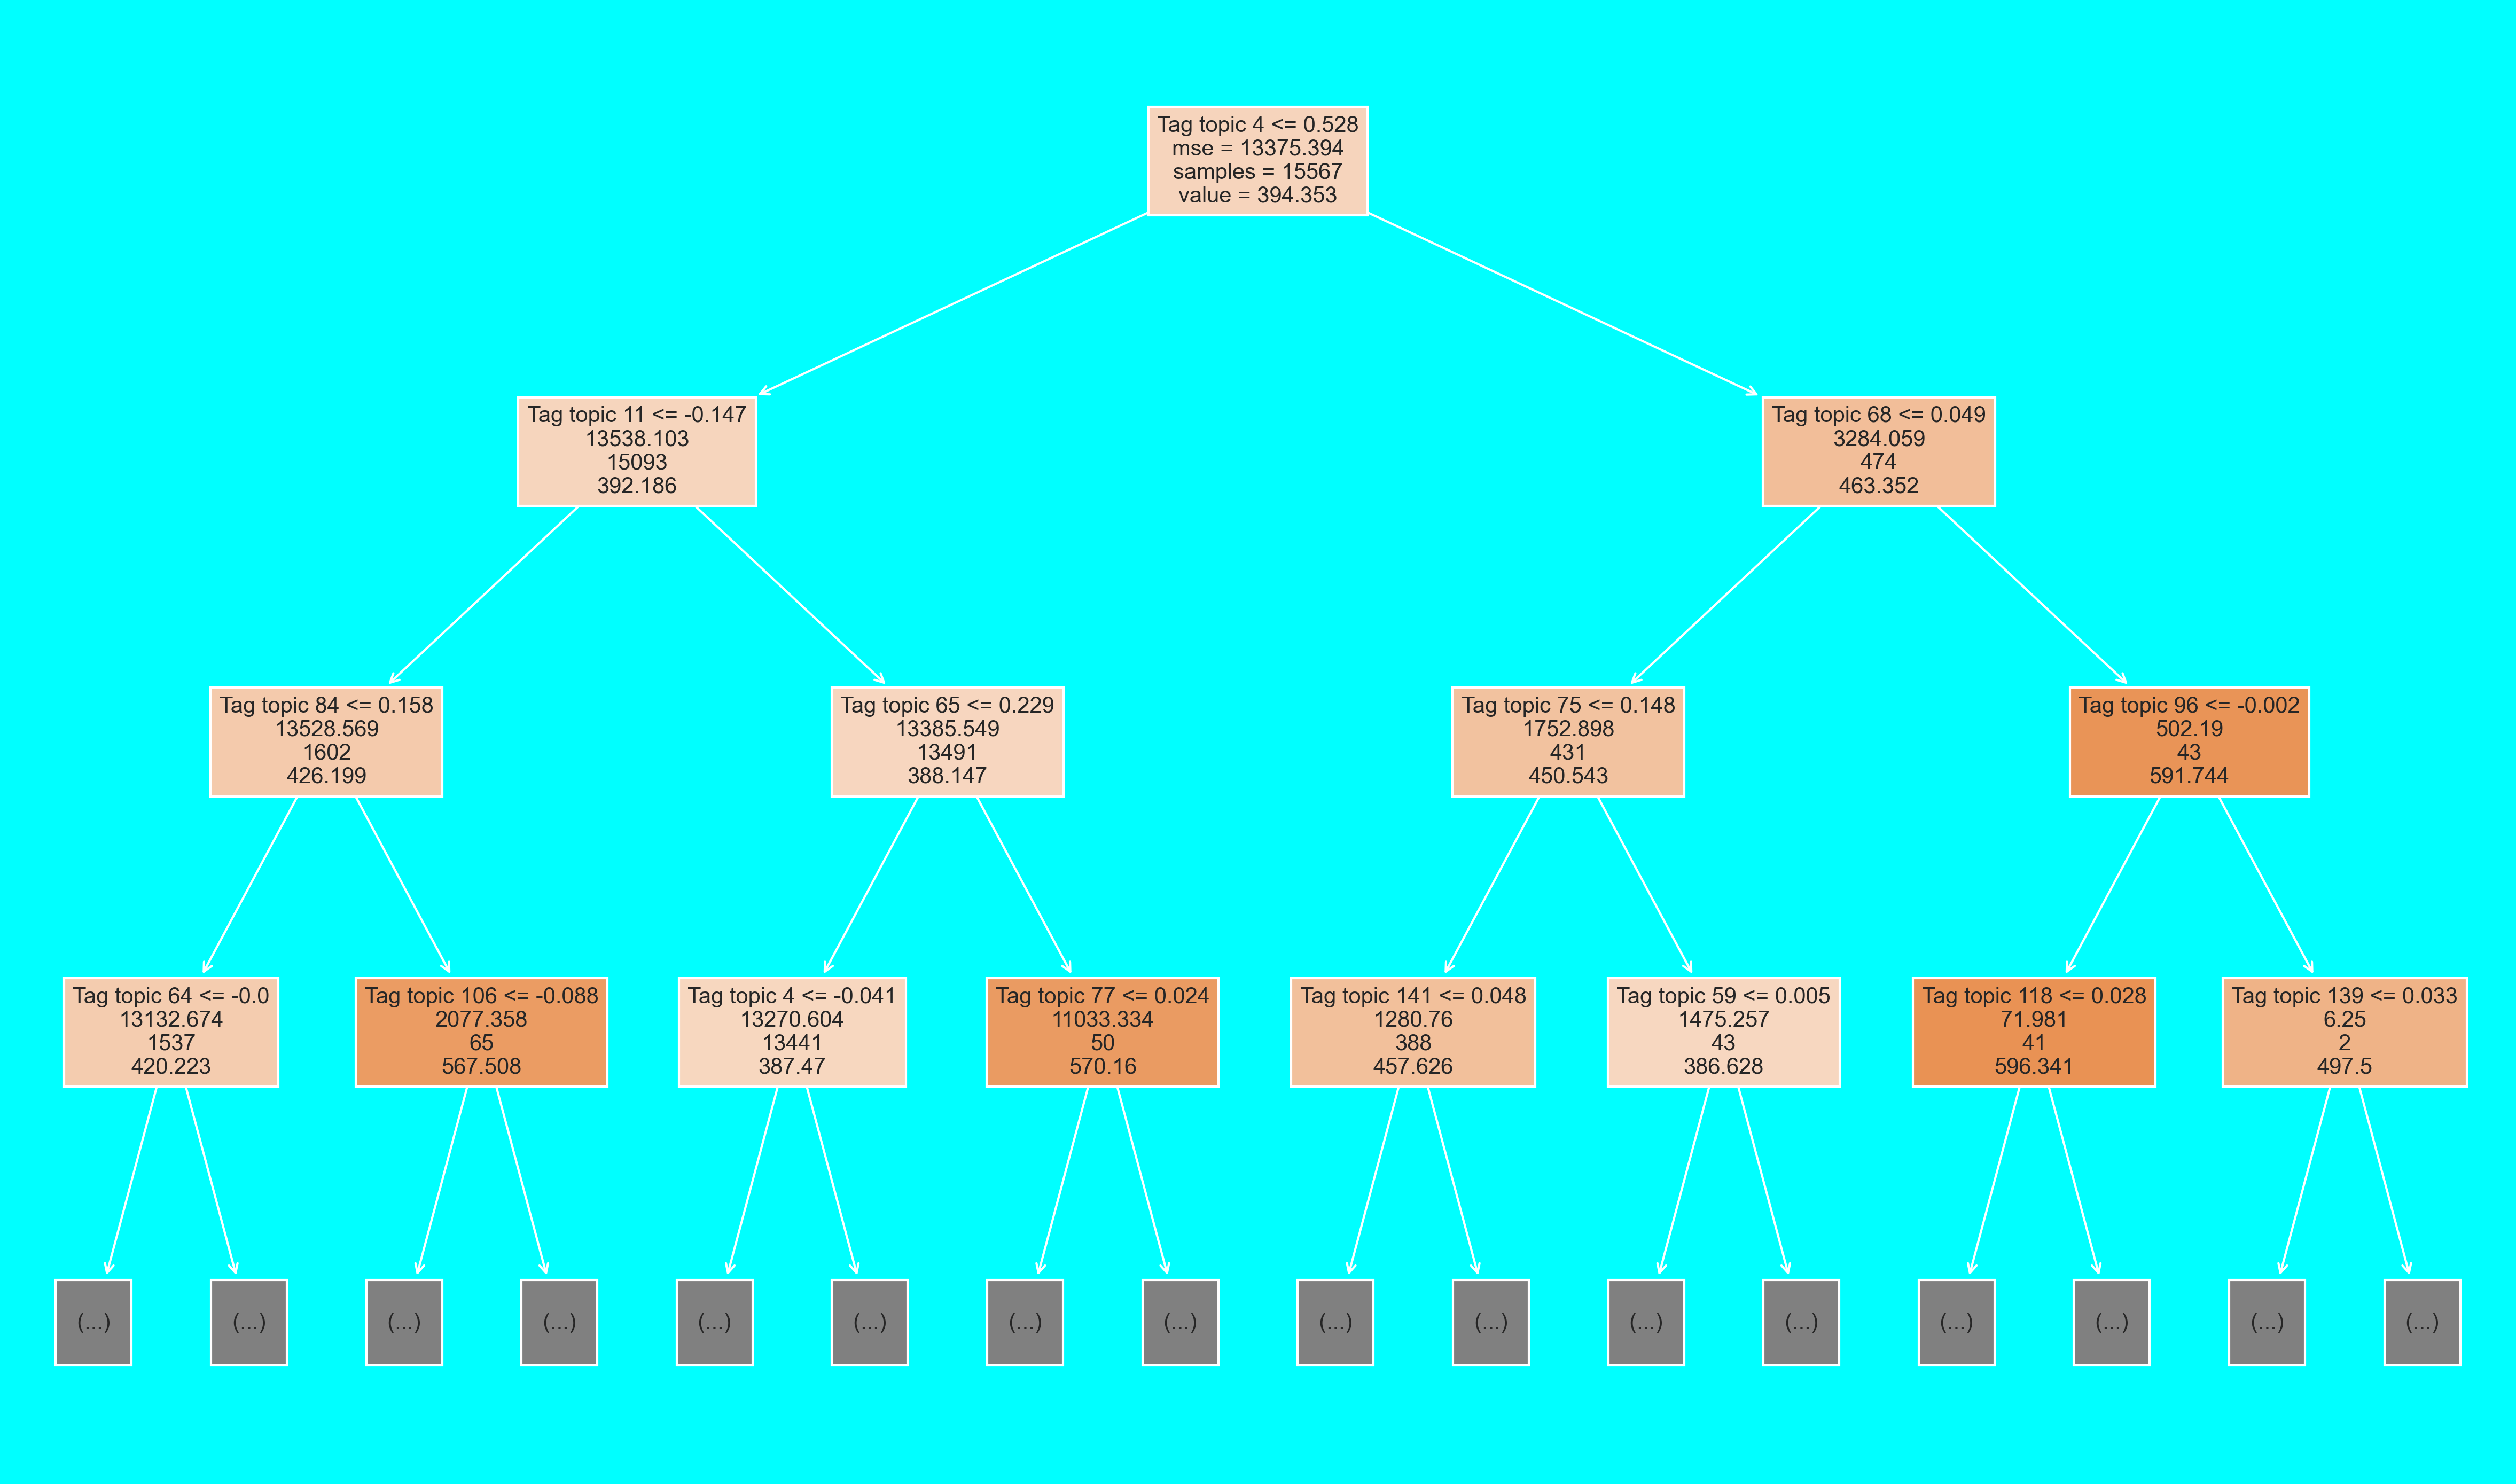

In [496]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(tags_union_SVD_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_all_tag_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_tags_union_after_tfidf_SVD.png')

### 7c) Random forest model of SVD-reduced combinations of tags of all 3 types

In [497]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')



In [498]:
# #I need a FetureUnion of the three :
# from sklearn.pipeline import FeatureUnion

# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])


In [499]:
# #Check that I can train this FeatureUnion
#tags_info_union.fit(paintings_df_train)

In [500]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD

tags_union_SVD_rforest_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=150)),
    ('rforest', RandomForestRegressor(n_estimators=150,max_features='sqrt',n_jobs=2,max_depth=tags_union_SVD_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [501]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_union_SVD_rforest_pipe_filename = './Git_exclude/models/tags_union_SVD_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_union_SVD_rforest_pipe_filename, 'rb') as f:
        tags_union_SVD_rforest_pipe = load(f)
        print('Loaded joblib file with random forest using SVD-reduced tags (general+style+materials).')
except: #if not, actually perform the fit then save the model for next time:
    
    tags_union_SVD_rforest_pipe.fit(paintings_df_train,prices_train);
    
    with open(tags_union_SVD_rforest_pipe_filename, 'wb') as f:
        dump(tags_union_SVD_rforest_pipe, tags_union_SVD_rforest_pipe_filename) 
        print('Saved joblib file with random forest using SVD-reduced tags (general+style+materials).')

Loaded joblib file with random forest using SVD-reduced tags (general+style+materials).


In [502]:
#Predict prices on training set:
prices_train_pred = tags_union_SVD_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_union_SVD_rforest_pipe.score(paintings_df_train,prices_train)

0.12973602769071135

In [503]:
#Predict prices on test set:
prices_test_pred = tags_union_SVD_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_union_SVD_rforest_pipe.score(paintings_df_test,prices_test)

0.09337003244158237

In [504]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using all tags (after Tf-Idf and SVD reduction)')


Random Forest model using all tags (after Tf-Idf and SVD reduction):
Training R^2: 0.12973602769071135
Testing R^2: 0.09337003244158237
Training RMSE: USD 107.88940484144493
Testing RMSE: USD 109.97973089718951
Training MAE: USD 90.30185747432803
Testing MAE: USD 92.49092606955485


In [505]:
#what are the main features used for decision?
tags_union_SVD_rforest_pipe['rforest'].feature_importances_

array([0.01177204, 0.0139295 , 0.00558935, 0.00685672, 0.04535988,
       0.01228691, 0.00369674, 0.00921476, 0.00622772, 0.008916  ,
       0.00629181, 0.02314255, 0.01183861, 0.01014952, 0.00641414,
       0.01219424, 0.0161529 , 0.00621547, 0.00420067, 0.00652165,
       0.01132002, 0.0065861 , 0.00846147, 0.00836062, 0.00467697,
       0.01219419, 0.01296572, 0.00447295, 0.0057593 , 0.00870618,
       0.00582244, 0.00544024, 0.01194309, 0.0046419 , 0.00758573,
       0.00365654, 0.00546376, 0.00923847, 0.00578745, 0.00428563,
       0.01740025, 0.00440522, 0.00671291, 0.00373878, 0.00477405,
       0.00529108, 0.00615819, 0.00345141, 0.00418375, 0.00319614,
       0.00495377, 0.00288168, 0.0070142 , 0.00625992, 0.01727569,
       0.00411178, 0.00450655, 0.00721506, 0.00508749, 0.00807113,
       0.00293581, 0.00564268, 0.00582357, 0.00590865, 0.01499997,
       0.01191752, 0.00505698, 0.00445909, 0.00859402, 0.00495296,
       0.00389543, 0.00364139, 0.00483763, 0.00651849, 0.00309

In [506]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [507]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(tags_union_SVD_rforest_pipe['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

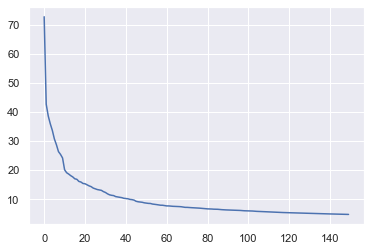

In [508]:
# Get Singular values and Components 
Sigma = tags_union_SVD_rforest_pipe['SVD'].singular_values_ 
plt.plot(Sigma)

In [509]:
#Which are the most predictive 'topics' in the decision tree?

In [510]:
#What are the style words or word combos that are used most by the tree regressor?
tags_union_rforest_SVD_features_imp_df = pd.DataFrame(tags_union_SVD_rforest_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
tags_union_rforest_SVD_features_imp_df['Topic']=pd.Series(list_of_all_tag_topics)
tags_union_rforest_SVD_features_imp_df = tags_union_rforest_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
tags_union_rforest_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
4                     0.045360   
84                    0.028524   
11                    0.023143   
96                    0.018776   
79                    0.018217   
40                    0.017400   
54                    0.017276   
16                    0.016153   
64                    0.015000   
80                    0.014336   
1                     0.013930   
26                    0.012966   
5                     0.012287   
15                    0.012194   
25                    0.012194   
32                    0.011943   
65                    0.011918   
12                    0.011839   
0                     0.011772   
20                    0.011320   

                                                Topic  
4     [paper(-0.69), canvas board(0.22), board(0.21)]  
84   [acrylic(0.24), metal(-0.22), art vintage(0.18)]  
11  [beach(0.54), impressionism(-0.47), contempora...  
96  [victorian(0.35), impressionism modern(-0.27),...  
79  [beach landscape(0.45), oils canvas(-0.22), oi...  
40  [impressionistic(0.66), modern(0.26), paint ca...  
54  [art deco(-0.18), deco(-0.18), modern vintage(...  
16  [impressionist(-0.39), pop(-0.36), pop art(-0....  
64  [impressionism landscape(0.48), retro(0.35), p...  
80   [oils canvas(0.35), oils(0.35), landscape(0.19)]  
1   [abstract(0.74), stretched canvas(-0.28), stre...  
26  [wildlife(0.62), watercolor(0.4), realism(-0.34)]  
5   [paper(-0.44), landscape(0.41), wood hardboard...  
15  [vintage(0.72), impressionism(0.2), seascape(0...  
25  [realism(0.67), watercolor(0.44), watercolor p...  
32        [oil canvas(-0.5), nautical(0.3), on(0.24)]  
65  [impressionism landscape(0.51), minimalism(-0....  
12  [impressionism(0.58), acrylic(0.31), beach(0.31)]  
0   [stretched canvas(0.55), stretched(0.55), canv...  
20          [fantasy(0.44), air(-0.28), plein(-0.28)]

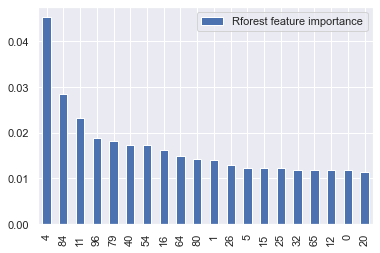

In [511]:
tags_union_rforest_SVD_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

### 7d) Gradient boosting model of SVD-reduced combinations of tags of all 3 types

In [512]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')



In [513]:
# #I need a FetureUnion of the three :
# from sklearn.pipeline import FeatureUnion

# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])


In [514]:
# #Check that I can train this FeatureUnion
#tags_info_union.fit(paintings_df_train)

In [515]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD

tags_union_SVD_gboost_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=150)),
    #('gboost', GradientBoostingRegressor(n_estimators=150,learning_rate=0.1,subsample=0.75,max_depth=3,random_state=1))
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=tags_union_SVD_dtree_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
    #('gboost', GradientBoostingRegressor(n_estimators=150,learning_rate=0.1,subsample=0.5,max_depth=tags_union_SVD_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [516]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_union_SVD_gboost_pipe_filename = './Git_exclude/models/tags_union_SVD_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_union_SVD_gboost_pipe_filename, 'rb') as f:
        tags_union_SVD_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting using SVD-reduced tags (general+style+materials).')
except: #if not, actually perform the fit then save the model for next time:
    
    tags_union_SVD_gboost_pipe.fit(paintings_df_train,prices_train);
    
    with open(tags_union_SVD_gboost_pipe_filename, 'wb') as f:
        dump(tags_union_SVD_gboost_pipe, tags_union_SVD_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting using SVD-reduced tags (general+style+materials).')

Loaded joblib file with gradient boosting using SVD-reduced tags (general+style+materials).


In [517]:
#Predict prices on training set:
prices_train_pred = tags_union_SVD_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_union_SVD_gboost_pipe.score(paintings_df_train,prices_train)

0.18813957235473022

In [518]:
#Predict prices on test set:
prices_test_pred = tags_union_SVD_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_union_SVD_gboost_pipe.score(paintings_df_test,prices_test)

0.1208063125689619

In [519]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using all tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using all tags (after Tf-Idf and SVD reduction):
Training R^2: 0.18813957235473022
Testing R^2: 0.1208063125689619
Training RMSE: USD 104.20630136991521
Testing RMSE: USD 108.30285324380215
Training MAE: USD 86.09470296623351
Testing MAE: USD 89.9866056989012


In [520]:
#what are the main features used for decision?
tags_union_SVD_gboost_pipe['gboost'].feature_importances_

array([1.23724689e-02, 1.71984274e-02, 2.35696444e-03, 7.41689297e-03,
       6.08316404e-02, 7.40125577e-03, 5.37552878e-03, 1.14629528e-02,
       1.25615424e-02, 5.65224676e-03, 9.50131811e-03, 2.81325608e-02,
       6.34040956e-03, 3.98318770e-03, 6.59219065e-03, 7.41846346e-03,
       7.61040811e-03, 8.79420868e-03, 5.05046311e-03, 2.36388703e-03,
       6.15165730e-03, 4.87349161e-03, 1.13377069e-02, 2.17654980e-02,
       1.36044164e-03, 1.18850512e-02, 5.12668418e-03, 9.15065911e-03,
       6.94603909e-03, 1.08750869e-02, 5.76860460e-03, 2.63196447e-03,
       6.20645132e-03, 2.52163233e-03, 3.88037737e-03, 1.02423625e-02,
       6.92794665e-03, 8.86261424e-03, 2.21066611e-03, 1.13724407e-03,
       9.12303214e-03, 3.70009696e-03, 6.45424949e-03, 1.72086325e-03,
       6.32135168e-03, 1.74793945e-03, 5.94737224e-03, 8.59545284e-03,
       1.73984714e-03, 6.90347320e-03, 1.09092035e-03, 2.38058008e-03,
       1.25559971e-02, 1.10518823e-03, 1.51210923e-02, 1.21777562e-03,
      

In [521]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [522]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(tags_union_SVD_gboost_pipe['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

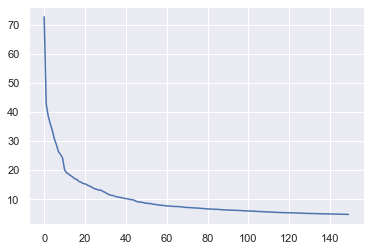

In [523]:
# Get Singular values and Components 
Sigma = tags_union_SVD_gboost_pipe['SVD'].singular_values_ 
plt.plot(Sigma)

In [524]:
#Which are the most predictive 'topics' in the boosting tree?

In [525]:
#What are the style words or word combos that are used most by the tree regressor?
tags_union_gboost_SVD_features_imp_df = pd.DataFrame(tags_union_SVD_gboost_pipe['gboost'].feature_importances_,columns=['Gboosting feature importance'])
tags_union_gboost_SVD_features_imp_df['Topic']=pd.Series(list_of_all_tag_topics)
tags_union_gboost_SVD_features_imp_df = tags_union_gboost_SVD_features_imp_df.sort_values(by='Gboosting feature importance',ascending=False)
tags_union_gboost_SVD_features_imp_df.iloc[:20]

Gboosting feature importance  \
4                        0.060832   
84                       0.034563   
11                       0.028133   
23                       0.021765   
96                       0.020820   
64                       0.019672   
1                        0.017198   
65                       0.015918   
54                       0.015121   
59                       0.013361   
79                       0.013194   
135                      0.013084   
8                        0.012562   
52                       0.012556   
146                      0.012458   
0                        0.012372   
25                       0.011885   
91                       0.011836   
132                      0.011749   
130                      0.011699   

                                                 Topic  
4      [paper(-0.69), canvas board(0.22), board(0.21)]  
84    [acrylic(0.24), metal(-0.22), art vintage(0.17)]  
11   [beach(0.54), impressionism(-0.47), contempora...  
23   [acrylic canvas(0.39), paint(-0.33), paint can...  
96   [victorian(0.34), impressionism modern(-0.27),...  
64   [impressionism landscape(0.48), retro(0.35), p...  
1    [abstract(0.74), stretched canvas(-0.28), stre...  
65   [impressionism landscape(0.51), minimalism(-0....  
54   [modern vintage(0.18), art deco(-0.18), deco(-...  
59   [retro(0.35), expressionism abstract(0.25), pa...  
79   [beach landscape(0.45), oils canvas(-0.22), oi...  
135  [beach seascape(0.4), landscape modern(-0.23),...  
8    [portrait(0.54), canvas board(-0.36), board(-0...  
52   [realistic(0.59), minimalist(-0.22), wrapped(0...  
146     [goth(0.26), air landscape(0.2), mature(0.19)]  
0    [stretched canvas(0.55), stretched(0.55), canv...  
25   [realism(0.67), watercolor(0.44), watercolor p...  
91   [metal(0.39), cardboard(-0.28), watercolor pap...  
132  [romantic(0.29), beach abstract(-0.22), landsc...  
130    [romantic(0.41), goth(-0.29), historical(0.17)]

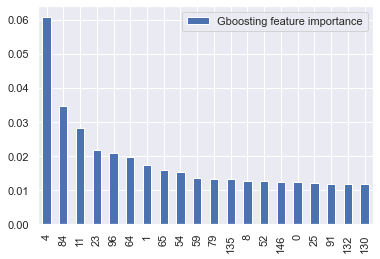

In [526]:
tags_union_gboost_SVD_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

## 8) Models combining all numerical, categorical and tags features (thus only missing image information) 

#### Model 8a) Ridge Regression combining numerical, categorical and all tags features

In [527]:
#Recall that:

#For Ridge Regression, I don't really need to 'drop-first' categorical variables when doing OneHotEncoding, because the ridge term already prevents the problem from being ill-posed  
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)

# variable_selector_for_ridge = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical',MinMaxScaler(),numerical_columns)
#  ], remainder='drop')

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')

# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])

In [528]:
# #I need a FetureUnion of the tags preprocessed data and the numerical+categorical preprocessed data, before applying Ridge regression:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD

tags_union_preprocessing_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=500))
    ])

num_plus_cat_ridge_preprocessing_pipe = Pipeline([
    ('num and cat preproc', variable_selector_for_ridge),
    ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)), 
    ])

num_cat_tags_ridge_union = FeatureUnion([("num and cat", num_plus_cat_ridge_preprocessing_pipe),
                                   ("all tags", tags_union_preprocessing_pipe)
                                   ])
                     

In [529]:
from sklearn.linear_model import Ridge

num_cat_tags_ridge_pipe = Pipeline([
    ('num cat tags preprocessing', num_cat_tags_ridge_union),
    ('ridge',Ridge(alpha=10))
])

In [530]:
#num_cat_tags_ridge_pipe.get_params()

In [531]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.logspace(-1,2,10), 'num cat tags preprocessing__all tags__SVD__n_components': range(100,600,50)} 
num_cat_tags_ridge_CVmodel = RandomizedSearchCV(num_cat_tags_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
#num_cat_tags_ridge_CVmodel = GridSearchCV(num_cat_tags_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [532]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_cat_tags_ridge_CVmodel_filename = './Git_exclude/models/num_cat_tags_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_cat_tags_ridge_CVmodel_filename, 'rb') as f:
        num_cat_tags_ridge_CVmodel = load(f)
        print('Loaded joblib file with ridge regression model for numerical-plus-categorical-plus-tags features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_cat_tags_ridge_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_cat_tags_ridge_CVmodel_filename, 'wb') as f:
        dump(num_cat_tags_ridge_CVmodel, num_cat_tags_ridge_CVmodel_filename) 
        print('Saved joblib file with ridge regression model for numerical-plus-categorical-plus-tags features.')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 22.5min finished


Saved joblib file with ridge regression model for numerical-plus-categorical-plus-tags features.


In [533]:
num_cat_tags_ridge_CVmodel.best_params_

{'ridge__alpha': 1.0,
 'num cat tags preprocessing__all tags__SVD__n_components': 550}

In [534]:
#Predict prices on training set:
prices_train_pred = num_cat_tags_ridge_CVmodel.predict(paintings_df_train)

In [535]:
#And return the R2 score as follows:
num_cat_tags_ridge_CVmodel.score(paintings_df_train,prices_train)

0.2752034803642718

In [536]:
#Predict prices on test set:
prices_test_pred = num_cat_tags_ridge_CVmodel.predict(paintings_df_test)

In [537]:
#And return the R2 score as follows:
num_cat_tags_ridge_CVmodel.score(paintings_df_test,prices_test)

0.2262282904075299

In [538]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using all data (numerical+categorical+tags(SVD-reduced))')

Ridge regression model using all data (numerical+categorical+tags(SVD-reduced)):
Training R^2: 0.2752034803642718
Testing R^2: 0.2262282904075299
Training RMSE: USD 98.46034306279476
Testing RMSE: USD 101.60241742743915
Training MAE: USD 78.5574892463976
Testing MAE: USD 81.24161732630203


In [539]:
#Here I will need to add the code to visualize the most important features based on the regression coefficients

In [544]:
feature_names_num_plus_cat_ridge = num_cat_tags_ridge_CVmodel.best_estimator_['num cat tags preprocessing'].transformer_list[0][1].named_steps['polynomial_trans'].get_feature_names()

In [547]:
feature_names_num_plus_cat_ridge[:35]

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x12',
 'x0 x13',
 'x0 x14',
 'x0 x15']

In [548]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [549]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(num_cat_tags_ridge_CVmodel.best_estimator_['num cat tags preprocessing'].transformer_list[1][1].named_steps['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

In [550]:
list_of_all_feature_names = feature_names_num_plus_cat_ridge + list_of_all_tag_topic_num_names

In [551]:
len(list_of_all_feature_names)

2089

In [553]:
len(num_cat_tags_ridge_CVmodel.best_estimator_['ridge'].coef_)

2089

In [554]:
#Which are the largest regression coefficients in the regression model?
num_cat_tags_ridge_reg_coeff_df = pd.DataFrame(num_cat_tags_ridge_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
num_cat_tags_ridge_reg_coeff_df['Feature']=pd.Series(list_of_all_feature_names)
num_cat_tags_ridge_reg_coeff_df = num_cat_tags_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
num_cat_tags_ridge_reg_coeff_df.iloc[:10]

Regression coefficients        Feature
1114               172.262898      x6 x8 x13
1731               142.689375  Tag topic 192
1874               138.836900  Tag topic 335
343                138.130950      x0 x8 x18
1655               135.553258  Tag topic 116
1840               132.992821  Tag topic 301
188                132.076384          x13^2
15                 122.722677            x15
1260               121.792953       x8^2 x15
150                121.792953         x8 x15

In [555]:
num_cat_tags_ridge_reg_coeff_df.iloc[-10:]

Regression coefficients        Feature
1045              -111.372865     x5 x10 x16
1300              -114.240110     x8 x13 x15
1804              -115.141982  Tag topic 265
1846              -124.471134  Tag topic 307
1714              -128.003248  Tag topic 175
1800              -129.208813  Tag topic 261
1529              -136.794229          x16^3
2085              -140.457887  Tag topic 546
1334              -146.792413     x9 x10 x15
1756              -152.026308  Tag topic 217

In [556]:
#I need a legend for what the tag topics are and what the x0-x15 variables are

In [557]:
pd.set_option('display.max_colwidth', 200)
tag_topics_legend_df = pd.DataFrame(pd.Series(list_of_all_tag_topics),columns=['Tag topic components (Truncated SVD)']) 
tag_topics_legend_df['Tag topic']=pd.Series(list_of_all_tag_topic_num_names)
tag_topics_legend_df.set_index('Tag topic').head()

Tag topic components (Truncated SVD)
Tag topic                                                                  
Tag topic 0         [stretched canvas(0.55), stretched(0.55), canvas(0.43)]
Tag topic 1     [abstract(0.74), stretched canvas(-0.28), stretched(-0.27)]
Tag topic 2                 [landscape(0.63), abstract(-0.44), paper(0.36)]
Tag topic 3  [landscape(-0.53), contemporary(0.44), contemporary art(0.43)]
Tag topic 4                 [paper(-0.69), canvas board(0.22), board(0.21)]

In [559]:
num_cat_tags_ridge_reg_coeff_df_ext = num_cat_tags_ridge_reg_coeff_df.merge(tag_topics_legend_df,how='outer',left_on='Feature',right_on='Tag topic').sort_values(by='Regression coefficients',ascending=False)
num_cat_tags_ridge_reg_coeff_df_ext.iloc[:12].set_index('Feature').drop(['Tag topic'],axis=1)

Regression coefficients  \
Feature                                  
x6 x8 x13                   172.262898   
Tag topic 192               142.689375   
Tag topic 335               138.836900   
x0 x8 x18                   138.130950   
Tag topic 116               135.553258   
Tag topic 301               132.992821   
x13^2                       132.076384   
x15                         122.722677   
x8^2 x15                    121.792953   
x8 x15                      121.792953   
x10 x13^2                   120.869661   
Tag topic 525               119.933658   

                                                      Tag topic components (Truncated SVD)  
Feature                                                                                     
x6 x8 x13                                                                              NaN  
Tag topic 192         [contemporary contemporary(0.15), cotton(0.14), cotton canvas(0.14)]  
Tag topic 335           [canvas stretched(-0.16), color(0.15), traditional abstract(0.13)]  
x0 x8 x18                                                                              NaN  
Tag topic 116                [floral abstract(0.19), landscape(-0.17), canvas paint(0.16)]  
Tag topic 301  [acrylic wood(0.15), contemporary seascape(0.15), realism landscape(-0.13)]  
x13^2                                                                                  NaN  
x15                                                                                    NaN  
x8^2 x15                                                                               NaN  
x8 x15                                                                                 NaN  
x10 x13^2                                                                              NaN  
Tag topic 525                 [traditional rustic(0.11), rose(0.11), decor abstract(-0.1)]

In [560]:
num_cat_tags_ridge_reg_coeff_df_ext.iloc[-12:].set_index('Feature').drop(['Tag topic'],axis=1)

Regression coefficients  \
Feature                                  
x0 x14^2                   -107.543105   
x0 x13 x17                 -108.514785   
x5 x10 x16                 -111.372865   
x8 x13 x15                 -114.240110   
Tag topic 265              -115.141982   
Tag topic 307              -124.471134   
Tag topic 175              -128.003248   
Tag topic 261              -129.208813   
x16^3                      -136.794229   
Tag topic 546              -140.457887   
x9 x10 x15                 -146.792413   
Tag topic 217              -152.026308   

                                                                Tag topic components (Truncated SVD)  
Feature                                                                                               
x0 x14^2                                                                                         NaN  
x0 x13 x17                                                                                       NaN  
x5 x10 x16                                                                                       NaN  
x8 x13 x15                                                                                       NaN  
Tag topic 265                                 [glass(0.25), traditional modern(-0.15), nature(0.14)]  
Tag topic 307          [lake(0.16), impressionist floral(-0.16), expressionism expressionist(-0.16)]  
Tag topic 175  [impressionist impressionism(0.25), contemporary contemporary(0.25), primitive(0.25)]  
Tag topic 261                            [americana(0.33), water(0.15), impressionism floral(-0.14)]  
x16^3                                                                                            NaN  
Tag topic 546                      [charcoal(0.11), abstract expressionism(-0.1), beach boho(-0.09)]  
x9 x10 x15                                                                                       NaN  
Tag topic 217        [painting abstract(0.19), impressionism contemporary(0.17), art painting(0.16)]

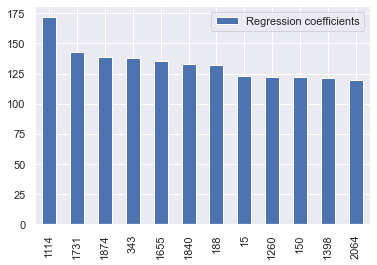

In [563]:
num_cat_tags_ridge_reg_coeff_df.iloc[:12].plot(kind="bar").legend(loc="upper right");

In [ ]:
#I could try to also extract the names of the variables x1, ..., x15 but it would be a bit convoluted and wouldn't make it much more interpretable given the polynomial terms

#### Model 8b) Decision Tree combining numerical, categorical and all tags features

In [623]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')

# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])

In [509]:
# #I need a FetureUnion of the tags preprocessed data and the numerical+categorical preprocessed data, before applying Random Forest regression:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD

tags_union_preprocessing_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=150))
    ])

num_plus_cat_preprocessing_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ])

num_cat_tags_union = FeatureUnion([("num and cat", num_plus_cat_preprocessing_pipe),
                                   ("all tags", tags_union_preprocessing_pipe)
                                   ])
                     

In [511]:
from sklearn.tree import DecisionTreeRegressor

num_cat_tags_dtree_pipe = Pipeline([
    ('num cat tags preprocessing', num_cat_tags_union),
    ('dtree',DecisionTreeRegressor(max_depth=10))
])

In [512]:
from sklearn.model_selection import GridSearchCV #, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,16,1)} 
#num_cat_tags_dtree_CVmodel = RandomizedSearchCV(num_cat_tags_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=30)
num_cat_tags_dtree_CVmodel = GridSearchCV(num_cat_tags_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [ ]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_cat_tags_dtree_CVmodel_filename = './Git_exclude/models/num_cat_tags_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_cat_tags_dtree_CVmodel_filename, 'rb') as f:
        num_cat_tags_dtree_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for numerical-plus-categorical-plus-tags features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_cat_tags_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_cat_tags_dtree_CVmodel_filename, 'wb') as f:
        dump(num_cat_tags_dtree_CVmodel, num_cat_tags_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for numerical-plus-categorical-plus-tags features.')

In [518]:
num_cat_tags_dtree_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('num cat tags preprocessing',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'and '
                                                                        'cat',
                                                                        Pipeline(steps=[('num '
                                                                                         'and '
                                                                                         'cat '
                                                                                         'selector',
                                                                                         ColumnTransformer(transformers=[('categorical',
                                                                                                                          OneHotEncoder(),
                                                                                                                          ['painting_type',
                                                                                                                           'when_made']),
                                                                                                                         ('boolean',
                                                                                                                          'passthrough',
                                                                                                                          ['made_by_seller',
                                                                                                                           'is_customizable',
                                                                                                                           'has_variations']),
                                                                                                                         ('numerical',
                                                                                                                          '...
                                                                                                                         'tags '
                                                                                                                         'tf-idf',
                                                                                                                         ColumnTransformer(transformers=[('materials '
                                                                                                                                                          'tfidf',
                                                                                                                                                          Pipeline(steps=[('to '
                                                                                                                                                                           'single '
                                                                                                                                                                           'string',
                                                                                                                                                                           TagsEncoder()),
                                                                                                                                                                          ('to '
                                                                                                                                                                           'tfidf '
                                                                                                    

In [514]:
num_cat_tags_dtree_CVmodel.best_params_

{'dtree__max_depth': 5}

In [515]:
#Predict prices on training set:
prices_train_pred = num_cat_tags_dtree_CVmodel.predict(paintings_df_train)

In [516]:
#And return the R2 score as follows:
num_cat_tags_dtree_CVmodel.score(paintings_df_train,prices_train)

0.13353507031689993

In [519]:
#Predict prices on test set:
prices_test_pred = num_cat_tags_dtree_CVmodel.predict(paintings_df_test)

In [520]:
#And return the R2 score as follows:
num_cat_tags_dtree_CVmodel.score(paintings_df_test,prices_test)

0.13599421750152196

In [521]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using numerical + categorical + tags features')

Decision tree model using numerical + categorical + tags features:
Training R^2: 0.13353507031689993
Testing R^2: 0.13599421750152196
Training RMSE: USD 107.65365755226262
Testing RMSE: USD 107.36332234319443
Training MAE: USD 88.58521424757056
Testing MAE: USD 88.6255670348453


In [ ]:
# Get Singular values and Components 
Sigma = num_cat_tags_dtree_CVmodel.best_estimator_['SVD'].singular_values_ 
plt.plot(Sigma)

In [523]:
feature_names_num_plus_cat_dtree = num_cat_tags_dtree_CVmodel.best_estimator_['num cat tags preprocessing'].transformer_list[0][1].named_steps['num and cat selector'].get_feature_names()

In [524]:
feature_names_num_plus_cat_dtree[:5]

['categorical__x0_acrylic',
 'categorical__x0_more_than_one',
 'categorical__x0_oil',
 'categorical__x0_watercolor',
 'categorical__x1_made_2010s']

In [ ]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [ ]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(num_cat_tags_dtree_CVmodel.best_estimator_['num cat tags preprocessing'].transformer_list[1][1].named_steps['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

In [525]:
list_of_all_feature_names = feature_names_num_plus_cat_rforest + list_of_all_tag_topic_num_names

In [526]:
len(list_of_all_feature_names)

169

In [527]:
len(num_cat_tags_dtree_CVmodel.best_estimator_['dtree'].feature_importances_)

169

In [528]:
#Which are the most predictive features (numerical, categorical or tags-based) in the decision tree?
num_cat_tags_dtree_features_imp_df = pd.DataFrame(num_cat_tags_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
num_cat_tags_dtree_features_imp_df['Feature']=pd.Series(list_of_all_feature_names)
num_cat_tags_dtree_features_imp_df = num_cat_tags_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
num_cat_tags_dtree_features_imp_df.set_index('Feature').iloc[:20]

Dtree feature importance
Feature                                              
max_dimension                                0.520543
Tag topic 4                                  0.129413
Tag topic 84                                 0.088540
Tag topic 66                                 0.042531
area                                         0.034044
Tag topic 142                                0.032796
Tag topic 140                                0.028107
Tag topic 11                                 0.027495
Tag topic 1                                  0.024605
Tag topic 64                                 0.023227
Tag topic 105                                0.010779
Tag topic 81                                 0.009318
Tag topic 59                                 0.008129
days_from_original_creation                  0.008113
Tag topic 60                                 0.005166
Tag topic 57                                 0.004887
Tag topic 92                                 0.001149
Tag topic 102                                0.000611
Tag topic 0                                  0.000428
Tag topic 130                                0.000120

In [557]:
pd.set_option('display.max_colwidth', 200)
tag_topics_legend_df = pd.DataFrame(pd.Series(list_of_all_tag_topics),columns=['Tag topic components (Truncated SVD)']) 
tag_topics_legend_df['Tag topic']=pd.Series(list_of_all_tag_topic_num_names)
tag_topics_legend_df.set_index('Tag topic').head()

Tag topic components (Truncated SVD)
Tag topic                                                                  
Tag topic 0         [stretched canvas(0.55), stretched(0.55), canvas(0.43)]
Tag topic 1     [abstract(0.74), stretched canvas(-0.28), stretched(-0.27)]
Tag topic 2                 [landscape(0.63), abstract(-0.44), paper(0.36)]
Tag topic 3  [landscape(-0.53), contemporary(0.44), contemporary art(0.43)]
Tag topic 4                 [paper(-0.69), canvas board(0.22), board(0.21)]

In [559]:
num_cat_tags_dtree_features_imp_df_ext = num_cat_tags_dtree_features_imp_df.merge(tag_topics_legend_df,how='outer',left_on='Feature',right_on='Tag topic').sort_values(by='Dtree feature importance',ascending=False)
num_cat_tags_dtree_features_imp_df_ext.iloc[:12].set_index('Feature').drop(['Tag topic'],axis=1)

Dtree feature importance  \
Feature                                   
max_dimension                  0.520543   
Tag topic 4                    0.129413   
Tag topic 84                   0.088540   
Tag topic 66                   0.042531   
area                           0.034044   
Tag topic 142                  0.032796   
Tag topic 140                  0.028107   
Tag topic 11                   0.027495   
Tag topic 1                    0.024605   
Tag topic 64                   0.023227   
Tag topic 105                  0.010779   
Tag topic 81                   0.009318   

                                                 Tag topic components (Truncated SVD)  
Feature                                                                                
max_dimension                                                                     NaN  
Tag topic 4                           [paper(-0.69), canvas board(0.22), board(0.21)]  
Tag topic 84                         [acrylic(0.24), metal(-0.22), art vintage(0.17)]  
Tag topic 66                   [minimalism(-0.29), fabric(-0.29), southwestern(0.19)]  
area                                                                              NaN  
Tag topic 142       [landscape vintage(0.21), romantic(-0.19), beach seascape(-0.19)]  
Tag topic 140    [air landscape(-0.21), impressionist abstract(0.2), industrial(0.2)]  
Tag topic 11                  [beach(0.54), impressionism(-0.47), contemporary(0.28)]  
Tag topic 1               [abstract(0.74), stretched canvas(-0.28), stretched(-0.27)]  
Tag topic 64             [impressionism landscape(0.48), retro(0.35), painting(0.19)]  
Tag topic 105              [spooky(0.21), painting(0.2), portrait contemporary(0.19)]  
Tag topic 81   [african(0.34), abstract portrait(0.27), contemporary landscape(0.22)]

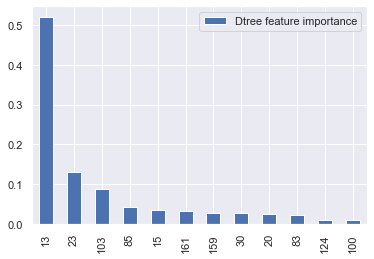

In [560]:
num_cat_tags_dtree_features_imp_df.iloc[:12].plot(kind="bar").legend(loc="upper right");

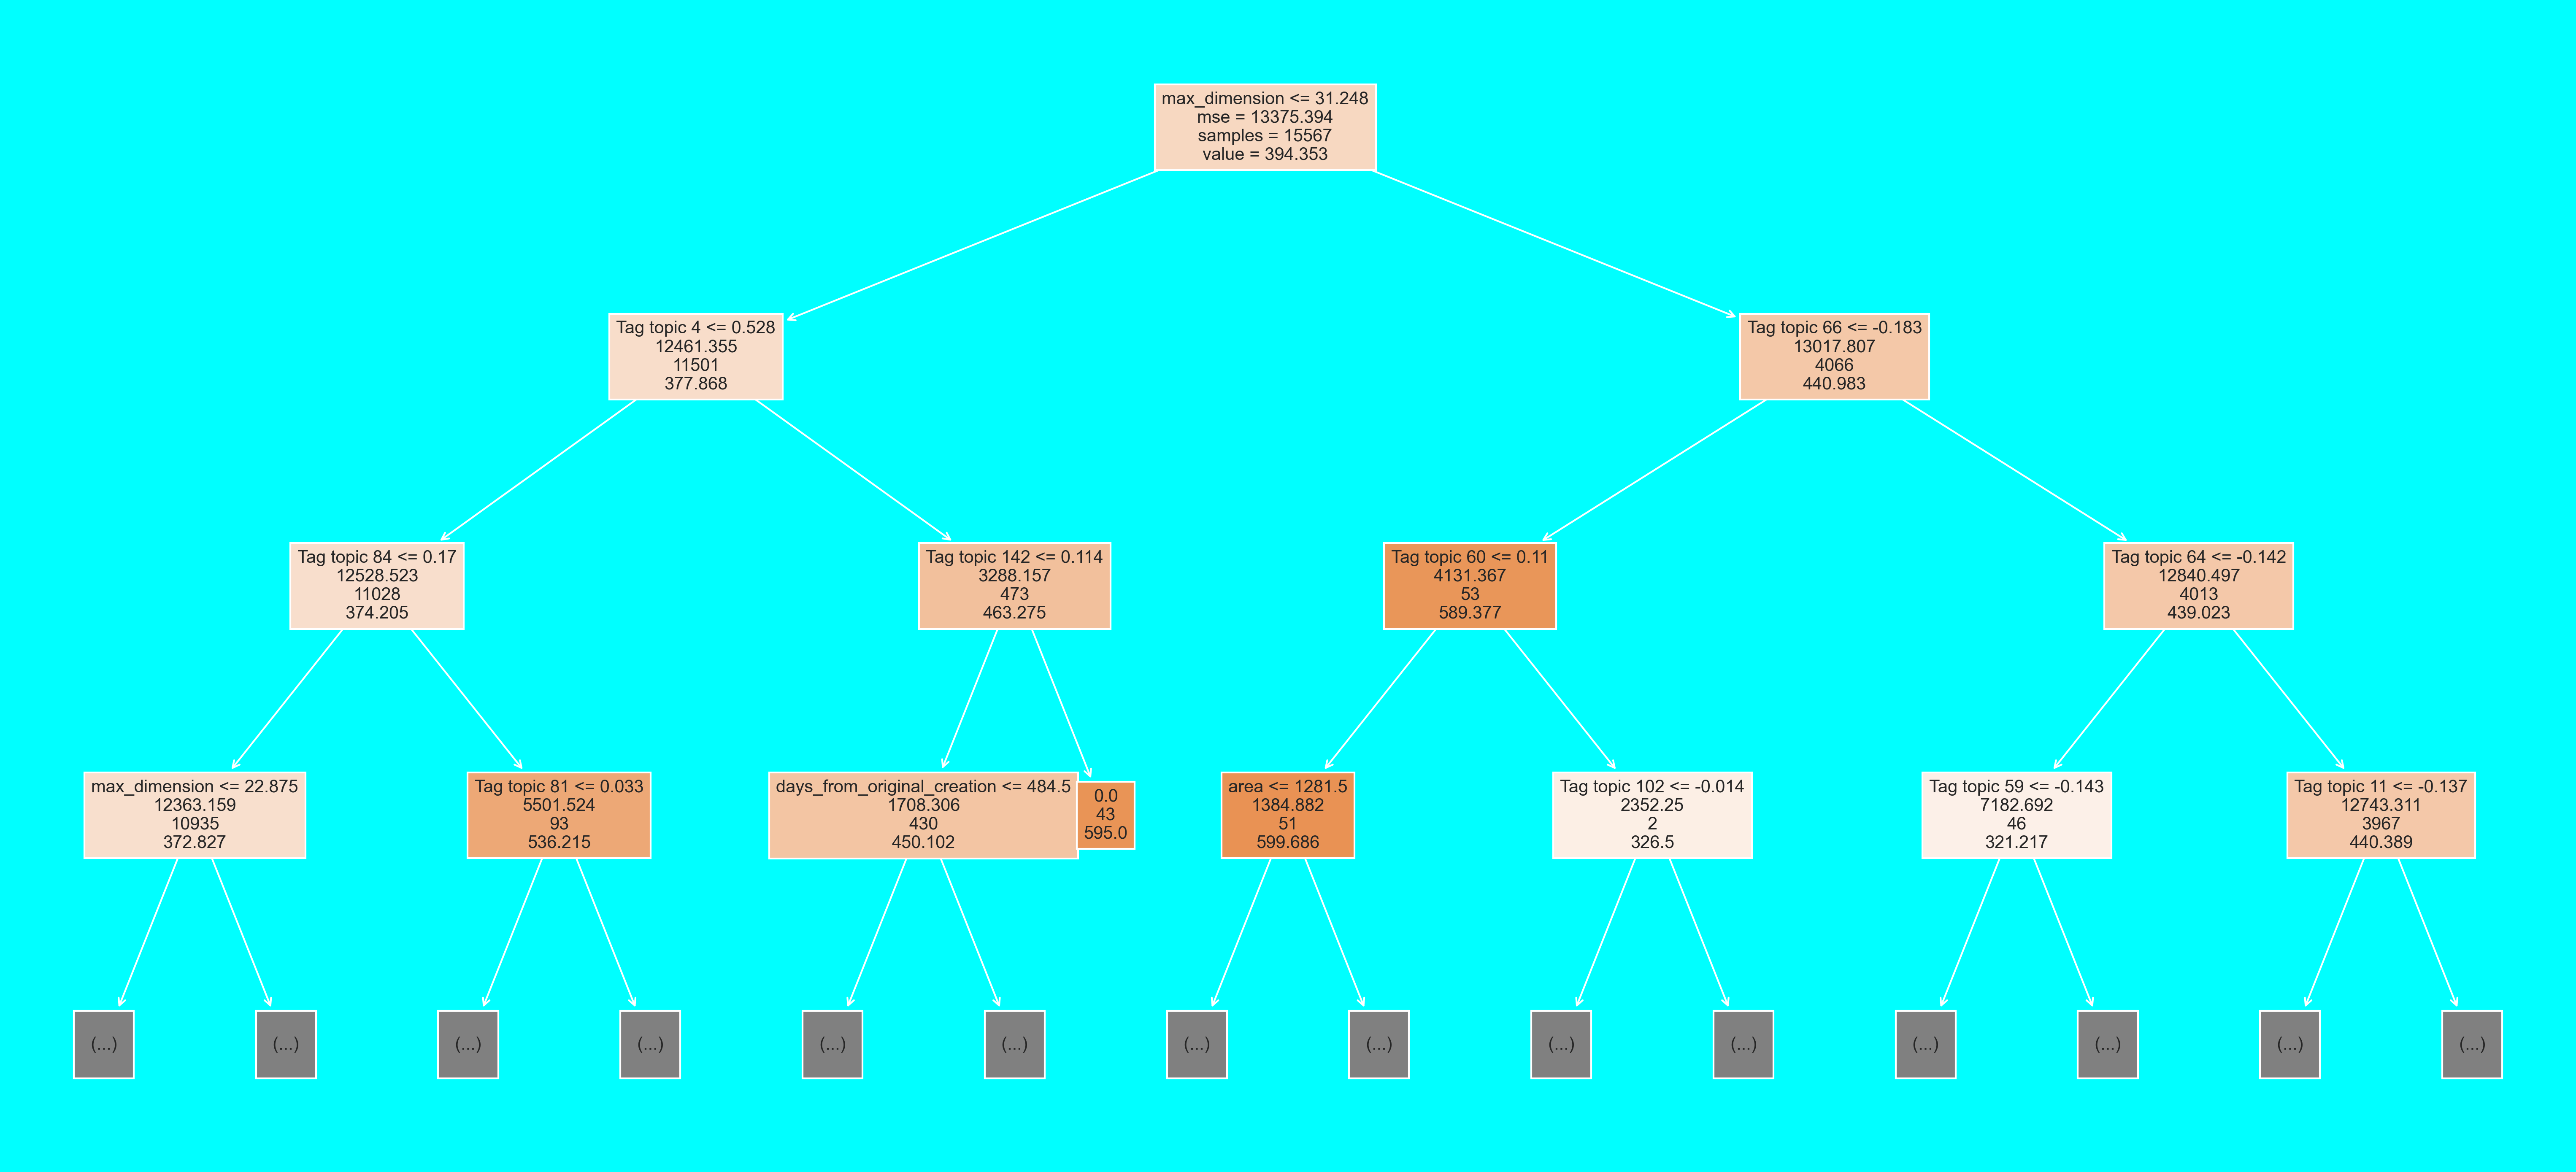

In [561]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(26,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(num_cat_tags_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_all_feature_names)
fig.savefig('./Git_exclude/Figures/decision_tree_num_cat_tags.png')

#### Model 8c) Random Forest combining numerical, categorical and all tags features

In [711]:
from sklearn.ensemble import RandomForestRegressor

In [623]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')

# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])

In [712]:
# #I need a FetureUnion of the tags preprocessed data and the numerical+categorical preprocessed data, before applying Random Forest regression:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD

tags_union_preprocessing_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=150))
    ])

num_plus_cat_preprocessing_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ])

num_cat_tags_union = FeatureUnion([("num and cat", num_plus_cat_preprocessing_pipe),
                                   ("all tags", tags_union_preprocessing_pipe)
                                   ])
                     

In [566]:
from sklearn.ensemble import RandomForestRegressor

max_depth_rforest = num_cat_tags_dtree_CVmodel.best_params_['dtree__max_depth']+1

num_cat_tags_rforest_pipe = Pipeline([
    ('num cat tags preprocessing', num_cat_tags_union),
    ('rforest', RandomForestRegressor(n_estimators=150,max_features='sqrt',n_jobs=2,max_depth=max_depth_rforest,random_state=1,max_samples=0.8)) #0.5))
])

In [214]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_cat_tags_rforest_pipe_filename = './Git_exclude/models/num_cat_tags_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_cat_tags_rforest_pipe_filename, 'rb') as f:
        num_cat_tags_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for numerical-plus-categorical-plus-tags features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_cat_tags_rforest_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_cat_tags_rforest_pipe_filename, 'wb') as f:
        dump(num_cat_tags_rforest_pipe, num_cat_tags_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for numerical-plus-categorical-plus-tags features.')

Loaded joblib file with random forest model for numerical-plus-categorical features.


In [568]:
#Predict prices on training set:
prices_train_pred = num_cat_tags_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_cat_tags_rforest_pipe.score(paintings_df_train,prices_train)

0.16050752757969655

In [569]:
#Predict prices on test set:
prices_test_pred = num_cat_tags_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_cat_tags_rforest_pipe.score(paintings_df_test,prices_test)

0.14565580087324803

In [725]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using numerical + categorical + tags features')


Random Forest model using numerical + categorical + tags features:
Training R^2: 0.42768510577988084
Testing R^2: 0.23329582184729303
Training RMSE: USD 87.49249859113264
Testing RMSE: USD 101.13734128755789
Training MAE: USD 71.41300747038282
Testing MAE: USD 82.76264604287611


In [727]:
#what are the main features used for decision?
num_cat_tags_rforest_pipe['rforest'].feature_importances_

array([0.00074231, 0.00050654, 0.00360393, 0.00264196, 0.00075323,
       0.00097812, 0.00086975, 0.00039561, 0.00062509, 0.00064489,
       0.00061807, 0.00370815, 0.00174607, 0.05478644, 0.0116809 ,
       0.04729408, 0.0275394 , 0.00648415, 0.00505075, 0.00668464,
       0.00825242, 0.00533566, 0.0056656 , 0.01435511, 0.00876252,
       0.00500784, 0.00680768, 0.00594618, 0.0072208 , 0.00727141,
       0.00755891, 0.00664924, 0.00727091, 0.00563507, 0.00579615,
       0.00719454, 0.00505577, 0.00531857, 0.00557544, 0.00641187,
       0.00602174, 0.00555618, 0.00698708, 0.00521261, 0.00673637,
       0.00541527, 0.00444213, 0.00526047, 0.00634921, 0.00559662,
       0.00546041, 0.00604847, 0.00465003, 0.00612195, 0.00486884,
       0.00619659, 0.00601123, 0.00575174, 0.00537698, 0.00609945,
       0.004091  , 0.00595124, 0.00429317, 0.00495752, 0.00479705,
       0.00520758, 0.00501986, 0.00471155, 0.00477201, 0.00530644,
       0.0044853 , 0.00553223, 0.00529406, 0.00654618, 0.00497

In [744]:
feature_names_num_plus_cat_rforest = num_cat_tags_rforest_pipe['num cat tags preprocessing'].transformer_list[0][1].named_steps['num and cat selector'].get_feature_names()

In [745]:
feature_names_num_plus_cat_rforest[:5]

['categorical__x0_acrylic',
 'categorical__x0_more_than_one',
 'categorical__x0_oil',
 'categorical__x0_watercolor',
 'categorical__x1_made_2010s']

In [746]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [749]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(num_cat_tags_rforest_pipe['num cat tags preprocessing'].transformer_list[1][1].named_steps['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

In [751]:
list_of_all_feature_names = feature_names_num_plus_cat_rforest + list_of_all_tag_topic_num_names

In [753]:
len(list_of_all_feature_names)

169

In [754]:
len(num_cat_tags_rforest_pipe['rforest'].feature_importances_)

169

In [760]:
num_cat_tags_rforest_features_imp_df = pd.DataFrame(num_cat_tags_rforest_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
num_cat_tags_rforest_features_imp_df['Feature']=pd.Series(list_of_all_feature_names)
num_cat_tags_rforest_features_imp_df = num_cat_tags_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
num_cat_tags_rforest_features_imp_df.set_index('Feature').iloc[:20]

Rforest feature importance
Feature                                  
max_dimension                    0.054786
area                             0.047294
weight                           0.027539
Tag topic 4                      0.014355
aspect_ratio                     0.011681
Tag topic 84                     0.008905
Tag topic 5                      0.008763
Tag topic 1                      0.008252
Tag topic 79                     0.007881
Tag topic 11                     0.007559
Tag topic 80                     0.007459
Tag topic 68                     0.007405
Tag topic 10                     0.007271
Tag topic 13                     0.007271
Tag topic 9                      0.007221
Tag topic 64                     0.007201
Tag topic 16                     0.007195
Tag topic 23                     0.006987
Tag topic 96                     0.006879
Tag topic 7                      0.006808

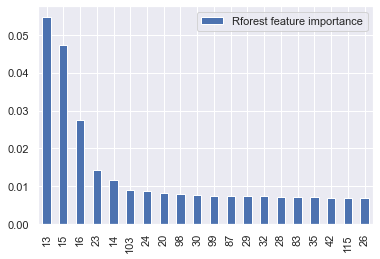

In [759]:
num_cat_tags_rforest_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

#### Model 8d) Gradient Boosted Trees combining numerical, categorical and tag features

In [ ]:
# Recall that I already defined:
# # #I need a FetureUnion of the tags preprocessed data and the numerical+categorical preprocessed data, before applying Random Forest regression:
# from sklearn.pipeline import FeatureUnion
# from sklearn.decomposition import TruncatedSVD

# tags_union_preprocessing_pipe = Pipeline([
#     ('all tags tfidf vectorization', tags_info_union),
#     ('SVD', TruncatedSVD(n_components=150))
#     ])

# num_plus_cat_preprocessing_pipe = Pipeline([
#     ('num and cat selector', variable_selector_for_trees),
#     ])

# num_cat_tags_union = FeatureUnion([("num and cat", num_plus_cat_preprocessing_pipe),
#                                    ("all tags", tags_union_preprocessing_pipe)
#                                    ])
                     

In [571]:
from sklearn.ensemble import GradientBoostingRegressor

max_depth_gboost = num_cat_tags_dtree_CVmodel.best_params_['dtree__max_depth']-2

num_cat_tags_gboost_pipe = Pipeline([
    ('num cat tags preprocessing', num_cat_tags_union),
    ('gboost', GradientBoostingRegressor(n_estimators=150,learning_rate=0.1,subsample=0.75,max_depth=max_depth_gboost,random_state=1)) 
])

#could also try: subsample = 0.5

In [572]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_cat_tags_gboost_pipe_filename = './Git_exclude/models/num_cat_tags_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_cat_tags_gboost_pipe_filename, 'rb') as f:
        num_cat_tags_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosted model for numerical-plus-categorical-plus-tags features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_cat_tags_gboost_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_cat_tags_gboost_pipe_filename, 'wb') as f:
        dump(num_cat_tags_gboost_pipe, num_cat_tags_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosted model for numerical-plus-categorical-plus-tags features.')

Saved joblib file with gradient boosted model for numerical-plus-categorical-plus-tags features.


In [573]:
#Predict prices on training set:
prices_train_pred = num_cat_tags_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_cat_tags_gboost_pipe.score(paintings_df_train,prices_train)

0.2906852919175449

In [574]:
#Predict prices on test set:
prices_test_pred = num_cat_tags_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_cat_tags_gboost_pipe.score(paintings_df_test,prices_test)

0.22427800096223394

In [575]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosted model using numerical + categorical + tags features')


Gradient Boosted model using numerical + categorical + tags features:
Training R^2: 0.2906852919175449
Testing R^2: 0.22427800096223394
Training RMSE: USD 97.40309966206217
Testing RMSE: USD 101.73038115062191
Training MAE: USD 79.48628950510953
Testing MAE: USD 83.40284322388118


In [576]:
#what are the main features used for decision?
num_cat_tags_gboost_pipe['gboost'].feature_importances_

array([0.00000000e+00, 1.03288266e-03, 1.80365313e-02, 0.00000000e+00,
       4.28457036e-03, 1.20310955e-03, 7.49091516e-04, 0.00000000e+00,
       4.36756801e-03, 4.54972556e-06, 0.00000000e+00, 2.94354683e-06,
       4.89945799e-03, 1.92411904e-01, 1.26075514e-02, 3.58345943e-02,
       3.89326055e-02, 7.65851846e-03, 3.11002197e-03, 6.48406350e-03,
       3.13503861e-03, 6.41930934e-03, 5.18778842e-03, 5.55018947e-02,
       3.27274977e-03, 6.22123243e-03, 3.98454970e-03, 2.84379672e-03,
       1.08636109e-03, 4.70347744e-03, 1.85822829e-02, 2.45238796e-03,
       4.24435006e-03, 3.45441138e-03, 2.76253047e-03, 1.54827316e-03,
       2.48782317e-03, 1.93420161e-03, 2.60871315e-03, 1.15777468e-02,
       3.97587834e-03, 4.05725624e-03, 1.46498459e-02, 9.63336291e-03,
       6.13064437e-03, 4.39672749e-03, 5.91387704e-03, 2.16782709e-03,
       5.39496143e-03, 7.64673574e-03, 7.13279335e-03, 2.31371647e-03,
       1.76219785e-03, 4.10823498e-03, 4.14318434e-03, 1.94259287e-03,
      

In [577]:
feature_names_num_plus_cat_gboost = num_cat_tags_gboost_pipe['num cat tags preprocessing'].transformer_list[0][1].named_steps['num and cat selector'].get_feature_names()

In [578]:
feature_names_num_plus_cat_gboost[:5]

['categorical__x0_acrylic',
 'categorical__x0_more_than_one',
 'categorical__x0_oil',
 'categorical__x0_watercolor',
 'categorical__x1_made_2010s']

In [579]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [580]:
list_of_all_tag_topics = []
list_of_all_tag_topic_num_names = []

for index, component in enumerate(num_cat_tags_gboost_pipe['num cat tags preprocessing'].transformer_list[1][1].named_steps['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tag_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_all_tag_topics.append(topic_tag_components)
    list_of_all_tag_topic_num_names.append("Tag topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tag_components) 

In [581]:
list_of_all_feature_names = feature_names_num_plus_cat_rforest + list_of_all_tag_topic_num_names

In [582]:
len(list_of_all_feature_names)

169

In [583]:
len(num_cat_tags_gboost_pipe['gboost'].feature_importances_)

169

In [584]:
num_cat_tags_gboost_features_imp_df = pd.DataFrame(num_cat_tags_gboost_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
num_cat_tags_gboost_features_imp_df['Feature']=pd.Series(list_of_all_feature_names)
num_cat_tags_gboost_features_imp_df = num_cat_tags_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
num_cat_tags_gboost_features_imp_df.set_index('Feature').iloc[:20]

Gboost feature importance
Feature                                       
max_dimension                         0.192412
Tag topic 4                           0.055502
weight                                0.038933
area                                  0.035835
Tag topic 84                          0.030362
Tag topic 64                          0.024429
Tag topic 11                          0.018582
categorical__x0_oil                   0.018037
Tag topic 23                          0.014650
aspect_ratio                          0.012608
Tag topic 20                          0.011578
Tag topic 79                          0.010666
Tag topic 125                         0.010019
Tag topic 52                          0.009864
Tag topic 144                         0.009803
Tag topic 24                          0.009633
Tag topic 91                          0.009577
Tag topic 57                          0.009524
Tag topic 85                          0.009507
Tag topic 147                         0.008114

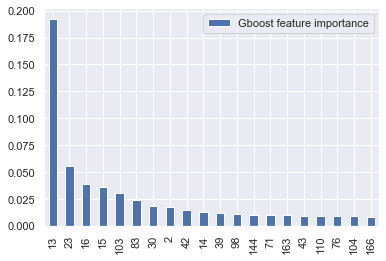

In [585]:
num_cat_tags_gboost_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

## 9) Ensemble models blending the predictions from individual models for the different modalities (rather than combining inputs from all modalities under a unique model type) 

In order to use the existing models as input to a predictor, we need to turn them into transformers; a predictor can only be in the final step of a pipeline. 
We build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor is fit. When `transform` is called, the predictor's `predict` method is called, and its results returned as the transformation.

In [577]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.predictor = model
            
    def fit(self, X, y):
        # Fit the stored predictor.
        self.predictor.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # reshape(-1,1) is required to return a 2-D array which is expected by scikit-learn.
        return np.array(self.predictor.predict(X)).reshape(-1,1)
    

#### Model 9a) Ridge Regression for tags, Decision Tree for numerical+categorical features

Create an instance of ModelTransformer for each of the individual models of interest. Then, we'll combine these together in a single feature matrix with a
FeatureUnion.

In [583]:
#Ridge Regression Model for the union of all tags (after tf-idf and SVD reduction)

#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')


# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])

#define a pipeline with the best values found earlier via cross-validation

tags_union_SVD_ridge_pipe_final = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=500)),
    ('ridge',Ridge(alpha=3.0))
])

tags_ridge_trans = ModelTransformer(tags_union_SVD_ridge_pipe_final)


In [584]:
#Decision Tree model for numerical+categorical features

#Recall that:

# variable_selector_for_trees = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical','passthrough',numerical_columns)
#  ], remainder='drop')

#(I don't want to drop the first variable for tree-based models and I don't need to scale the numerical variables)

#define a pipeline with the best values found earlier via cross-validation

num_plus_cat_dtree_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=7)),
])


num_plus_cat_dtree_trans = ModelTransformer(num_plus_cat_dtree_pipe_final)


In [180]:
#Let's now combine the 2 predictors-transformers into a feature union.

In [585]:
from sklearn.pipeline import FeatureUnion

models_union = FeatureUnion([
        ('tags model',tags_ridge_trans),
        ('num plus cat model', num_plus_cat_dtree_trans),
    ])

In [586]:
models_union

C:\Users\matte\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


FeatureUnion(transformer_list=[('tags model', ModelTransformer(model=None)),
                               ('num plus cat model',
                                ModelTransformer(model=None))])

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [593]:
from sklearn.linear_model import LinearRegression

#note: there is no need of scaling because the output of each transformer is a price prediction in this case,
#and thus all columns are in the same unit and comparable with each other.

blended_model_ridge_dtree_linear = Pipeline([
    ('individual models', models_union),
    ('linear combination', LinearRegression())
])
blended_model_ridge_dtree_linear

Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('tags model',
                                                 ModelTransformer(model=None)),
                                                ('num plus cat model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [597]:
#Train and possibly save the model.
#This is going to fit each of the two models, then fit the best linear combination coefficients
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

blended_model_ridge_dtree_linear_filename = './Git_exclude/models/blended_model_ridge_dtree_linear.joblib'

#If the model file already exists, I load it:
try:
    with open(blended_model_ridge_dtree_linear_filename, 'rb') as f:
        blended_model_ridge_dtree_linear = load(f)
        print('Loaded joblib file with linear blended model of ridge regression for tags, decision tree for numerical+categorical variables.')
except: #if not, actually perform the fit then save the model for next time:
    
    blended_model_ridge_dtree_linear.fit(paintings_df_train,prices_train);
    
    with open(blended_model_ridge_dtree_linear_filename, 'wb') as f:
        dump(blended_model_ridge_dtree_linear, blended_model_ridge_dtree_linear_filename) 
        print('Saved joblib file with linear blended model of ridge regression for tags, decision tree for numerical+categorical variables.')

Loaded joblib file with linear blended model of ridge regression for tags, decision tree for numerical+categorical variables.


In [598]:
#Here are the weights learnt for each of the individual models:
blended_model_ridge_dtree_linear['linear combination'].coef_

array([0.75018905, 0.71596907])

In [595]:
#Predict prices on training set:
prices_train_pred = blended_model_ridge_dtree_linear.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_ridge_dtree_linear.score(paintings_df_train,prices_train)

0.2463051444864982

In [596]:
#Predict prices on test set:
prices_test_pred = blended_model_ridge_dtree_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_ridge_dtree_linear.score(paintings_df_test,prices_test)

0.2080928150169835

In [725]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear blended model of ridge regression for tags, decision tree for numerical+categorical variables')


Random Forest model using numerical + categorical + tags features:
Training R^2: 0.42768510577988084
Testing R^2: 0.23329582184729303
Training RMSE: USD 87.49249859113264
Testing RMSE: USD 101.13734128755789
Training MAE: USD 71.41300747038282
Testing MAE: USD 82.76264604287611


In [199]:
#Let me now try with a Decision tree in place of linear regression as the last step

In [617]:
blended_model_ridge_dtree_rforest = Pipeline([
    ('individual models', models_union),
    ('rforest', RandomForestRegressor(n_estimators=50,n_jobs=2,random_state=1,max_samples=0.8,max_depth=3))
]) #,memory=cache_dir)
blended_model_ridge_dtree_rforest

C:\Users\matte\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('tags model',
                                                 ModelTransformer(model=None)),
                                                ('num plus cat model',
                                                 ModelTransformer(model=None))])),
                ('rforest',
                 RandomForestRegressor(max_depth=3, max_samples=0.8,
                                       n_estimators=50, n_jobs=2,
                                       random_state=1))])

In [618]:
blended_model_ridge_dtree_rforest.fit(paintings_df_train,prices_train);

In [619]:
#Predict prices on training set:
prices_train_pred = blended_model_ridge_dtree_rforest.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_ridge_dtree_rforest.score(paintings_df_train,prices_train)

0.23734330509545065

In [620]:
#Predict prices on test set:
prices_test_pred = blended_model_ridge_dtree_rforest.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_ridge_dtree_rforest.score(paintings_df_test,prices_test)

0.19229084209042469

#### Model 9b) Ridge Regression for tags, Random Forest for numerical+categorical features

In [621]:
num_plus_cat_rforest_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=8,random_state=1,max_samples=0.8))
])

num_plus_cat_rforest_trans = ModelTransformer(num_plus_cat_rforest_pipe_final)

In [622]:
models_union = FeatureUnion([
        ('tags model',tags_ridge_trans),
        ('num plus cat model', num_plus_cat_rforest_trans),
    ])

In [623]:
blended_model_ridge_rforest_linear = Pipeline([
    ('individual models', models_union),
    ('linear combination', LinearRegression())
])
blended_model_ridge_rforest_linear

C:\Users\matte\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('tags model',
                                                 ModelTransformer(model=None)),
                                                ('num plus cat model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [624]:
#Train and possibly save the model.
#This is going to fit each of the two models, then fit the best linear combination coefficients
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

blended_model_ridge_rforest_linear_filename = './Git_exclude/models/blended_model_ridge_rforest_linear.joblib'

#If the model file already exists, I load it:
try:
    with open(blended_model_ridge_rforest_linear_filename, 'rb') as f:
        blended_model_ridge_rforest_linear = load(f)
        print('Loaded joblib file with linear blended model of ridge regression for tags, random forest for numerical+categorical variables.')
except: #if not, actually perform the fit then save the model for next time:
    
    blended_model_ridge_rforest_linear.fit(paintings_df_train,prices_train);
    
    with open(blended_model_ridge_rforest_linear_filename, 'wb') as f:
        dump(blended_model_ridge_rforest_linear, blended_model_ridge_rforest_linear_filename) 
        print('Saved joblib file with linear blended model of ridge regression for tags, random forest for numerical+categorical variables.')

Saved joblib file with linear blended model of ridge regression for tags, random forest for numerical+categorical variables.


In [625]:
#Here are the weights learnt for each of the individual models:
blended_model_ridge_rforest_linear['linear combination'].coef_

array([0.55688544, 1.18001769])

In [626]:
#Predict prices on training set:
prices_train_pred = blended_model_ridge_rforest_linear.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_ridge_rforest_linear.score(paintings_df_train,prices_train)

0.2865950413034266

In [627]:
#Predict prices on test set:
prices_test_pred = blended_model_ridge_rforest_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_ridge_rforest_linear.score(paintings_df_test,prices_test)

0.24217486915797637

In [628]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear blended model of ridge regression for tags, random forest for numerical+categorical variables')


Linear blended model of ridge regression for tags, random forest for numerical+categorical variables:
Training R^2: 0.2865950413034266
Testing R^2: 0.24217486915797637
Training RMSE: USD 97.68353258389139
Testing RMSE: USD 100.55001026277122
Training MAE: USD 79.13396321369463
Testing MAE: USD 81.65174034206682


## 10) Another option could be to use the different models in a cascade rather than in parallel as for the blended model

In [629]:
#Build a custom predictor that takes as an argument two other predictors. 
#It should use the first to fit the raw data and the second to fit the residuals of the first.

In [630]:
class CascadePredictor(BaseEstimator, RegressorMixin):
  def __init__(self, Predictor1, Predictor2):
    # initialization code
    self.predictor1 = Predictor1
    self.predictor2 = Predictor2

  def fit(self, X, y):
    # fit the model:
    self.predictor1.fit(X, y)
    res = y - np.array(self.predictor1.predict(X))
    self.predictor2.fit(X, res)
    return self

  def predict(self, X):
    # make predictions 
    return np.array(self.predictor1.predict(X)) + np.array(self.predictor2.predict(X))

  #def score(self, X, y):
  #  # custom score implementation
  #  # this is optional, if not defined default is R^2
  #  return ...

#### Model 10a) Ridge Regression for tags followed by Decision Tree for numerical+categorical features

In [583]:
#Ridge Regression Model for the union of all tags (after tf-idf and SVD reduction)

#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')


# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])

#define a pipeline with the best values found earlier via cross-validation

tags_union_SVD_ridge_pipe_final = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=500)),
    ('ridge',Ridge(alpha=3.0))
])


In [584]:
#Decision Tree model for numerical+categorical features

#Recall that:

# variable_selector_for_trees = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical','passthrough',numerical_columns)
#  ], remainder='drop')

#(I don't want to drop the first variable for tree-based models and I don't need to scale the numerical variables)

#define a pipeline with the best values found earlier via cross-validation

num_plus_cat_dtree_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=7)),
])



In [632]:
cascade_model_ridge_dtree = CascadePredictor(Predictor1=tags_union_SVD_ridge_pipe_final,Predictor2=num_plus_cat_dtree_pipe_final)

In [633]:
#Train and possibly save the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

cascade_model_ridge_dtree_filename = './Git_exclude/models/cascade_model_ridge_dtree.joblib'

#If the model file already exists, I load it:
try:
    with open(cascade_model_ridge_dtree_filename, 'rb') as f:
        cascade_model_ridge_dtree = load(f)
        print('Loaded joblib file with cascaded model of ridge regression for tags, decision tree for numerical+categorical variables.')
except: #if not, actually perform the fit then save the model for next time:
    
    cascade_model_ridge_dtree.fit(paintings_df_train,prices_train);
    
    with open(cascade_model_ridge_dtree_filename, 'wb') as f:
        dump(cascade_model_ridge_dtree, cascade_model_ridge_dtree_filename) 
        print('Saved joblib file with cascaded model of ridge regression for tags, decision tree for numerical+categorical variables.')

Saved joblib file with cascaded model of ridge regression for tags, decision tree for numerical+categorical variables.


In [634]:
#Predict prices on training set:
prices_train_pred = cascade_model_ridge_dtree.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_ridge_dtree.score(paintings_df_train,prices_train)

0.26563093595618814

In [635]:
#Predict prices on test set:
prices_test_pred = blended_model_ridge_dtree_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_ridge_dtree_linear.score(paintings_df_test,prices_test)

0.2080928150169835

In [636]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Cascaded model of ridge regression for tags, decision tree for numerical+categorical variables')


Cascaded model of ridge regression for tags, decision tree for numerical+categorical variables:
Training R^2: 0.26563093595618814
Testing R^2: 0.2080928150169835
Training RMSE: USD 99.10840383580587
Testing RMSE: USD 102.78618789074042
Training MAE: USD 79.26219138144528
Testing MAE: USD 83.50649429675813


#### Model 10b) Ridge Regression for tags, Random Forest for numerical+categorical features

In [637]:
num_plus_cat_rforest_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=8,random_state=1,max_samples=0.8))
])


In [639]:
cascade_model_ridge_rforest = CascadePredictor(Predictor1=tags_union_SVD_ridge_pipe_final,Predictor2=num_plus_cat_rforest_pipe_final)

In [640]:
#Train and possibly save the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

cascade_model_ridge_rforest_filename = './Git_exclude/models/cascade_model_ridge_rforest.joblib'

#If the model file already exists, I load it:
try:
    with open(cascade_model_ridge_rforest_filename, 'rb') as f:
        cascade_model_ridge_rforest = load(f)
        print('Loaded joblib file with cascaded model of ridge regression for tags, random forest for numerical+categorical variables.')
except: #if not, actually perform the fit then save the model for next time:
    
    cascade_model_ridge_rforest.fit(paintings_df_train,prices_train);
    
    with open(cascade_model_ridge_rforest_filename, 'wb') as f:
        dump(cascade_model_ridge_rforest, cascade_model_ridge_rforest_filename) 
        print('Saved joblib file with cascaded model of ridge regression for tags, random forest for numerical+categorical variables.')

Saved joblib file with cascaded model of ridge regression for tags, random forest for numerical+categorical variables.


In [641]:
#Predict prices on training set:
prices_train_pred = cascade_model_ridge_rforest.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_ridge_rforest.score(paintings_df_train,prices_train)

0.2894857275162662

In [642]:
#Predict prices on test set:
prices_test_pred = cascade_model_ridge_rforest.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_ridge_rforest.score(paintings_df_test,prices_test)

0.2264685464999482

In [643]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Cascaded model of ridge regression for tags, random forest for numerical+categorical variables')


Cascaded model of ridge regression for tags, random forest for numerical+categorical variables:
Training R^2: 0.2894857275162662
Testing R^2: 0.2264685464999482
Training RMSE: USD 97.48542696474341
Testing RMSE: USD 101.5866424290413
Training MAE: USD 78.63791475258549
Testing MAE: USD 82.26668936549784


In [651]:
#Can I perhaps cross-validate the choice of alpha in the ridge regression, since now the predictors are cascaded?

In [ ]:
#I need to do it like this

In [652]:
cascade_model_ridge_rforest.get_params().keys()

dict_keys(['Predictor1', 'Predictor2'])

In [653]:
#Recall that:
# tags_union_SVD_ridge_pipe_final = Pipeline([
#     ('all tags tfidf vectorization', tags_info_union),
#     ('SVD', TruncatedSVD(n_components=500)),
#     ('ridge',Ridge(alpha=3.0))
# ])

tags_union_SVD_ridge_pipe_alt1 = tags_union_SVD_ridge_pipe_final
params_alt1 = {'ridge__alpha':1.0}
tags_union_SVD_ridge_pipe_alt1.set_params(**params_alt1)

Pipeline(steps=[('all tags tfidf vectorization',
                 FeatureUnion(transformer_list=[('tags tf-idf',
                                                 ColumnTransformer(transformers=[('tags '
                                                                                  'tfidf',
                                                                                  Pipeline(steps=[('to '
                                                                                                   'single '
                                                                                                   'string',
                                                                                                   TagsEncoder()),
                                                                                                  ('to '
                                                                                                   'tfidf '
                                                                                                   'n-grams',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                2)))]),
                                                                                  'tags')])),
                                                ('style tags tf-idf',
                                                 ColumnTransformer(transformers=[('style '
                                                                                  'tags '
                                                                                  'tfidf',
                                                                                  Pipeline(steps=[...
                                                                                                   TagsEncoder()),
                                                                                                  ('to '
                                                                                                   'tfidf '
                                                                                                   'n-grams',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                2)))]),
                                                                                  'style_tags_new')])),
                                                ('materials tags tf-idf',
                                                 ColumnTransformer(transformers=[('materials '
                                                                                  'tfidf',
                                                                                  Pipeline(steps=[('to '
                                                                                                   'single '
                                                                                                   'string',
                                                                                                   TagsEncoder()),
                                                                                                  ('to '
                                                                                                   'tfidf '
                                                                                                   'n-grams',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                2)))]),
                                           

In [662]:
tags_union_SVD_ridge_pipe_alt2 = tags_union_SVD_ridge_pipe_final
params_alt2 = {'ridge__alpha':5}
tags_union_SVD_ridge_pipe_alt2.set_params(**params_alt2)

Pipeline(steps=[('all tags tfidf vectorization',
                 FeatureUnion(transformer_list=[('tags tf-idf',
                                                 ColumnTransformer(transformers=[('tags '
                                                                                  'tfidf',
                                                                                  Pipeline(steps=[('to '
                                                                                                   'single '
                                                                                                   'string',
                                                                                                   TagsEncoder()),
                                                                                                  ('to '
                                                                                                   'tfidf '
                                                                                                   'n-grams',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                2)))]),
                                                                                  'tags')])),
                                                ('style tags tf-idf',
                                                 ColumnTransformer(transformers=[('style '
                                                                                  'tags '
                                                                                  'tfidf',
                                                                                  Pipeline(steps=[...
                                                                                                  ('to '
                                                                                                   'tfidf '
                                                                                                   'n-grams',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                2)))]),
                                                                                  'style_tags_new')])),
                                                ('materials tags tf-idf',
                                                 ColumnTransformer(transformers=[('materials '
                                                                                  'tfidf',
                                                                                  Pipeline(steps=[('to '
                                                                                                   'single '
                                                                                                   'string',
                                                                                                   TagsEncoder()),
                                                                                                  ('to '
                                                                                                   'tfidf '
                                                                                                   'n-grams',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                2)))]),
                                                                                  'materials')]))])),
                ('SVD', TruncatedSVD(n_components=500)),

In [655]:
#I tried to use GridSearchCV as follows but it didn't work:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'Predictor1': [tags_union_SVD_ridge_pipe_final,tags_union_SVD_ridge_pipe_alt1,tags_union_SVD_ridge_pipe_alt2]}
# cascade_model_ridge_rforest_CVmodel = GridSearchCV(cascade_model_ridge_rforest, param_grid, cv=5, n_jobs=2, verbose=1)

# cascade_model_ridge_rforest_CVmodel.fit(paintings_df_train,prices_train)



In [657]:
#So I instead tried manually the 2 alternatives:

In [658]:
cascade_model_ridge_rforest_alt1 = CascadePredictor(Predictor1=tags_union_SVD_ridge_pipe_alt1,Predictor2=num_plus_cat_rforest_pipe_final)

In [659]:
#Train and possibly save the model.
cascade_model_ridge_rforest_alt1.fit(paintings_df_train,prices_train);

In [660]:
#Predict prices on training set:
prices_train_pred = cascade_model_ridge_rforest_alt1.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_ridge_rforest_alt1.score(paintings_df_train,prices_train)

0.29024381950168243

In [663]:
#Predict prices on test set:
prices_test_pred = cascade_model_ridge_rforest_alt1.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_ridge_rforest_alt1.score(paintings_df_test,prices_test)

0.21649911574943492

In [664]:
cascade_model_ridge_rforest_alt2 = CascadePredictor(Predictor1=tags_union_SVD_ridge_pipe_alt2,Predictor2=num_plus_cat_rforest_pipe_final)

In [665]:
cascade_model_ridge_rforest_alt2.fit(paintings_df_train,prices_train);

In [666]:
#Predict prices on training set:
prices_train_pred = cascade_model_ridge_rforest_alt2.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_ridge_rforest_alt2.score(paintings_df_train,prices_train)

0.2908907388406178

In [667]:
#Predict prices on test set:
prices_test_pred = cascade_model_ridge_rforest_alt2.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_ridge_rforest_alt2.score(paintings_df_test,prices_test)

0.2265088981297535

## 11) Nearest Neighbors Regression (mostly to find comparable paintings)

In [668]:
#I need to have all features in comparable scales (e.g. within 0 and 1)

In [669]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')


# tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
#                                 ("style tags tf-idf", style_tags_tranform),
#                                 ("materials tags tf-idf", materials_tags_tranform),
#                                ])

#define a pipeline with the best values found earlier via cross-validation

tags_union_SVD_scaling_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=500)),
    ('scaling', MinMaxScaler())
])



In [670]:
#Recall that:

# variable_selector_for_ridge = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical',MinMaxScaler(),numerical_columns)
#  ], remainder='drop')

num_plus_cat_scaling_pipe = Pipeline([('num and cat preproc', variable_selector_for_ridge)])

In [671]:
features_union = FeatureUnion([
        ('tags scaled features',tags_union_SVD_scaling_pipe),
        ('num plus cat features', variable_selector_for_ridge),
    ])

In [676]:
from sklearn.neighbors import KNeighborsRegressor

knn_pipe = Pipeline([
    ('all scaled features', features_union),
    ('knn', KNeighborsRegressor(n_neighbors=5,n_jobs=2))
])

In [677]:
#I can try to search for a good value of number of neighbors using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': range(1, 22, 4)} 
knn_CVmodel = GridSearchCV(knn_pipe, param_grid, cv=5, n_jobs=2, verbose=1)


In [ ]:
#Train and possibly save the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

knn_CVmodel_filename = './Git_exclude/models/knn_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(knn_CVmodel_filename, 'rb') as f:
        knn_CVmodel = load(f)
        print('Loaded joblib file with cross-validated KNN regression using scaled tags, numerical+categorical variables.')
except: #if not, actually perform the fit then save the model for next time:
    
    knn_CVmodel.fit(paintings_df_train,prices_train)
    
    with open(knn_CVmodel_filename, 'wb') as f:
        dump(knn_CVmodel, knn_CVmodel_filename) 
        print('Saved joblib file with cross-validated KNN regression using scaled tags, numerical+categorical variables.')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
knn_CVmodel.best_params_

In [674]:
#Predict prices on training set:
prices_train_pred = knn_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
knn_CVmodel.score(paintings_df_train,prices_train)

0.42280042932207795

In [675]:
#Predict prices on test set:
prices_test_pred = knn_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
knn_CVmodel.score(paintings_df_test,prices_test)

0.10932155586971437

In [643]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='K nearest neighbors regression for (scaled) tags, numerical+categorical variables')


Cascaded model of ridge regression for tags, random forest for numerical+categorical variables:
Training R^2: 0.2894857275162662
Testing R^2: 0.2264685464999482
Training RMSE: USD 97.48542696474341
Testing RMSE: USD 101.5866424290413
Training MAE: USD 78.63791475258549
Testing MAE: USD 82.26668936549784


In [ ]:
#This is how you would check for the nearest neighbors of a test painting:
num_neighbors_to_return = 10 
neigh_dist, neigh_ind = knn_CVmodel.kneighbors(paintings_df_test.iloc[0],num_neighbors_to_return,return_distance=True)